In [1]:
%cd ../

/Users/harrysonghurst/Documents/Coursework/L48 Machine Learning and the Physical World/TrafficEmuCO2MS copy


In [ ]:
# For colab
'''
!sudo add-apt-repository ppa:sumo/stable
!sudo apt-get update
!sudo apt-get install sumo sumo-tools sumo-doc
! git clone https://github.com/Nicholas-Kastanos/TrafficEmu
%cd TrafficEmu
!pip install GPy pickle seaborn
!pip install emukit pyDOE
!pip install sumolib traci
import os
os.environ['SUMO_HOME'] = '/usr/share/sumo'
!sumo
'''

In [2]:
# If you get a SciPy error when installing Emukit, build it from source:

# git clone https://github.com/amzn/Emukit.git
# cd Emukit
# pip install -r requirements/requirements.txt
# python setup.py develop

In [3]:
import numpy as np
import pickle
import emukit as ek
import GPy

from emukit.model_wrappers import GPyModelWrapper
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs import RandomDesign, latin_design
from emukit.experimental_design.acquisitions import ModelVariance, IntegratedVarianceReduction
from emukit.core.loop import UserFunctionWrapper
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.core.optimization import GradientAcquisitionOptimizer
import matplotlib.pyplot as plt
import seaborn as sns

from sumo_grid_simulation.grid_simulation import Simulator

sns.set()
INIT = 20
LOOPS = 500

### Pseudocode

Fitting a gaussian process to a simulator using Emukit takes the following form (taken from L48 lectures):

```
initialize GP with some randomly chosen points
while stopping condition is not met:
    compute candidate point(s) using GP and acquisition funciton (model_variance) -> new point
    evaluate this new point with our simulator/user function -> observation
    update model with new observation -> new GP
```

### Simulator

In [4]:
simulator = Simulator(end_time=300)

### User Function
 
This is the function we want to understand. Namedly, how are CO2 emissions and timeLoss (the time lost due to driving below the ideal speed) affected by the following parameters: 

```
gridSize: the size of the grid network where the simulation is carried out
edgeMaxSpeed: legal speed limit in m/s - this can be exceeded (11.11 == 40km/h)
maxSpeed: the absolute maximum velocity of any vehicle in m/s (55.55 == 200 km/h)
edgeLength: length of the roads between intersections in meters
numLanes: number of lanes per road
accel: The acceleration ability of vehicles in m/s^2.
```

*A complete list of parmeters analysed is discussed in our report.*

In [5]:
def user_function(X):
    """  X = inputs - emukit doesnt pass named args, just an NxM ndarray, N is the number of points to evaluate, M is the number of parameters per each point """
    result = []
    i = 0
    
    print(X)
    print(f'\nUser function time loss called with {X.shape[0]} inputs to simulate')

    
    for gridSize, edgeMaxSpeed, edgeLength, numLanes, accel in X:
        print(f'\nEvaluating input: {i+1} of {X.shape[0]}\n')
        
        beta = 0.05
        max_number_of_vehicles = ((gridSize - 1) * gridSize * 2 + 4 * gridSize) * edgeLength / 5
        period = 300/(max_number_of_vehicles * beta)
        
        s = simulator.simulate(
            junctionType  = 2,
            tlType        = 2, 
            gridSize      = int(gridSize),
            edgeMaxSpeed  = edgeMaxSpeed,
            edgeLength    = edgeLength,
            numberOfLanes = int(numLanes),
            accel         = accel,
            trips_generator_period = period
        )
        num_veh = max_number_of_vehicles * beta
        CO2 = s['CO2'] / (num_veh * s['duration'])
        # average emissions / average route length
        result.append(CO2)
        i += 1
        
    # expand dims is essential or the acquition function breaks
    return np.expand_dims(np.array(result), 1)  

### Model Inputs / parameter space

In [6]:
gridSize = DiscreteParameter('gridSize', domain=[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
edgeMaxSpeed = ContinuousParameter('edgeMaxSpeed', min_value=8, max_value=19)
edgeLength = ContinuousParameter('edgeLength', min_value=30, max_value=70)
numberOfLanes = DiscreteParameter('numberOfLanes', domain=[1,2,3])
accel = ContinuousParameter('accel', 1.5, 5.)

parameter_space = ParameterSpace([gridSize, edgeMaxSpeed, edgeLength, numberOfLanes, accel])

### Get init and test points

In [7]:
design = RandomDesign(parameter_space)
init_X = design.get_samples(INIT)
init_Y = user_function(init_X)

design = RandomDesign(parameter_space)
test_X = design.get_samples(100)
test_Y = user_function(test_X)

[[ 8.         11.80273316 43.82382143  3.          4.38446826]
 [19.         11.28460954 66.0114197   3.          2.83426885]
 [19.         11.35781751 42.49845057  2.          3.21989857]
 [15.         14.72650305 53.57481032  3.          1.58244383]
 [ 4.          9.69689007 65.49570828  2.          2.74848479]
 [ 5.         15.18035781 62.48519207  3.          4.93578123]
 [ 6.          9.27442479 48.94101937  1.          3.34896541]
 [11.         16.17200502 64.70568517  3.          3.49578346]
 [19.         13.67206123 48.7047315   3.          3.30032028]
 [ 7.         15.28700667 53.66577718  2.          2.23018036]
 [17.         12.74810997 52.55628074  1.          2.02402965]
 [ 4.          8.711565   39.26506844  2.          4.67678757]
 [17.         16.55170345 30.43429525  1.          1.73516905]
 [11.         18.24419639 52.72998102  1.          3.21183473]
 [ 5.          8.46467145 37.20215278  3.          4.34438949]
 [16.         17.44816692 38.98614047  2.          1.66

 Retrying in 1 seconds

Evaluating input: 2 of 100

 Retrying in 1 seconds

Evaluating input: 3 of 100

 Retrying in 1 seconds

Evaluating input: 4 of 100

 Retrying in 1 seconds

Evaluating input: 5 of 100

 Retrying in 1 seconds

Evaluating input: 6 of 100

 Retrying in 1 seconds

Evaluating input: 7 of 100

 Retrying in 1 seconds

Evaluating input: 8 of 100

 Retrying in 1 seconds

Evaluating input: 9 of 100

 Retrying in 1 seconds

Evaluating input: 10 of 100

 Retrying in 1 seconds

Evaluating input: 11 of 100

 Retrying in 1 seconds

Evaluating input: 12 of 100

 Retrying in 1 seconds

Evaluating input: 13 of 100

 Retrying in 1 seconds

Evaluating input: 14 of 100

 Retrying in 1 seconds

Evaluating input: 15 of 100

 Retrying in 1 seconds

Evaluating input: 16 of 100

 Retrying in 1 seconds

Evaluating input: 17 of 100

 Retrying in 1 seconds

Evaluating input: 18 of 100

 Retrying in 1 seconds

Evaluating input: 19 of 100

 Retrying in 1 seconds

Evaluating input: 20 of 100

 

### Experimental Design - Model Variance

In [8]:
MV_Xs = []
MV_Ys = []
mses_MV = []
    
def user_function_model_variance(X):
    """  X = inputs - emukit doesnt pass named args, just an NxM ndarray, N is the number of points to evaluate, M is the number of parameters per each point """
    result = []
    i = 0
    
    print(X)
    print(f'\nUser function time loss called with {X.shape[0]} inputs to simulate')

    
    for gridSize, edgeMaxSpeed, edgeLength, numLanes, accel in X:
        print(f'\nEvaluating input: {i+1} of {X.shape[0]}\n')
        
        beta = 0.05
        max_number_of_vehicles = ((gridSize - 1) * gridSize * 2 + 4 * gridSize) * edgeLength / 5
        period = 300/(max_number_of_vehicles * beta)
        
        s = simulator.simulate(
            tlType        = 2,
            junctionType  = 2,
            gridSize      = int(gridSize),
            edgeMaxSpeed  = edgeMaxSpeed,
            edgeLength    = edgeLength,
            numberOfLanes = int(numLanes),
            accel         = accel,
            trips_generator_period = period
        )
        num_veh = max_number_of_vehicles * beta
        CO2 = s['CO2'] / (num_veh * s['duration'])
        result.append(CO2)
        MV_Xs.append([int(gridSize), edgeMaxSpeed, edgeLength, int(numLanes), accel])
        MV_Ys.append(CO2)

        i += 1
    
    # evaluate / validate model
    if len(MV_Xs) % 50 == 0:
        pred_Y, pred_Y_variance = emukit_model_mv.predict(np.array(test_X))
        rmse = np.sqrt(np.mean((pred_Y-test_Y)**2))
        mses_MV.append((len(MV_Xs), rmse))
        print('EVALUATED: ', len(MV_Xs), rmse)
        
    # expand dims is essential or the acquition function breaks
    return np.expand_dims(np.array(result), 1)  

#### Model / Emulator (GP)

Our surrogate model is our emulator. In this case, a gaussian process.

In [9]:
# emulator_mv = GPy.models.GPRegression(init_X, init_Y)

# kg = GPy.kern.RBF(input_dim=5, ARD=True)
kg = GPy.kern.RBF(input_dim=5, ARD=True)
emulator_mv = GPy.models.GPRegression(init_X, init_Y, kg)
emulator_mv.optimize()

emukit_model_mv = GPyModelWrapper(emulator_mv, n_restarts=5)
emukit_model_mv.optimize()
emulator_mv

Optimization restart 1/5, f = 154.28828754855385
Optimization restart 2/5, f = 161.93835985724985
Optimization restart 3/5, f = 161.5874661710882
Optimization restart 4/5, f = 707.97474411328
Optimization restart 5/5, f = 151.62961858991534


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


GP_regression.,value,constraints,priors
rbf.variance,934170.5807962142,+ve,
rbf.lengthscale,"(5,)",+ve,
Gaussian_noise.variance,136618.27614618753,+ve,


#### Acquisition Function

In [10]:
model_variance = ModelVariance(model=emukit_model_mv)

#### Optimizer

In [11]:
optimizer = GradientAcquisitionOptimizer(parameter_space)


#### Experimental Design Loop

In [12]:
ed_loop_mv = ExperimentalDesignLoop(
    model = emukit_model_mv,
    space = parameter_space,
    acquisition = model_variance,
    acquisition_optimizer = optimizer,
    batch_size = 1
)

In [13]:
ed_loop_mv.run_loop(user_function_model_variance, LOOPS)

Optimization restart 1/5, f = 151.62961855918402
Optimization restart 2/5, f = 158.70052662194456
Optimization restart 3/5, f = 153.22736907235156
Optimization restart 4/5, f = 162.14120666603333


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 2136.4316143732563
[[20.   8.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 159.778120303379
Optimization restart 2/5, f = 169.8504367920778
Optimization restart 3/5, f = 170.45015487915668
Optimization restart 4/5, f = 164.38297834069263
Optimization restart 5/5, f = 170.30122387674277
[[20. 19. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 166.88862335696655
Optimization restart 2/5, f = 2825.960858991926
Optimization restart 3/5, f = 181.750692441827
Optimization restart 4/5, f = 366.1849977334613
Optimization restart 5/5, f = 178.67534489038317
[[ 3.  19.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/5, f = 174.5618581784369
Optimization restart 2/5, f = 190.52633034110076
Optimization restart 3/5, f = 187.22007447932592
Optimization restart 4/5, f = 185.82768215769343
Optimization restart 5/5, f = 226.1681665017245
[[20.          8.         55.95962971  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 181.8899791879503
Optimization restart 2/5, f = 193.86949421475703
Optimization restart 3/5, f = 795.6170970162511
Optimization restart 4/5, f = 194.05403590235323
Optimization restart 5/5, f = 193.35846752883384
[[ 8.   8.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 188.95157443571304
Optimization restart 2/5, f = 200.34671907390137
Optimization restart 3/5, f = 244.28831111004226
Optimization restart 4/5, f = 201.84908541954508
Optimization restart 5/5, f = 201.3477581563416
[[20.         19.         42.36791663  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/5, f = 195.95747101080553
Optimization restart 2/5, f = 451.84132350566006
Optimization restart 3/5, f = 200.7825358548695
Optimization restart 4/5, f = 252.91875221725905
Optimization restart 5/5, f = 211.1171785668236
[[ 3.         19.         53.42197685  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 203.10876422215173
Optimization restart 2/5, f = 1954.0462222261608
Optimization restart 3/5, f = 212.77858276379112
Optimization restart 4/5, f = 205.51321672651932
Optimization restart 5/5, f = 225.03629174348856
[[ 3.        19.        40.7694809  3.         5.       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 210.77952449640696
Optimization restart 2/5, f = 215.45930077590674
Optimization restart 3/5, f = 228.29245712133422
Optimization restart 4/5, f = 219.2673029864169
Optimization restart 5/5, f = 221.17635388375504
[[10.         8.        48.4935905  1.         5.       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/5, f = 217.78651208946036
Optimization restart 2/5, f = 238.29014178376747
Optimization restart 3/5, f = 2969.8165981728716
Optimization restart 4/5, f = 235.83560806033978
Optimization restart 5/5, f = 220.40650032926646
[[ 3.          8.         41.17908463  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 224.93193223323092
Optimization restart 2/5, f = 244.47733765347797
Optimization restart 3/5, f = 538.1062110149162
Optimization restart 4/5, f = 330.9937523280811
Optimization restart 5/5, f = 363.6547126193002
[[20.         19.         66.11116795  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 227.03346610619784
Optimization restart 2/5, f = 236.42912025795297
Optimization restart 3/5, f = 251.00635971698895


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 246.90770971284977
Optimization restart 5/5, f = 253.688995943402
[[ 6.         12.86030715 48.11004156  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 233.48466441262363
Optimization restart 2/5, f = 252.64460017015455
Optimization restart 3/5, f = 254.33445793068574
Optimization restart 4/5, f = 258.4874511401586
Optimization restart 5/5, f = 259.0020627535707
[[11.         12.4500802  50.62462957  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 239.9139878225551
Optimization restart 2/5, f = 284.2936846480738
Optimization restart 3/5, f = 266.650305278821
Optimization restart 4/5, f = 264.1287546867849
Optimization restart 5/5, f = 266.0595965656295
[[ 3. 19. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater


Optimization restart 1/5, f = 260.61727484427746
Optimization restart 2/5, f = 330.6056783196571
Optimization restart 3/5, f = 15033.292145397381
Warning - optimization restart 4/5 failed
Optimization restart 5/5, f = 295.45316500262487
[[15.   8.  30.   2.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/5, f = 267.5528197384942
Optimization restart 2/5, f = 1672.8553576980082
Optimization restart 3/5, f = 274.08041691264845
Optimization restart 4/5, f = 387.6041597104954
Optimization restart 5/5, f = 276.46869561878435
[[20.  8. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/5, f = 274.45629029659716
Optimization restart 2/5, f = 4333.525536499579
Optimization restart 3/5, f = 297.06485432118455
Optimization restart 4/5, f = 285.6211169538983


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 393.7168517422832
[[ 3.         19.         45.00676339  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 281.41775024946713
Optimization restart 2/5, f = 290.1770686027303
Optimization restart 3/5, f = 4258.330159635875
Optimization restart 4/5, f = 333.4948755839969
Optimization restart 5/5, f = 427.3689182467177
[[ 3.  8. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 288.27312140677606
Optimization restart 2/5, f = 314.07685925915433
Optimization restart 3/5, f = 1544.85175952173
Optimization restart 4/5, f = 364.03316650906766


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 357.5519752116305
[[ 3.          8.         51.86602019  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 295.22507584895135
Optimization restart 2/5, f = 320.0220517042228
Optimization restart 3/5, f = 310.3257935808056
Optimization restart 4/5, f = 321.6376244599022


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 2163.943533033521
[[17. 19. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 303.1790953199421
Optimization restart 2/5, f = 328.6852106856971
Optimization restart 3/5, f = 314.95637726377845
Optimization restart 4/5, f = 897.5111520300059


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 5/5, f = 332.7834096265855
[[20.   8.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 310.0313620597562
Optimization restart 2/5, f = 305.73490374489603
Optimization restart 3/5, f = 2606.2290747503466
Optimization restart 4/5, f = 394.15813938201876
Optimization restart 5/5, f = 319.12400321346854
[[11.         19.         47.83398979  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 312.5581559859776
Optimization restart 2/5, f = 335.470064372303
Optimization restart 3/5, f = 344.9938655825925
Optimization restart 4/5, f = 332.4428544509291
Optimization restart 5/5, f = 344.21404484764844
[[11.         19.         51.07368821  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 319.3537545072644
Optimization restart 2/5, f = 342.1231082074462
Optimization restart 3/5, f = 339.6191082513931
Optimization restart 4/5, f = 480.7496370064159


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater


Warning - optimization restart 5/5 failed
[[17.         19.         53.23158531  2.          3.18562319]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 326.1222166395221
Optimization restart 2/5, f = 425.73002918284357
Optimization restart 3/5, f = 349.3039586560097
Optimization restart 4/5, f = 990.3668756949513
Optimization restart 5/5, f = 343.67402604488484
[[10.         13.32689052 39.85321831  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 332.9591886582718
Optimization restart 2/5, f = 354.5805007369673
Optimization restart 3/5, f = 351.3582008759282


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 364.8829485055647
Optimization restart 5/5, f = 363.98038558038644
[[ 8.          8.         46.85987257  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 339.7804566964154
Optimization restart 2/5, f = 360.0206696088891
Optimization restart 3/5, f = 358.6422849700125
Optimization restart 4/5, f = 2341.559575845283
Optimization restart 5/5, f = 376.9269686298599
[[17.         8.        65.0621844  2.         5.       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 346.6644543390768
Optimization restart 2/5, f = 364.0319232990928
Optimization restart 3/5, f = 372.56184562551493
Optimization restart 4/5, f = 362.8897381565376
Optimization restart 5/5, f = 111784.30288329959
[[11.          8.         43.42568737  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 353.42683324423734
Optimization restart 2/5, f = 785.316233376675
Optimization restart 3/5, f = 601.7022588216375
Optimization restart 4/5, f = 391.9424113481828
Optimization restart 5/5, f = 463.7297214553879
[[11.        19.        60.6335945  3.         1.5      ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/5, f = 360.18903686278935
Optimization restart 2/5, f = 99684.88086935288
Optimization restart 3/5, f = 401.31199830195953
Optimization restart 4/5, f = 381.3643353940949
Optimization restart 5/5, f = 41461.10000350595
[[ 4.         13.40058913 66.54461469  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 367.51386794299134
Optimization restart 2/5, f = 1780.0737500925372
Optimization restart 3/5, f = 383.1182294551029
Optimization restart 4/5, f = 26054.058590223263
Optimization restart 5/5, f = 392.2874812673432
[[ 9.         19.         55.06516731  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 374.2727749571711
Optimization restart 2/5, f = 404.0733351519771
Optimization restart 3/5, f = 413.69657989589086
Optimization restart 4/5, f = 373.8777056855798
Optimization restart 5/5, f = 380.61262499586695
[[12.         13.47764904 56.63469066  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1



 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 380.5886584804785
Optimization restart 2/5, f = 415.1598534348648
Optimization restart 3/5, f = 689.0507229191369
Optimization restart 4/5, f = 387.0764987474387
Optimization restart 5/5, f = 401.5016640447276
[[18.          8.         40.18195586  3.          3.23750695]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 387.2711363582032
Optimization restart 2/5, f = 407.88753184975997
Optimization restart 3/5, f = 441.90428664922035
Optimization restart 4/5, f = 422.23403676550976
Optimization restart 5/5, f = 796.2097217640326
[[ 3.         19.         37.21470631  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 393.9233625222561
Optimization restart 2/5, f = 442.5143338941901
Optimization restart 3/5, f = 411.3406511794117
Optimization restart 4/5, f = 417.57139928975363
Optimization restart 5/5, f = 414.9776253222519
[[19.  19.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 401.6824256367853
Optimization restart 2/5, f = 401.67584496048147
Optimization restart 3/5, f = 426.1347721259493
Optimization restart 4/5, f = 105548.42873883242
Optimization restart 5/5, f = 422.09351778238636
[[10.         13.36101603 66.53730934  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1



 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater


Optimization restart 1/5, f = 408.40987308708185
Warning - optimization restart 2/5 failed
Optimization restart 3/5, f = 3485.841946182508


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 4/5, f = 446.3376658184728
Optimization restart 5/5, f = 791.1259737590101
[[ 3.         8.        39.0339891  3.         1.5      ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 415.94280293319605
Optimization restart 2/5, f = 436.1387184756649
Optimization restart 3/5, f = 623.5918585675633
Optimization restart 4/5, f = 465.46092233337646
Optimization restart 5/5, f = 439.70379202609763
[[17.         13.33886619 61.02046029  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 422.58595270816653
Optimization restart 2/5, f = 444.3659071683617
Optimization restart 3/5, f = 443.6367503691684
Optimization restart 4/5, f = 451.26501440122126
Optimization restart 5/5, f = 473.9305309144699
[[ 6.         19.         43.65551932  2.          3.22550388]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/5, f = 429.2242822759497
Optimization restart 2/5, f = 652.5923557708822
Optimization restart 3/5, f = 451.7967240030305
Optimization restart 4/5, f = 481.386338782733
Optimization restart 5/5, f = 480.99161199855246
[[ 3.  8. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 435.890052811825
Optimization restart 2/5, f = 483.5191113370305
Optimization restart 3/5, f = 456.37080812221006
Optimization restart 4/5, f = 489.4987449581457
Optimization restart 5/5, f = 488.9098458316561
[[15.         13.48396    59.36809235  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 442.52192397360614
Optimization restart 2/5, f = 496.4689010119808
Optimization restart 3/5, f = 470.58750813010874
Optimization restart 4/5, f = 497.47764078507066
Optimization restart 5/5, f = 460.50025157452905
[[ 3.   8.  70.   2.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 449.15367074607735
Optimization restart 2/5, f = 485.85092940041517
Optimization restart 3/5, f = 449.0337891592496
Optimization restart 4/5, f = 471.6595583638199
Optimization restart 5/5, f = 60646.7770528596
[[10.         13.43514634 33.20868449  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1



 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/5, f = 457.57807921444646
Optimization restart 2/5, f = 1073.9493472713352
Optimization restart 3/5, f = 490.5231637685575
Optimization restart 4/5, f = 1919.3937117771284
Optimization restart 5/5, f = 32971.268010297674
[[13.          8.         44.20944177  2.          3.27849679]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 464.42715996699917
Optimization restart 2/5, f = 488.62918478220695
Optimization restart 3/5, f = 13545.346314375533
Optimization restart 4/5, f = 495.06200866615484
Optimization restart 5/5, f = 488.88371714665413
[[19.         19.         65.37727152  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 471.0247633718421
Optimization restart 2/5, f = 471.0174482518639
Optimization restart 3/5, f = 530.4268396958512
Optimization restart 4/5, f = 503.1459061806923
Optimization restart 5/5, f = 521.03829810067
[[ 3.         19.         58.61408687  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1



 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 479.0147253632176
Optimization restart 2/5, f = 510.4791362892424
Optimization restart 3/5, f = 1261.730009226916
Optimization restart 4/5, f = 503.10567637830434
Optimization restart 5/5, f = 780.4127425705867
[[ 3.         19.         56.97375819  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 485.7823244792371
Optimization restart 2/5, f = 511.14198066444646
Optimization restart 3/5, f = 513.664260869151
Optimization restart 4/5, f = 504.28951648925465
Optimization restart 5/5, f = 638.2829548825803
[[13.          8.         61.69184841  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 492.4977106765275
Optimization restart 2/5, f = 1100.526484200272
Optimization restart 3/5, f = 591.9512589946022
Optimization restart 4/5, f = 518.3350343350515
Optimization restart 5/5, f = 524.3366740039522
[[20.         13.28226155 54.29639052  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 499.1014411774138
Optimization restart 2/5, f = 523.0613154075617
Optimization restart 3/5, f = 7674.869830807151
Optimization restart 4/5, f = 716.6673901829515
Optimization restart 5/5, f = 531.7062032028222
[[17.         13.43876008 59.49062124  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  50 231.665864320083
Optimization restart 1/5, f = 505.6931588918358
Optimization restart 2/5, f = 660.4033554374848
Optimization restart 3/5, f = 540.3450229882471


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 560.1340740994646
Optimization restart 5/5, f = 529.3239061207446
[[ 5.         19.         48.15307389  1.          3.27350638]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 512.8252117627804
Optimization restart 2/5, f = 512.8166419130173
Optimization restart 3/5, f = 512.8165979951202
Optimization restart 4/5, f = 7056.024490306361
Optimization restart 5/5, f = 512.8166435774565
[[ 3.          8.         67.71176063  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1



 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 519.5046171833294
Optimization restart 2/5, f = 2782.9376710999877
Optimization restart 3/5, f = 555.1044016152273
Optimization restart 4/5, f = 552.709442917235
Optimization restart 5/5, f = 546.387533919605
[[20.          8.         61.41534497  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 526.2055940665145
Optimization restart 2/5, f = 575.6800761032763
Optimization restart 3/5, f = 549.5396145005373
Optimization restart 4/5, f = 603.7474181114484
Optimization restart 5/5, f = 555.2375451469119
[[18.          8.         39.18026024  2.          3.23663608]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 532.9904836957583
Optimization restart 2/5, f = 532.9694283623058
Optimization restart 3/5, f = 532.9694286624083
Optimization restart 4/5, f = 556.5003423214292
Optimization restart 5/5, f = 1648.669000027359
[[13.         19.         39.96918584  3.          3.26661545]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1



 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 540.162709278246
Optimization restart 2/5, f = 610.8026242661363
Optimization restart 3/5, f = 540.1605401516541
Optimization restart 4/5, f = 1095.1681702499131
Optimization restart 5/5, f = 584.8447418353018
[[18.         13.34053317 66.16455125  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1



 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 546.7900517521973
Optimization restart 2/5, f = 598.7914328207213
Optimization restart 3/5, f = 587.3749672521668
Optimization restart 4/5, f = 579.6396603188043
Optimization restart 5/5, f = 1521.1632122501528
[[19.         13.53925232 51.03999619  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 553.3536341875374
Optimization restart 2/5, f = 587.4181978173059
Optimization restart 3/5, f = 587.935387096262
Optimization restart 4/5, f = 591.335083638105
Optimization restart 5/5, f = 664.8175315676963
[[ 3.  19.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 560.3175560288112
Optimization restart 2/5, f = 574.8757477263123
Optimization restart 3/5, f = 26966.011555554676
Optimization restart 4/5, f = 600.2825792812871
Optimization restart 5/5, f = 622.8190517414325
[[ 3.   8.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 567.8756043515573
Optimization restart 2/5, f = 607.698705143745
Optimization restart 3/5, f = 567.8706581804468
Optimization restart 4/5, f = 578.7131044295622
Optimization restart 5/5, f = 607.7040517296958
[[ 5.         13.3643928  30.87030148  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 574.4517388703209
Optimization restart 2/5, f = 599.5487017554398
Optimization restart 3/5, f = 624.2045647055504
Optimization restart 4/5, f = 596.3382946857341
Optimization restart 5/5, f = 602.4337200261918
[[11.         19.         68.93375811  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 581.2473128456455
Optimization restart 2/5, f = 1782.5008460494505
Optimization restart 3/5, f = 581.2393604150661
Optimization restart 4/5, f = 5911.389464700026
Optimization restart 5/5, f = 603.2872971672323
[[ 7. 19. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 589.0642877571204
Optimization restart 2/5, f = 643.6112473199021
Optimization restart 3/5, f = 589.0532637060107
Optimization restart 4/5, f = 589.053266699668
Optimization restart 5/5, f = 621.5191826891948
[[ 3.  8. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 598.5202869375393
Optimization restart 2/5, f = 630.5869386330031
Optimization restart 3/5, f = 598.4347059279484
Optimization restart 4/5, f = 622.7552866444172
Optimization restart 5/5, f = 627.7670814197979
[[ 7.         19.         37.60501499  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 605.3652105853898
Optimization restart 2/5, f = 667.4456232216621
Optimization restart 3/5, f = 629.7697755957078
Optimization restart 4/5, f = 605.3648116254192
Optimization restart 5/5, f = 605.3648104538165
[[12.          8.04724272 46.80299242  2.          3.04012748]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 612.2392437196664
Optimization restart 2/5, f = 642.0937625356693
Optimization restart 3/5, f = 637.291905807339
Optimization restart 4/5, f = 623.5208994534285
Optimization restart 5/5, f = 642.7864392396713
[[15. 19. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 622.1624822354797
Optimization restart 2/5, f = 622.0715960055649
Optimization restart 3/5, f = 649.5740735483566
Optimization restart 4/5, f = 654.7790666724948
Warning - optimization restart 5/5 failed
[[11.  8. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1



 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater


 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 628.7158138181397
Optimization restart 2/5, f = 671.9857537063955
Optimization restart 3/5, f = 127128.8773609738
Optimization restart 4/5, f = 721.6894924537162


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 639.5588888571322
[[ 7.         19.         53.06710198  1.          3.2332953 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 635.8522769585269
Optimization restart 2/5, f = 673.9708508417793
Optimization restart 3/5, f = 663.0894678195555
Optimization restart 4/5, f = 689.1238460048784


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 671.091924769551
[[13.          8.         53.15294045  1.          3.22188674]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 642.9422647067513
Optimization restart 2/5, f = 733.0594739965686


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 3/5, f = 705.1297911769885
Optimization restart 4/5, f = 1014.176330729381
Optimization restart 5/5, f = 17306.26511936985
[[16.         13.47467204 48.51018091  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 649.588423034223
Optimization restart 2/5, f = 3184.81324294086
Optimization restart 3/5, f = 690.0308697498999
Optimization restart 4/5, f = 670.8552903408397
Optimization restart 5/5, f = 681.5893018535326
[[ 7.         19.         53.00949268  2.          3.23984976]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 656.3281018305494
Optimization restart 2/5, f = 15020.697599031657
Optimization restart 3/5, f = 682.8582132419162
Optimization restart 4/5, f = 700.5115796777441
Optimization restart 5/5, f = 859.5561019333854
[[16.          8.         65.63962951  3.          3.23054805]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/5, f = 663.0907514056116
Optimization restart 2/5, f = 772.2982950295961


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 14629.678453690753
Optimization restart 4/5, f = 695.0328567517137
Optimization restart 5/5, f = 688.2255830538136
[[10.         19.         68.40533931  1.          3.23991302]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 670.0875880978043
Optimization restart 2/5, f = 705.8711066146718
Optimization restart 3/5, f = 699.7544989078763
Optimization restart 4/5, f = 670.0107847549264
Optimization restart 5/5, f = 695.8849843543398
[[18.          8.         62.96592782  2.          3.23599325]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 676.9177205440953
Optimization restart 2/5, f = 706.8820425567451


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 894.7426868832702
Optimization restart 4/5, f = 699.5034881026307
Optimization restart 5/5, f = 2400.4423632038097
[[15.         19.         49.40399364  1.          3.23264203]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater


Optimization restart 1/5, f = 683.5098904778496
Warning - optimization restart 2/5 failed
Optimization restart 3/5, f = 13936.672779536093
Optimization restart 4/5, f = 683.501499604443
Optimization restart 5/5, f = 716.9246571698118
[[14.          8.         58.78900205  1.          3.23859723]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 690.3681641457647
Optimization restart 2/5, f = 991.3706519427496
Optimization restart 3/5, f = 13289.115697743337


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 4/5, f = 5092.649046752487
Optimization restart 5/5, f = 719.4488252817356
[[ 3.          8.         49.02096449  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 696.9710713224526
Optimization restart 2/5, f = 911.144023795654
Optimization restart 3/5, f = 788.9290969541028
Optimization restart 4/5, f = 729.3104766700594


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 5/5, f = 4281.974201162233
[[ 4.         19.         61.97311112  2.          3.22481875]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 706.484297688643
Optimization restart 2/5, f = 738.9009986841095


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 1631.2656136435514
Optimization restart 4/5, f = 738.3341550623032
Optimization restart 5/5, f = 753.3427947523664
[[ 3.          8.         42.90331777  2.          3.30407269]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/5, f = 713.5254748177996
Optimization restart 2/5, f = 4719.292824981125
Optimization restart 3/5, f = 806.2015537377035
Optimization restart 4/5, f = 724.8792298228894


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 713.5052538069721
[[20.          8.         58.86227912  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 720.2773021941465
Optimization restart 2/5, f = 753.704323322649
Optimization restart 3/5, f = 720.2763073654344
Optimization restart 4/5, f = 1072.6290000395452
Optimization restart 5/5, f = 720.2763276413386
[[20.   8.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 727.0236659640433
Optimization restart 2/5, f = 775.3360780573518


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 763.4682379741805
Optimization restart 4/5, f = 824.5363658001304
Optimization restart 5/5, f = 829.0201180699348
[[20.  19.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 735.1532997084232
Optimization restart 2/5, f = 761.4072801045081
Optimization restart 3/5, f = 766.8204146845565
Optimization restart 4/5, f = 801.9244940497749


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 769.4353374097598
[[ 3. 19. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 743.4908206454564
Optimization restart 2/5, f = 771.2324167277233


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 3841.838245366467
Optimization restart 4/5, f = 788.2697736055685
Optimization restart 5/5, f = 743.4535624197672
[[14.         19.         52.1793132   2.          3.20301229]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 750.1666450250344
Optimization restart 2/5, f = 780.5216764244756
Optimization restart 3/5, f = 790.3312449921317
Optimization restart 4/5, f = 778.956628617541
Optimization restart 5/5, f = 790.5478883408717
[[14.         13.48849809 38.66895406  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 757.2562969154176
Optimization restart 2/5, f = 757.2555740583845
Optimization restart 3/5, f = 794.529044460044
Optimization restart 4/5, f = 794.6466670168616
Optimization restart 5/5, f = 856.2344414441008
[[19.          8.         60.14263075  3.          3.26539476]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 763.8610627545575
Optimization restart 2/5, f = 827.2883262903498
Optimization restart 3/5, f = 800.0429920283909
Optimization restart 4/5, f = 791.1669729572479


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 2175.6578623255723
[[ 3.         13.45365854 44.09858659  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 770.922582691038
Optimization restart 2/5, f = 1038.1747813069046
Optimization restart 3/5, f = 801.9292540289536
Optimization restart 4/5, f = 799.7990870000805
Optimization restart 5/5, f = 801.9224643344339
[[ 4.         19.         48.75622699  1.          3.20193342]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 779.992102273598
Optimization restart 2/5, f = 815.808704697794


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 880.6736219681908
Optimization restart 4/5, f = 779.9780881760254
Optimization restart 5/5, f = 838.1576641358373
[[12.          8.         52.58385429  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 786.6052518769692
Optimization restart 2/5, f = 808.9989290161292
Optimization restart 3/5, f = 786.6031802876124
Optimization restart 4/5, f = 812.8578971725254


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 5412.50442760181
[[20.          8.         63.74603611  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 793.3263734000415
Optimization restart 2/5, f = 828.3925583073005
Optimization restart 3/5, f = 793.3250442641929
Optimization restart 4/5, f = 793.3250429977596
Optimization restart 5/5, f = 793.3250323984503
[[20.          8.         69.87572719  2.          3.4583178 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 800.1030100698761
Optimization restart 2/5, f = 851.1281002307928
Optimization restart 3/5, f = 2098.043549524312


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 4/5, f = 1273.8397619225734
Optimization restart 5/5, f = 876.813891403354
[[20.  19.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 808.007195249915
Optimization restart 2/5, f = 899.1991105843834


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 878.5155329357306
Optimization restart 4/5, f = 808.0062868521538
Optimization restart 5/5, f = 846.0121006167647
[[ 6.         19.         54.82588332  3.          3.83407005]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 814.6391890785703
Optimization restart 2/5, f = 849.0596959114317
Optimization restart 3/5, f = 845.2124404563108
Optimization restart 4/5, f = 851.121241157478


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 2956.3343475874894
[[19.         13.4821946  55.68847917  2.          4.07663809]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 821.2403195747039
Optimization restart 2/5, f = 18420.18141733991
Optimization restart 3/5, f = 841.982247391495
Optimization restart 4/5, f = 852.9566359253629


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 7365.465455947814
[[19.         19.         60.96150907  1.          2.6063699 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 827.8421338624572
Optimization restart 2/5, f = 858.6835683560464
Optimization restart 3/5, f = 865.7728892353309
Optimization restart 4/5, f = 938.8755703664546


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 858.3323806181377
[[13.  8. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 834.486969934599
Optimization restart 2/5, f = 834.4523682057949
Optimization restart 3/5, f = 877.0946435620751
Optimization restart 4/5, f = 870.9598729685168
Optimization restart 5/5, f = 9515.343359053772
[[ 3.         19.         54.31490801  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 842.4428784254433


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 1324.523455869563
Optimization restart 3/5, f = 858.3294326695014
Optimization restart 4/5, f = 880.5586890892772
Optimization restart 5/5, f = 879.6133150540039
[[12.         13.43611439 63.04511103  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 849.0535534567261
Optimization restart 2/5, f = 6732.039271171063
Optimization restart 3/5, f = 918.4620962500186
Optimization restart 4/5, f = 880.9955101364012
Optimization restart 5/5, f = 849.050884175334
[[ 5.          8.         49.98604828  3.          2.73384486]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 855.6703353053715
Optimization restart 2/5, f = 855.6686726226708
Optimization restart 3/5, f = 924.215852078176


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 1503.8397347321588
Optimization restart 5/5, f = 889.6292323571383
[[ 9.         13.56168788 31.24283389  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  100 235.89722551339386
Optimization restart 1/5, f = 862.6778258284844


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 2/5, f = 862.6776359692618
Optimization restart 3/5, f = 927.7388186890163


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 2093.8152564342386
Optimization restart 5/5, f = 921.8850951524029
[[ 3.         13.57565079 41.93022746  3.          2.44443155]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1



 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 869.6016209215239
Optimization restart 2/5, f = 1333.5253844245456
Optimization restart 3/5, f = 901.4735777003293
Optimization restart 4/5, f = 915.8873861059993
Optimization restart 5/5, f = 909.2568575526116
[[20.          8.         46.29079336  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 876.4401603547226
Optimization restart 2/5, f = 914.3320439840513
Optimization restart 3/5, f = 886.7509608247792
Optimization restart 4/5, f = 912.5090880000685
Optimization restart 5/5, f = 1994.7634750773113
[[ 3. 19. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1



 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 884.505972155002
Optimization restart 2/5, f = 909.5237455027437


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 2047.097221600002
Optimization restart 4/5, f = 4401.966161087816


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 5/5, f = 966.4756319909003
[[ 9. 19. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 891.8302440735831


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 2/5, f = 969.3446184031932
Optimization restart 3/5, f = 2240.783631406391
Optimization restart 4/5, f = 927.271996267451
Optimization restart 5/5, f = 891.8226477444098
[[10.          8.         42.07173249  2.          3.69213557]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 898.4212453794873
Optimization restart 2/5, f = 1052.231056696225
Optimization restart 3/5, f = 940.0178362442991


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 5347.486464381733
Optimization restart 5/5, f = 932.07740960089
[[16.         8.        50.3120959  3.         5.       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 905.0176957976743
Optimization restart 2/5, f = 921.5889828322347
Optimization restart 3/5, f = 941.3152491276533
Optimization restart 4/5, f = 937.3193568893006
Optimization restart 5/5, f = 941.8020772519848
[[20.   8.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 911.8467269242514
Optimization restart 2/5, f = 947.0619048262973
Optimization restart 3/5, f = 949.9986499920566
Optimization restart 4/5, f = 950.752303476646


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 1419.1164132164577
[[17.         13.49581572 60.79626431  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 918.4877885861765
Optimization restart 2/5, f = 918.466245967469
Optimization restart 3/5, f = 953.3378339558593
Optimization restart 4/5, f = 16028.633931896216
Optimization restart 5/5, f = 954.2245445353059
[[20.         19.         67.95759563  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 925.0916536880635
Optimization restart 2/5, f = 956.5731171503274
Optimization restart 3/5, f = 951.414668014159
Optimization restart 4/5, f = 959.9558700564867


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 1031.4982447590955
[[ 5.         13.51461496 33.43046701  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 931.8086362365199
Optimization restart 2/5, f = 950.9611675134291


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 931.8033035010965
Optimization restart 4/5, f = 15215.949524799924
Optimization restart 5/5, f = 1000.8774633323176
[[11.         18.96835794 39.58199832  3.          2.92225428]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 939.4507023563677
Optimization restart 2/5, f = 965.3034890138516
Optimization restart 3/5, f = 974.5691230083248
Optimization restart 4/5, f = 978.6099216509328
Optimization restart 5/5, f = 979.1404487321884
[[10.   8.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 946.0709990564283
Optimization restart 2/5, f = 2353.4787641924363


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 987.0349951715709
Optimization restart 4/5, f = 978.3078278637795


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 1248.5457305234045
[[17.         13.49653604 36.33872136  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 953.771995676166
Optimization restart 2/5, f = 1082.2904214803536
Optimization restart 3/5, f = 985.9017006472324
Optimization restart 4/5, f = 989.8323678376112
Optimization restart 5/5, f = 980.7945232367675
[[ 3.         19.         60.45591735  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 967.5088867366699
Optimization restart 2/5, f = 1465.0891795420096


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 1214.6087757410144
Optimization restart 4/5, f = 1008.4007876511689
Optimization restart 5/5, f = 4598.326542369188
[[ 3.          8.         44.87776201  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 974.3537932655249
Optimization restart 2/5, f = 1007.7546170725121


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 1554.9970404277772
Optimization restart 4/5, f = 998.666320706284
Optimization restart 5/5, f = 1006.6031167643198
[[20.         19.         39.10971223  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 981.5115090166119
Optimization restart 2/5, f = 1265.5959874993544
Optimization restart 3/5, f = 981.0960100392009


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = 987.1716611933407
Optimization restart 5/5, f = 1109.7729496291854
[[ 9.          8.         55.79677649  2.          3.20835291]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 987.8297130948633
Optimization restart 2/5, f = 1023.9663102619872
Optimization restart 3/5, f = 1119.4828135227808
Optimization restart 4/5, f = 1024.1735716453318
Optimization restart 5/5, f = 987.8281013544494
[[20.  19.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/5, f = 995.71290265367
Optimization restart 2/5, f = 1507.9572544058042
Optimization restart 3/5, f = 1059.6803698407962
Optimization restart 4/5, f = 1021.2427594423636


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 1017.5791942676981
[[17.         19.         43.17791638  1.          3.48216967]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1002.7636480721858
Optimization restart 2/5, f = 1031.892133558625
Optimization restart 3/5, f = 1039.344097832111


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 1036.8386130539657


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 1027.0387646151078
[[12.         13.48796026 40.70038034  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1009.3979457965722
Optimization restart 2/5, f = 1036.2329482246214
Optimization restart 3/5, f = 1077.2442900223557


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 1091.9327516979804
Optimization restart 5/5, f = 1083.9640885867127
[[ 3.   8.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1016.0157887253363
Optimization restart 2/5, f = 1041.4852695390805
Optimization restart 3/5, f = 1016.0152914582715
Optimization restart 4/5, f = 51874.914640384406
Optimization restart 5/5, f = 1054.0472259538883
[[20.          8.         66.07181611  2.          3.23628217]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1022.8622862319744
Optimization restart 2/5, f = 1022.8613308643311


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 1102.0911529441298
Optimization restart 4/5, f = 1064.6070525077726
Optimization restart 5/5, f = 1022.8614630293226
[[ 3. 19. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1031.0748486758712
Optimization restart 2/5, f = 1116.0570389933246
Optimization restart 3/5, f = 1434.260645413537


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = 1057.5135910704325
Optimization restart 5/5, f = 1064.6964122784748
[[ 9.  19.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1037.8716142718677
Optimization restart 2/5, f = 1131.2384556454062


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 1073.0733217157608
Optimization restart 4/5, f = 1075.5588972206292


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 1059.7063049474066
[[ 3.  8. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1044.5168181500133
Optimization restart 2/5, f = 1076.051852904821
Optimization restart 3/5, f = 1079.2971125695967
Optimization restart 4/5, f = 1182.2636356760236


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 1219.2512746592859
[[15.         13.5597719  57.04771866  1.          3.96842274]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1051.1340188746647


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 1080.5886641982925
Optimization restart 3/5, f = 1091.4517094631808
Optimization restart 4/5, f = 1051.132868824367
Optimization restart 5/5, f = 1188.7437622786276
[[10.         19.         43.23754402  2.          3.08564056]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1057.917552178239
Optimization restart 2/5, f = 1057.9170380792648
Optimization restart 3/5, f = 1041.118773920288
Optimization restart 4/5, f = 1737.3828208000812


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 1057.9170074815222
[[20.          8.         56.65712206  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1047.6275028010991
Optimization restart 2/5, f = 1090.1203927435847
Warning - optimization restart 3/5 failed


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater


Optimization restart 4/5, f = 1064.7675334816383
Optimization restart 5/5, f = 1083.0913556040096
[[20.         19.         55.13765642  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1054.4374028085178
Optimization restart 2/5, f = 1107.0416871513787
Optimization restart 3/5, f = 1102.2051848439958
Optimization restart 4/5, f = 1114.7735873771558
Optimization restart 5/5, f = 1114.8189173309843
[[20.  19.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1061.854208904855
Optimization restart 2/5, f = 1114.1457746576675
Optimization restart 3/5, f = 1103.02685342783
Optimization restart 4/5, f = 1153.3138792041495


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 1114.7550617603238
[[ 3.          8.         39.66916192  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1068.3438932176339
Optimization restart 2/5, f = 1121.4934290140993


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 1125.4223717352847
Optimization restart 4/5, f = 1127.4878518759317
Optimization restart 5/5, f = 1114.159278830255
[[20.         19.         57.53865498  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1075.2734762698394


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 1109.8078013099573
Optimization restart 3/5, f = 1128.2501528182918
Optimization restart 4/5, f = 1337.859942803358
Optimization restart 5/5, f = 1127.598941273757
[[ 3.         13.68845818 36.17378641  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1081.7636032224025
Optimization restart 2/5, f = 1141.7674956195422
Optimization restart 3/5, f = 1136.4241393907546
Optimization restart 4/5, f = 1247.5559005746895


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 5220.961968590229
[[20.  19.  30.   2.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1088.6966404941577
Optimization restart 2/5, f = 1254.758469713611


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 1119.973630265064
Optimization restart 4/5, f = 1112.996557410288
Optimization restart 5/5, f = 1105.9522558015508
[[ 3.         13.46923607 53.7952532   2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1095.3278414713336
Optimization restart 2/5, f = 1150.221809877525
Optimization restart 3/5, f = 2197.0317744050453


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 1153.6330878386239
Optimization restart 5/5, f = 1149.6144142432445
[[20.         19.         49.18502838  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1101.8559488965082
Optimization restart 2/5, f = 1119.8668552080737
Optimization restart 3/5, f = 1158.3024897193209
Optimization restart 4/5, f = 1152.3879313652217
Optimization restart 5/5, f = 1160.3277212147673
[[20.          8.         46.65440221  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1108.4051496801094


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 1222.7414263948826
Optimization restart 3/5, f = 1163.4536656329396
Optimization restart 4/5, f = 19167.905635071133
Optimization restart 5/5, f = 1126.4874953913106
[[ 3.          8.         48.35679812  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1114.9244324476902
Optimization restart 2/5, f = 1170.5812235176343
Optimization restart 3/5, f = 1133.3499185685505
Optimization restart 4/5, f = 1133.3505527109187
Optimization restart 5/5, f = 1133.3505484255559
[[ 3.          8.         55.89571924  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1121.4498718014834
Optimization restart 2/5, f = 1175.860342158964
Optimization restart 3/5, f = 1184.3673646649559
Optimization restart 4/5, f = 1181.9701401666869
Optimization restart 5/5, f = 1139.9441837791526
[[20.          8.         57.70890226  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1128.0393191261858
Optimization restart 2/5, f = 1187.7455315757966
Optimization restart 3/5, f = 1179.2838507204062
Optimization restart 4/5, f = 1184.3393615851037
Optimization restart 5/5, f = 1146.5351911458595
[[20.         19.         43.94070981  1.          3.53519136]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1134.5303485671009
Optimization restart 2/5, f = 1198.3857957718965
Optimization restart 3/5, f = 1153.6392781440154
Optimization restart 4/5, f = 1153.6392918722863
Optimization restart 5/5, f = 1191.5713896168959
[[ 3.          8.         40.85010805  1.          3.31814468]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1141.0249454258949
Optimization restart 2/5, f = 1201.8607216559703
Optimization restart 3/5, f = 1186.8387507607456
Optimization restart 4/5, f = 8366.85045268156


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 1219.438647088834
[[20.          8.         46.40719957  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1147.5675415727494


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = 1231.2996530548749
Optimization restart 3/5, f = 1167.1295691893342
Optimization restart 4/5, f = 1206.2151955740505
Optimization restart 5/5, f = 1204.0744965873553
[[20. 19. 70.  2.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1154.8775531038343
Optimization restart 2/5, f = 1207.7137138643825
Optimization restart 3/5, f = 1336.8208199764338
Optimization restart 4/5, f = 1223.4264800379701
Optimization restart 5/5, f = 1219.9706511844665
[[20.         19.         59.02715353  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1161.4456313426153
Optimization restart 2/5, f = 1180.405545870293
Optimization restart 3/5, f = 3661.2832307854947


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 1344.441981988042
Optimization restart 5/5, f = 1218.7452276109302
[[ 3.          8.         54.67926299  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1168.4634362781032
Optimization restart 2/5, f = 1234.3863922841058
Optimization restart 3/5, f = 1264.630666779848


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 1277.3119761467858
Optimization restart 5/5, f = 1294.668753593498
[[20.         19.         59.76217209  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1175.0590800638622
Optimization restart 2/5, f = 1234.024692281841
Optimization restart 3/5, f = 1235.4512134332113
Optimization restart 4/5, f = 1240.3644874932904
Optimization restart 5/5, f = 1240.6706976213613
[[ 3.          8.         51.18591384  3.          3.26830755]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1181.557740928271
Optimization restart 2/5, f = 1496.517392789729


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 1236.741175371798
Optimization restart 4/5, f = 1201.5040889218176
Optimization restart 5/5, f = 1235.7138114647123
[[ 3.         19.         57.46264897  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1192.6338032734025
Optimization restart 2/5, f = 1213.945747054327
Optimization restart 3/5, f = 1213.945757781372
Optimization restart 4/5, f = 1245.3253625459279


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 1277.0527005967042
[[ 3.         19.         38.81693516  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  150 198.00745545108407
Optimization restart 1/5, f = 1199.508409888832


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 1398.833563421284


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 3/5, f = 1232.1141816457912
Optimization restart 4/5, f = 1220.5510869313034
Optimization restart 5/5, f = 1284.4844506641327
[[20.          8.         50.02723553  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1205.9976084582793
Optimization restart 2/5, f = 1227.3410539826118


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 1361.3344875118373
Optimization restart 4/5, f = 1269.8344547539891


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 1235.781943117594
[[ 3.         13.59232693 50.33623619  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1214.6786486150654
Optimization restart 2/5, f = 1272.8436497001715
Optimization restart 3/5, f = 1275.6710402002716
Optimization restart 4/5, f = 1275.8543978141831
Optimization restart 5/5, f = 1278.9229426735606
[[ 3.         13.6431399  55.31926149  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1221.267511135835


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater


Warning - optimization restart 2/5 failed
Optimization restart 3/5, f = 1287.1037315902956
Optimization restart 4/5, f = 1325.5380903078951
Optimization restart 5/5, f = 1276.802003320898
[[20.         13.35208754 36.90939992  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1227.82640832192
Optimization restart 2/5, f = 1292.7953196176875
Optimization restart 3/5, f = 1294.9678151475655
Optimization restart 4/5, f = 1251.383061984624
Optimization restart 5/5, f = 1579.5078764920063


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


[[ 3.         19.         47.82401723  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1234.5971932216005
Optimization restart 2/5, f = 1360.0342080685114


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 1297.1623912324067
Optimization restart 4/5, f = 1292.4453523930972
Optimization restart 5/5, f = 1307.5303816704084
[[ 3.          8.         58.18604174  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1241.0922037201237
Optimization restart 2/5, f = 1297.3040191231528
Optimization restart 3/5, f = 1307.6138715844563
Optimization restart 4/5, f = 4328.26502407805
Optimization restart 5/5, f = 1310.4774799262884
[[20.         19.         31.97148477  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1247.9569737820423
Optimization restart 2/5, f = 1247.912255297778
Optimization restart 3/5, f = 1272.2701503080557


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 1304.7444980222033
Optimization restart 5/5, f = 1310.5840298211294
[[20.         19.         47.57606142  1.          3.27278526]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1254.403385876802
Optimization restart 2/5, f = 1312.8099507798083
Optimization restart 3/5, f = 1322.1854996526724
Optimization restart 4/5, f = 1320.6025596137029
Optimization restart 5/5, f = 1279.0632418772823
[[20.   8.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1260.8795638871675
Optimization restart 2/5, f = 1323.7552391340537
Optimization restart 3/5, f = 1332.3950560188787
Optimization restart 4/5, f = 1323.8172795318578
Optimization restart 5/5, f = 1304.1876435732318
[[20.         13.34796152 30.98679873  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1268.1890169883957
Optimization restart 2/5, f = 1335.2356873224874
Optimization restart 3/5, f = 1293.918526487502
Optimization restart 4/5, f = 1389.8914959429176
Optimization restart 5/5, f = 1334.385014457083
[[20.   8.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1274.667583550438
Optimization restart 2/5, f = 1333.9132178737943
Optimization restart 3/5, f = 22107.508048267446


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 4/5, f = 1327.2831794984504
Optimization restart 5/5, f = 82944.59870249823
[[ 3.  8. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1282.7251462642027
Optimization restart 2/5, f = 1347.6841671490595
Optimization restart 3/5, f = 1351.1532878167607
Optimization restart 4/5, f = 1483.8202202603495
Optimization restart 5/5, f = 1346.0789803778684
[[20. 19. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1289.564932969805
Optimization restart 2/5, f = 1315.9642030474783
Optimization restart 3/5, f = 1346.756643634964
Optimization restart 4/5, f = 1315.964134368146
Optimization restart 5/5, f = 1354.0391649452115
[[20.  19.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1296.2211972241448
Optimization restart 2/5, f = 1323.2842342964316
Optimization restart 3/5, f = 1360.1661283696205
Optimization restart 4/5, f = 2045.55058887321


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 1609.3027274705328
[[20.         13.37556794 36.33692494  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1302.9812074826473


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 1363.8176577285583


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1335.211023929712
Optimization restart 4/5, f = 1375.8313227374927
Optimization restart 5/5, f = 1373.449844454211
[[20.  8. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1309.4527311362936
Optimization restart 2/5, f = 1383.0586046468286
Optimization restart 3/5, f = 1337.4293944607798
Optimization restart 4/5, f = 1380.995591793803
Optimization restart 5/5, f = 1372.8088490182838
[[20.         13.36252979 41.5067304   3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1316.0036164090836
Optimization restart 2/5, f = 1373.8762951105416
Optimization restart 3/5, f = 1344.6207563396172
Optimization restart 4/5, f = 1344.6461262175665
Optimization restart 5/5, f = 1390.8434840641373
[[ 3.  19.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1323.3173060955962
Optimization restart 2/5, f = 1389.991373279353
Optimization restart 3/5, f = 1351.3192260104252


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = 1472.7377900439305
Optimization restart 5/5, f = 1386.6196265200804
[[ 3.  8. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1329.882925546427


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 1571.2407795361746


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1384.2619447630007
Optimization restart 4/5, f = 40605.142635029006
Optimization restart 5/5, f = 1393.9115504308393
[[ 3. 19. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1340.9078015247346
Optimization restart 2/5, f = 1366.1982120647788
Optimization restart 3/5, f = 1405.7945181115865
Optimization restart 4/5, f = 1366.1982982592135


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 1396.7511762484396
[[20.         19.         58.82185626  3.          3.25731487]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1347.5006410542721
Optimization restart 2/5, f = 1416.417480648938
Optimization restart 3/5, f = 1417.7439857467061
Optimization restart 4/5, f = 1555.8225454993872
Optimization restart 5/5, f = 11792.687427112489
[[ 3.  19.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1



 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1354.3891814226886
Optimization restart 2/5, f = 1428.1781292361948
Optimization restart 3/5, f = 1413.2644718648517
Optimization restart 4/5, f = 1379.4808223690477
Optimization restart 5/5, f = 1422.942432239625
[[ 3.          8.         31.24858898  3.          3.15652053]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1361.0606135590683


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 1465.652751355273


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 1643.473940623186
Optimization restart 4/5, f = 5543.501181364444
Optimization restart 5/5, f = 1424.893256339836
[[ 3. 19. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1371.497666470392
Optimization restart 2/5, f = 1394.8765770845334
Optimization restart 3/5, f = 1423.6320955690535
Optimization restart 4/5, f = 1426.1423019244057
Optimization restart 5/5, f = 40411.085493077015
[[ 3.         13.44497562 48.77056676  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1378.1295828665816
Optimization restart 2/5, f = 1474.7041189953645
Optimization restart 3/5, f = 1817.624738045833


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 1402.1213706521078


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 6085.747787431428
[[20. 19. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1385.997754331559


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 1491.7133008184965
Optimization restart 3/5, f = 1455.186399191504
Optimization restart 4/5, f = 1450.735295208782
Optimization restart 5/5, f = 1443.6633542412637
[[ 3.         19.         54.70214434  2.          3.30105962]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1394.1484500776992
Optimization restart 2/5, f = 1520.1178312831091
Optimization restart 3/5, f = 1419.9732094157696
Optimization restart 4/5, f = 1453.5057319170392
Optimization restart 5/5, f = 1461.6976639916793
[[20.          8.         37.30405963  1.          3.83454172]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1400.6548051133452
Optimization restart 2/5, f = 1522.1996663121213


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 1503.3274695855769
Optimization restart 4/5, f = 2396.8731776902414
Optimization restart 5/5, f = 1466.56521252762
[[ 3.         13.49028142 65.4915481   1.          2.48589522]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1407.5866688704782
Optimization restart 2/5, f = 1479.6430539540445
Optimization restart 3/5, f = 1480.8416500625121


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 1470.2431663814104
Optimization restart 5/5, f = 14782.471213444645
[[ 3.   8.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1415.0851680972758
Optimization restart 2/5, f = 1468.6708207228235
Optimization restart 3/5, f = 1460.0584208961955
Optimization restart 4/5, f = 1477.5184987887976
Optimization restart 5/5, f = 1483.124355107073
[[ 3.          8.         38.70285148  3.          2.97762612]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1421.6616220464032
Optimization restart 2/5, f = 1494.8973110452566
Optimization restart 3/5, f = 1449.6467895175797
Optimization restart 4/5, f = 1421.4453807455393
Optimization restart 5/5, f = 1470.4856607706483
[[ 3.         13.55731113 55.05056888  2.          4.10423271]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1428.14217793472
Optimization restart 2/5, f = 1457.0700703884825


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 1480.8024616844584
Optimization restart 4/5, f = 1457.0700143626811
Optimization restart 5/5, f = 1500.4800525270186
[[ 3.         13.52781572 48.61835522  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1434.6348860216342
Optimization restart 2/5, f = 1510.0337096429091


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 1419.5275907535793
Optimization restart 4/5, f = 998564.6920168141
Optimization restart 5/5, f = 1528.5424765810162
[[ 6.         11.29600957 70.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1423.4907664437903
Optimization restart 2/5, f = 1514.8269447780795


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 2600.4959858126986
Optimization restart 4/5, f = 1511.6224352975257
Optimization restart 5/5, f = 1943.8347729250568
[[ 9.         13.91977953 30.          3.          3.37691264]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1429.975352949418
Optimization restart 2/5, f = 1478.3144527297281
Optimization restart 3/5, f = 1522.397445164901
Optimization restart 4/5, f = 1478.3144589840754
Optimization restart 5/5, f = 13952.928330774917
[[ 3.  19.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1436.5315395307084
Optimization restart 2/5, f = 1486.1842377545254
Optimization restart 3/5, f = 1520.500910694862
Optimization restart 4/5, f = 1531.1558155187818


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 1503.2284239733533
[[ 8.        13.9267795 30.         3.         3.3820057]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1443.0277406673033
Optimization restart 2/5, f = 1601.3814482117857
Optimization restart 3/5, f = 1534.89396640934
Optimization restart 4/5, f = 1677.2707784314161
Optimization restart 5/5, f = 1493.896941121808
[[ 5.         11.77992278 30.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1449.4949435486778


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater


Warning - optimization restart 2/5 failed
Optimization restart 3/5, f = 1500.6123366620673
Optimization restart 4/5, f = 1538.2083735553686


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 5/5, f = 1542.1306035283114
[[14.         13.71419682 70.          3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1456.0261486112195
Optimization restart 2/5, f = 1544.6221724433094
Optimization restart 3/5, f = 18579.346287910947


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 1534.1208958683646
Optimization restart 5/5, f = 1733.804252067627
[[20.         14.12424607 70.          1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1462.5896359042608
Optimization restart 2/5, f = 1547.264197342665
Optimization restart 3/5, f = 1550.579111830967


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 1459.476192402696
Optimization restart 5/5, f = 1545.9892303816348
[[16.         15.93963549 30.          2.          3.3539502 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1465.2572441302661
Optimization restart 2/5, f = 1559.6441622645
Optimization restart 3/5, f = 1522.212380755842
Optimization restart 4/5, f = 1563.2799055186533


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 1569.5054882066606
[[19.         15.06031387 70.          1.          3.25493792]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1471.7141930795547


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 1749.9515871644553
Optimization restart 3/5, f = 1581.546900400021
Optimization restart 4/5, f = 1560.7510871929162
Optimization restart 5/5, f = 1571.2548358948434
[[12.         14.84777865 70.          2.          3.26397936]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1478.1057047151935
Optimization restart 2/5, f = 1583.0687618423126
Optimization restart 3/5, f = 1561.9661666444663
Optimization restart 4/5, f = 1564.5952546370645
Optimization restart 5/5, f = 1535.6398912173972
[[10.         12.02159717 30.          2.          3.25074513]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1484.6692949388498


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = 1388.8478844443302


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 1550.3998275044983
Optimization restart 4/5, f = 1566.314439812231
Optimization restart 5/5, f = 1584.4874101083226
[[20.  8. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1383.5449172700876


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 2/5, f = 1574.0651765549565
Optimization restart 3/5, f = 1586.5816658587435
Optimization restart 4/5, f = 1599.2442745561257
Optimization restart 5/5, f = 1549.9684826964929
[[11.   8.  70.   2.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1389.7291278243163
Optimization restart 2/5, f = 1601.8951028365025
Optimization restart 3/5, f = 1594.1437345236852


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 3564.9288192872727
Optimization restart 5/5, f = 1605.4864437836352
[[10.  8. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1396.125826712123
Optimization restart 2/5, f = 1579.1806631516793
Optimization restart 3/5, f = 1477.1259329493196
Optimization restart 4/5, f = 1563.4106389631074
Optimization restart 5/5, f = 1609.708134805582
[[ 3.         14.87236823 70.          3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1402.1480310799056
Optimization restart 2/5, f = 1617.274570972182
Optimization restart 3/5, f = 1611.2415556043652


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 1574.4791174933102
Optimization restart 5/5, f = 1604.0533943834885
[[ 3.         15.64518546 30.          1.          3.41558485]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1415.4050147320384


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 1614.7460654994263
Optimization restart 3/5, f = 1676.907102014432
Optimization restart 4/5, f = 1861.6556122223242
Optimization restart 5/5, f = 13834.06525538463
[[20.         12.74020658 70.          3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  200 131.00595715395946
Optimization restart 1/5, f = 1421.1899313127049


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 2/5, f = 1618.1847696039283
Optimization restart 3/5, f = 1586.9713088476415
Optimization restart 4/5, f = 1586.9713352089877
Optimization restart 5/5, f = 1628.621125681815
[[20.         11.23091214 30.          2.          3.83654297]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1427.4082459246013
Optimization restart 2/5, f = 1644.89976232145
Optimization restart 3/5, f = 1626.2318919166812
Optimization restart 4/5, f = 1594.4612790469178


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 1680.7125094824228
[[ 3.         15.68938516 70.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1433.1409501547894
Optimization restart 2/5, f = 1652.6154630783194
Optimization restart 3/5, f = 1644.2524006297276
Optimization restart 4/5, f = 1627.720057052321
Optimization restart 5/5, f = 1655.9313131009437
[[12.  19.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1438.9239102060833


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 1590.4584160657917
Optimization restart 3/5, f = 1661.9072173334303
Optimization restart 4/5, f = 1648.5728793075104
Optimization restart 5/5, f = 1610.722060511286
[[20.         16.13532989 30.          3.          3.5478127 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1445.0442497792226
Optimization restart 2/5, f = 1656.2505285905827
Optimization restart 3/5, f = 1716.852760465005
Optimization restart 4/5, f = 1631.4086349730678
Optimization restart 5/5, f = 1660.4371141679103
[[ 3.        11.1188654 30.         2.         3.158186 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1450.771084042046
Optimization restart 2/5, f = 318050.51549563045


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 1674.2740016480827
Optimization restart 4/5, f = 1625.9534091670007
Optimization restart 5/5, f = 1642.4623936234057
[[ 9. 19. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1462.394280861699


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 4011.432381328591
Optimization restart 3/5, f = 1669.331635572907
Optimization restart 4/5, f = 1660.2638218905902


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 5/5, f = 2037.965380618652
[[17.         10.85179452 30.          3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1468.5347894300517


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 5758.833841982733
Optimization restart 3/5, f = 1640.8066967922032
Optimization restart 4/5, f = 1724.026662453646
Optimization restart 5/5, f = 1684.7212048071092
[[ 3.       11.288508 70.        1.        1.5     ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1474.3812954941227
Optimization restart 2/5, f = 1691.1844679327664
Optimization restart 3/5, f = 4420.122466708147
Optimization restart 4/5, f = 1647.8409177312033
Optimization restart 5/5, f = 1647.840899580216
[[11.        10.8008247 70.         2.         1.5      ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1479.9663535609466
Optimization restart 2/5, f = 1697.5130796978426
Optimization restart 3/5, f = 1692.382193682741


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 2396.75154171117
Optimization restart 5/5, f = 1654.5048066546872
[[ 3.         14.85510149 30.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1486.7106752527538
Optimization restart 2/5, f = 1694.6896606660148
Optimization restart 3/5, f = 1701.605142856588
Optimization restart 4/5, f = 6951.608203373711


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 1708.3220702110923
[[20.         11.26429537 70.          3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1492.8671340257029
Optimization restart 2/5, f = 1746.5433171404384
Optimization restart 3/5, f = 1707.3761276683829
Optimization restart 4/5, f = 1714.2682103562784
Optimization restart 5/5, f = 8428.530080003928
[[14.         17.08060544 70.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1499.7145441115042
Optimization restart 2/5, f = 1723.1116124921712
Optimization restart 3/5, f = 1675.127679036189
Optimization restart 4/5, f = 1715.547363326639


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 1716.2794751222148
[[15.         10.81934889 30.          1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1507.3900483234443
Optimization restart 2/5, f = 1733.2994400319442


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 1802.520186749397


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 4/5, f = 1715.087929305441
Optimization restart 5/5, f = 1808.9559784925666
[[20.        16.0536068 70.         1.         5.       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1513.1784211701256
Optimization restart 2/5, f = 1688.6139305626848
Optimization restart 3/5, f = 1719.0550539846026


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 1699.3614148015804
Optimization restart 5/5, f = 1740.1225529061655
[[ 3.         16.63582188 70.          2.          3.38346003]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1524.1905069661739
Optimization restart 2/5, f = 1742.9681905099046


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 1736.0026195486244
Optimization restart 4/5, f = 1902.2069195856193
Optimization restart 5/5, f = 1740.2887892614042
[[ 3.         11.1201118  70.          3.          3.79169238]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1530.2257324213363


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 1868.646753820849
Optimization restart 3/5, f = 1743.86761240073
Optimization restart 4/5, f = 146079.01648260618
Optimization restart 5/5, f = 1744.3323389216837
[[ 8.         16.43429533 30.          1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1535.95849381292


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 1750.092373554639


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 6509.82343276679
Optimization restart 4/5, f = 1920.6043901915043


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 5/5, f = 1750.5704146315172
[[20.         10.96645429 70.          2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1541.6670871620813


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3097.386169351389


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 1756.1341369052639
Optimization restart 4/5, f = 148204.74743583234
Optimization restart 5/5, f = 1756.7612437163264
[[20.         15.54027725 30.          2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1547.6046930592438
Optimization restart 2/5, f = 1725.474529514697
Optimization restart 3/5, f = 1769.2939639461829
Optimization restart 4/5, f = 1769.3349006138267
Optimization restart 5/5, f = 1973.5886541630407
[[10.         16.74260985 30.          2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1553.4173068696402
Optimization restart 2/5, f = 1771.9331574905302
Optimization restart 3/5, f = 1772.2855330317686
Optimization restart 4/5, f = 1756.7864814925865
Optimization restart 5/5, f = 1733.28426115327
[[20.         16.49571994 50.89370703  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1559.1338493484554


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 6083.2213872384755
Optimization restart 3/5, f = 1782.0545175162115
Optimization restart 4/5, f = 1782.3795613524683
Optimization restart 5/5, f = 6863.89457738489
[[14.  19.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1564.999381751291
Optimization restart 2/5, f = 67476.45327489624


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 9685.446874962458
Optimization restart 4/5, f = 1792.5875252350704
Optimization restart 5/5, f = 1799.0966555622626
[[ 3.         11.01964922 30.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1570.9439460192727
Optimization restart 2/5, f = 50754.47119102213


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1792.854123445613
Optimization restart 4/5, f = 1753.5851516700222
Optimization restart 5/5, f = 1870.042906402684
[[20.         16.47309109 70.          2.          3.11916036]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1576.7191093958756
Optimization restart 2/5, f = 7184.949300660606


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 3/5, f = 1888.2470952754652
Optimization restart 4/5, f = 1697.3897362568216
Optimization restart 5/5, f = 1761.297319424339
[[ 3.         16.6253776  30.          2.          2.99598128]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1586.0152974997811
Optimization restart 2/5, f = 1863.8027714626335


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 2555.92753986111
Optimization restart 4/5, f = 1767.3231914268677
Optimization restart 5/5, f = 1805.860654420417
[[ 8.          8.         70.          1.          3.16892904]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1591.8199403901751
Optimization restart 2/5, f = 1824.517201173807
Optimization restart 3/5, f = 37209.16244324202


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 184176.92023468675
Optimization restart 5/5, f = 1830.01840296404
[[13.         10.16764915 70.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1598.1462336978632
Optimization restart 2/5, f = 1997.145843489962
Optimization restart 3/5, f = 1821.4240671601235


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 7670.683328835633
Optimization restart 5/5, f = 1913.1595528183002
[[20.  8. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1605.0664913131966


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 1803.9562431489933
Optimization restart 3/5, f = 1835.266317335201
Optimization restart 4/5, f = 1833.2860575824698
Optimization restart 5/5, f = 2004.9734482561491
[[20.         10.95203042 30.          1.          2.97920966]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1610.8783091207579
Optimization restart 2/5, f = 1839.9740318780669
Optimization restart 3/5, f = 1837.5985049858118


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 1845.517972992449
Optimization restart 5/5, f = 1846.2031403223136
[[13.   8.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1616.610306186456
Optimization restart 2/5, f = 1850.593243878806


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 5655.523283686811
Optimization restart 4/5, f = 1848.9284307661403
Optimization restart 5/5, f = 1843.5172850129197
[[12.        16.0912777 30.         1.         1.5      ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1622.7034989373858
Optimization restart 2/5, f = 1863.531235482349
Optimization restart 3/5, f = 66819.13063812217
Optimization restart 4/5, f = 1809.0828277970381
Optimization restart 5/5, f = 1851.185468888805
[[ 8.         15.50843887 70.          1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1628.4406924434702
Optimization restart 2/5, f = 1815.876320209562


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 3/5, f = 1842.29716300391
Optimization restart 4/5, f = 1750.3138753854535
Optimization restart 5/5, f = 5927.341083790703
[[20.         15.81760577 70.          1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1634.1686216356056
Optimization restart 2/5, f = 85308.55150827931
Optimization restart 3/5, f = 1875.5988812211756


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 2281.34740775303
Optimization restart 5/5, f = 1875.1477512562578
[[ 3. 19. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1642.182734124141
Optimization restart 2/5, f = 1838.7911666120965
Optimization restart 3/5, f = 1880.80470647334
Optimization restart 4/5, f = 1884.5418216996113


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 1858.6181671125303
[[15.         17.21891053 70.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1648.9904626261728
Optimization restart 2/5, f = 1866.8246298352674
Optimization restart 3/5, f = 1942.2829435111303
Optimization restart 4/5, f = 1899.1642402136085
Optimization restart 5/5, f = 97993.95611204684
[[ 3.         11.36900401 30.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1658.41653171689
Optimization restart 2/5, f = 2229.31530178528
Optimization restart 3/5, f = 1903.2029313506941
Optimization restart 4/5, f = 1853.8600764797413
Optimization restart 5/5, f = 1897.5858966563787
[[20.  19.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1664.117103960274
Optimization restart 2/5, f = 1860.683943931964


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 2776.553404064748
Optimization restart 4/5, f = 1904.3130612203424
Optimization restart 5/5, f = 1903.5557233565319
[[ 3.   8.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1670.6959476290633
Optimization restart 2/5, f = 1918.303595548929


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 19829.530490284615
Optimization restart 4/5, f = 1915.2134443856307
Optimization restart 5/5, f = 1906.7912898961754
[[20.  8. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1677.0139671749375
Optimization restart 2/5, f = 38561.57735914198


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater


Warning - optimization restart 3/5 failed


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 4/5, f = 2010.8830687439881
Optimization restart 5/5, f = 1870.7444348115798
[[15.         10.91140303 30.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1682.7349986983875


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 1922.7359062524356
Optimization restart 3/5, f = 1924.7134447604988


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 4/5, f = 1913.3935441321
Optimization restart 5/5, f = 1932.4640028160538
[[16.         19.         70.          2.          3.45223226]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1688.421827134646


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2053.213128875264
Optimization restart 3/5, f = 7515.531031019444
Optimization restart 4/5, f = 3550.4708436787428
Optimization restart 5/5, f = 8544.0811708767
[[20.         12.47932144 30.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1694.184638953081
Optimization restart 2/5, f = 1896.633622290069
Optimization restart 3/5, f = 1942.4500792390056
Optimization restart 4/5, f = 1896.9125562680333
Optimization restart 5/5, f = 3700.669109466564
[[ 3.         11.06209274 70.          1.          3.41838642]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1699.972165536899
Optimization restart 2/5, f = 2003.4979596202147


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 2169.951179475411
Optimization restart 4/5, f = 1970.7500542739238


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 5432.692185057422
[[ 9.        10.8821581 30.         1.         1.5      ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1705.9701553335162


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = 2955.95755176571
Optimization restart 3/5, f = 1953.4313722747352
Optimization restart 4/5, f = 364057.10401604365
Optimization restart 5/5, f = 830282.5517551125
[[20.         11.72313288 70.          3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1711.7641724303442
Optimization restart 2/5, f = 1963.938631670269
Optimization restart 3/5, f = 9872.975283775831
Optimization restart 4/5, f = 1937.1541465893552
Optimization restart 5/5, f = 343360.1694300306
[[ 3.        12.4342575 70.         3.         5.       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1717.4722941769144


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 1932.2259896467208
Optimization restart 3/5, f = 1926.9173478126763
Optimization restart 4/5, f = 1924.443404571913
Optimization restart 5/5, f = 1954.667904054911
[[14.   8.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1723.16529940948


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = 19059.474713870946
Optimization restart 3/5, f = 1982.3123484996631
Optimization restart 4/5, f = 1976.3748764595211
Optimization restart 5/5, f = 1978.0887087146198
[[11.  8. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1728.8766800280464
Optimization restart 2/5, f = 1954.9090764049781
Optimization restart 3/5, f = 1989.745770610222


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 2039.3320200426388
Optimization restart 5/5, f = 2583.2469239300362
[[20.         19.         30.          2.          3.41481597]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1734.6431814978214


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 1969.156741116228
Optimization restart 3/5, f = 1991.9650131048675
Optimization restart 4/5, f = 1993.9451634895884
Optimization restart 5/5, f = 2936.791462491078
[[14.          8.         30.          2.          3.24712423]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  250 119.21187094388092
Optimization restart 1/5, f = 1740.5493454829957


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 26780.340897454844
Optimization restart 3/5, f = 4586.471239579649
Optimization restart 4/5, f = 2054.6411003559756
Optimization restart 5/5, f = 69500.44616469664


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


[[ 3. 19. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1747.4438312660504
Optimization restart 2/5, f = 47904.04983070437
Optimization restart 3/5, f = 2003.691222247845
Optimization restart 4/5, f = 2012.999057734295


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 2281.227083544853
[[11.  19.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1753.1467121127466


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2039.0891348540745
Optimization restart 3/5, f = 2069.167139504996
Optimization restart 4/5, f = 2004.7455330627133
Optimization restart 5/5, f = 2098.5527734330785
[[ 8.         11.16322584 70.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1758.8260891305335
Optimization restart 2/5, f = 2028.85725587014
Optimization restart 3/5, f = 2003.2900172053794
Optimization restart 4/5, f = 1982.4228016479103


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 2252.4395434802827
[[10. 19. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1768.1670289579592
Optimization restart 2/5, f = 2018.6143117834783


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 4667.554192925635
Optimization restart 4/5, f = 2027.3587324991495


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 2058.5871744138467
[[20.         16.19193876 70.          1.          3.40060914]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1773.951187901466
Optimization restart 2/5, f = 1996.656384084483
Optimization restart 3/5, f = 1990.7414699963858
Optimization restart 4/5, f = 2043.7602929910572
Optimization restart 5/5, f = 2046.6175982126829
[[20. 19. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1779.613480223667
Optimization restart 2/5, f = 2047.2155266071838
Optimization restart 3/5, f = 2086.3343337521565
Optimization restart 4/5, f = 2048.0510315429688
Optimization restart 5/5, f = 3899.923172069483
[[ 8.        16.2230279 70.         2.         1.5      ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1785.3003555965925
Optimization restart 2/5, f = 2052.270743186123
Optimization restart 3/5, f = 2071.177270244638


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 2032.6550428861815
Optimization restart 5/5, f = 2019.4408199418278
[[20.         14.66666344 30.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1791.084892197961
Optimization restart 2/5, f = 2032.5404791398516
Optimization restart 3/5, f = 2068.468744065079
Optimization restart 4/5, f = 2069.5358190489183
Optimization restart 5/5, f = 2057.0680947962887
[[ 3.         15.58140017 30.          1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1796.891431262215


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2199.1936524535613
Optimization restart 3/5, f = 2079.7008476984756
Optimization restart 4/5, f = 210307.5540259505
Optimization restart 5/5, f = 2077.213279834334
[[ 3.          8.         70.          3.          3.16570866]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1802.622149246683
Optimization restart 2/5, f = 2075.6227954550313


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 6596.036426047909


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 4/5, f = 2079.3260597665053
Optimization restart 5/5, f = 16397.752151711382
[[ 3.         19.         30.          3.          3.12636826]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1808.5765614340075


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2188.139427939585
Optimization restart 3/5, f = 2078.7202353025714
Optimization restart 4/5, f = 2040.8384775585919
Optimization restart 5/5, f = 2782.401057095995
[[ 3.  8. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1814.2606346766424
Optimization restart 2/5, f = 2092.4447201458383
Optimization restart 3/5, f = 2095.7642933805546
Optimization restart 4/5, f = 2048.7205621714807
Optimization restart 5/5, f = 2048.7204653630124
[[ 3.         16.68082932 70.          1.          3.21403182]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1820.7205699362544


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 6615.139409665282


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 3/5, f = 2107.995406467987
Optimization restart 4/5, f = 2180.091380714351
Optimization restart 5/5, f = 2070.9673465372252
[[ 8.         15.71746614 70.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1826.3888631948855
Optimization restart 2/5, f = 2107.32927850585
Optimization restart 3/5, f = 2110.2591042943563
Optimization restart 4/5, f = 2106.7481788613923
Optimization restart 5/5, f = 1890.5021550119639
[[20.         10.95261962 70.          3.          3.06260167]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1832.5853251807355
Optimization restart 2/5, f = 2071.2844168877305
Optimization restart 3/5, f = 2118.213055301949


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 18393.167392318646
Optimization restart 5/5, f = 2071.2842034697937
[[20.   8.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1841.461313499056
Optimization restart 2/5, f = 2078.2619667568433
Optimization restart 3/5, f = 2121.216572992712
Optimization restart 4/5, f = 2308.7402842397078
Optimization restart 5/5, f = 2132.91863013454
[[20.  19.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1847.1202753209197
Optimization restart 2/5, f = 2218.1530177911313
Optimization restart 3/5, f = 2085.1176124823783
Optimization restart 4/5, f = 2106.9447423765478
Optimization restart 5/5, f = 2129.9547908691957
[[ 3.         11.88908257 70.          2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1853.1202262296604


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2084.543834277643
Optimization restart 3/5, f = 2092.3463299027508
Optimization restart 4/5, f = 2132.845065005878
Optimization restart 5/5, f = 5352.776972110572
[[ 3.         15.31006185 30.          3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1860.467518429508
Optimization restart 2/5, f = 5915.646370131808
Optimization restart 3/5, f = 2151.982778158542
Optimization restart 4/5, f = 2147.4148521309075
Optimization restart 5/5, f = 2146.360726979473
[[ 3.  19.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1866.4493065610698


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2154.755781482879
Optimization restart 3/5, f = 2107.0261391711633
Optimization restart 4/5, f = 2147.849219776881
Optimization restart 5/5, f = 2129.470328368789
[[20. 19. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1872.4407086691654


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2185.6073226383555


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 3/5, f = 2156.9007182798864
Optimization restart 4/5, f = 2156.196769218996
Optimization restart 5/5, f = 1022283.1859942767
[[ 3.         15.64414389 70.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1878.6684382130893


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2274.263528517343
Optimization restart 3/5, f = 2171.3959648232676
Optimization restart 4/5, f = 2135.614013426396


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 5987.335100969944
[[ 3.         11.26279223 30.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1884.8116578154336
Optimization restart 2/5, f = 2129.557035309538
Optimization restart 3/5, f = 2170.716980403732
Optimization restart 4/5, f = 2149.4889020300625
Optimization restart 5/5, f = 2129.5570152361306
[[20.         15.95539947 30.          2.          2.91319284]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1890.4810291949682
Optimization restart 2/5, f = 2205.7997381853243
Optimization restart 3/5, f = 2189.246985182678
Optimization restart 4/5, f = 2187.62866984398
Optimization restart 5/5, f = 2177.7446307655805
[[ 8.         19.         30.          3.          3.20001854]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1899.1255215060112


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2426.506052072599


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 3875.782532786385
Optimization restart 4/5, f = 2281.628290670784
Optimization restart 5/5, f = 2192.1761894960077
[[15.         16.05226372 30.          2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1905.6990023759795
Optimization restart 2/5, f = 2201.279043343492
Optimization restart 3/5, f = 2153.2684433039813


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 2181.4601969311925
Optimization restart 5/5, f = 44038.676516556094
[[20.         10.66430059 47.07197887  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1911.366653861803
Optimization restart 2/5, f = 2207.895746843676


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 2341.8073333930934
Optimization restart 4/5, f = 2266.786895320045
Optimization restart 5/5, f = 6310.758563540469
[[20.  8. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1920.525303557985


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2402.572763520477
Optimization restart 3/5, f = 2167.062156789235
Optimization restart 4/5, f = 2218.527909161391
Optimization restart 5/5, f = 2204.9268824924307
[[15.         10.84274464 30.          1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1927.1495913772865


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2217.271700533405
Optimization restart 3/5, f = 2226.800904929481
Optimization restart 4/5, f = 2224.7187775183534
Optimization restart 5/5, f = 6346.4877702136855
[[15.         10.97283408 70.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1932.866610052511
Optimization restart 2/5, f = 2212.457190983898
Optimization restart 3/5, f = 2228.216850436073
Optimization restart 4/5, f = 2212.046864999798


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 89073.53401919607
[[14.         11.01239033 70.          1.          3.47259713]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1939.108257254465


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2216.566477024416
Optimization restart 3/5, f = 3537.0849684490395
Optimization restart 4/5, f = 2233.7532467464116
Optimization restart 5/5, f = 2398.5522481923576
[[ 8.          8.         30.          1.          3.45179142]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1945.1159731789487


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 7920.985332223741
Optimization restart 3/5, f = 2253.660754372371
Optimization restart 4/5, f = 2242.867803677454
Optimization restart 5/5, f = 2240.0919500185955
[[20.         16.19271477 52.02907135  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1950.8565555801579
Optimization restart 2/5, f = 2252.823153222488
Optimization restart 3/5, f = 2253.024094473361
Optimization restart 4/5, f = 2119.6988564370527


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 9269.647959466776
[[ 3.         10.72257958 53.33143513  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1956.8147906165814
Optimization restart 2/5, f = 2207.8325173822186


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 2254.8357019090286
Optimization restart 4/5, f = 2207.8324939452855
Optimization restart 5/5, f = 2159.996672729409
[[20.         11.32113047 30.          1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1963.0427752169494
Optimization restart 2/5, f = 2214.685235616593


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 3880.443746680589
Optimization restart 4/5, f = 552249.6460068834
Optimization restart 5/5, f = 2214.685271493114
[[20.         11.48146432 30.          2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1968.929157761238
Optimization restart 2/5, f = 2222.179081484474
Optimization restart 3/5, f = 2271.817185648391
Optimization restart 4/5, f = 2274.200023711672


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 2265.9463916632435
[[20.         10.58393798 50.16912134  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1974.6204583576723


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 4591.917804444229
Optimization restart 3/5, f = 2276.6198073017335


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 2254.507862730169
Optimization restart 5/5, f = 2268.5860911161258
[[ 3.         16.60190693 47.85053535  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1981.315197726684
Optimization restart 2/5, f = 4534.073884573594
Optimization restart 3/5, f = 2291.7396817871454
Optimization restart 4/5, f = 2292.5909679559795


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 2260.344148692308
[[20.         11.32795142 70.          2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1987.0036575931772


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = 2314.775336645296
Optimization restart 3/5, f = 2291.8069301440546
Optimization restart 4/5, f = 2293.691322929551


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 2297.9739360581343
[[15.         16.28040616 70.          1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1992.6727344383899
Optimization restart 2/5, f = 2251.8991092169977
Optimization restart 3/5, f = 2298.874126353316
Optimization restart 4/5, f = 2036.6687349259635


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 2316.00742800147
[[ 3.         11.21923057 70.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1998.5409263826432
Optimization restart 2/5, f = 2258.627651127205
Optimization restart 3/5, f = 2306.311227155769


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 2273.258733188768
Optimization restart 5/5, f = 2330.3003630642393
[[14. 19. 70.  2.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2004.5823983610549


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2633.9976965921182
Optimization restart 3/5, f = 2252.60529792909
Optimization restart 4/5, f = 2314.698835385837


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 5/5, f = 2746.8221067702816
[[ 3.         10.99363631 30.          1.          3.43917273]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2015.9288505457198


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = 2802.286676130222
Optimization restart 3/5, f = 2324.1670369420453
Optimization restart 4/5, f = 2330.894947253853
Optimization restart 5/5, f = 2323.0620013735
[[ 9.  8. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2021.9926614887074


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2326.1566322249773
Optimization restart 3/5, f = 2317.4488277795667
Optimization restart 4/5, f = 2324.319206486225
Optimization restart 5/5, f = 8089.5685905557475
[[20.         15.51485829 70.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2027.714645761253


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3035.517984579962


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 3/5, f = 4180.155977727135
Optimization restart 4/5, f = 2318.2431508021195
Optimization restart 5/5, f = 2339.2750400509863
[[ 8.   8.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2033.4581272055107
Optimization restart 2/5, f = 2377.3193861717077
Optimization restart 3/5, f = 102085.90692645744
Optimization restart 4/5, f = 2294.6905180729223
Optimization restart 5/5, f = 2341.7865357189207
[[20.   8.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2039.1759743888101
Optimization restart 2/5, f = 2330.587241071821


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 2339.04756077777
Optimization restart 4/5, f = 2301.546188617583
Optimization restart 5/5, f = 2395.6383374743577
[[ 3.  19.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2044.8536329491885
Optimization restart 2/5, f = 2358.504621834595
Optimization restart 3/5, f = 2361.072018485752


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = 8818.348585629294
Optimization restart 5/5, f = 2309.19969147708
[[20.         16.60576758 47.9659912   3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2050.6179913912565


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3146.829374391632
Optimization restart 3/5, f = 2313.29392742254
Optimization restart 4/5, f = 2356.8916634956895
Optimization restart 5/5, f = 2280.761798333501
[[15.  8. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  300 118.62845510695395
Optimization restart 1/5, f = 2056.427801977084


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2660.446602934364
Optimization restart 3/5, f = 2364.9871410129854
Optimization restart 4/5, f = 2322.843083081999
Optimization restart 5/5, f = 2679.5572013423975
[[ 8.         10.32166846 48.47155933  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2062.0910666410928


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 9117.619661830631
Optimization restart 3/5, f = 2380.522149194641
Optimization restart 4/5, f = 31514.372198795256
Optimization restart 5/5, f = 2072.8839562300027
[[15.         19.         50.24725635  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2067.7527135058517
Optimization restart 2/5, f = 2397.4015230607406
Optimization restart 3/5, f = 2392.5566118620422
Optimization restart 4/5, f = 2389.0865829062823
Optimization restart 5/5, f = 2389.518680143357
[[ 3.   8.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2073.445137117428
Optimization restart 2/5, f = 2402.066631400726
Optimization restart 3/5, f = 2336.8931288247954


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 12822.636076255867
Optimization restart 5/5, f = 2388.1697188849935
[[14.   8.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2081.323960601094


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = 2669.3225393436805
Optimization restart 3/5, f = 2350.619739137823
Optimization restart 4/5, f = 2402.327851893081
Optimization restart 5/5, f = 2368.896748669297
[[15.         10.7997818  30.          1.          3.36025617]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2087.2713082152377
Optimization restart 2/5, f = 626194.1862846457


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 2383.141980984059


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 2389.950130519156
Optimization restart 5/5, f = 2070.44251364407
[[ 7.         19.         70.          1.          3.02364852]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2076.080714359946
Optimization restart 2/5, f = 2364.9109582423457
Optimization restart 3/5, f = 2406.943238661644


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 2362.607772159401
Optimization restart 5/5, f = 2423.4471617368813
[[ 3.         16.62040019 53.62201495  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2083.03831536589


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2769.0753681427677
Optimization restart 3/5, f = 2421.894315171745


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = 2696.756079385811
Optimization restart 5/5, f = 2417.74056503887
[[ 8.         10.04235887 60.08907122  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2092.4543517082147
Optimization restart 2/5, f = 2651.688087895522
Optimization restart 3/5, f = 2480.2245203440552
Optimization restart 4/5, f = 78748.76892765176
Optimization restart 5/5, f = 2426.706694453071
[[20.         15.73155041 30.          1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2098.75139293119
Optimization restart 2/5, f = 2440.0659767313523


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 2409.529940331297
Optimization restart 4/5, f = 2386.2271874758167
Optimization restart 5/5, f = 2442.463101678112
[[20.         10.50879362 53.29873343  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2104.380615320709
Optimization restart 2/5, f = 2392.9850046037814
Optimization restart 3/5, f = 2447.949760538547


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 2670.5225594207564
Optimization restart 5/5, f = 2445.4378777800084
[[14.         19.         46.01527632  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2110.0353262581675


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = 2413.880554822535


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 2449.858024336538
Optimization restart 4/5, f = 2473.13443827444
Optimization restart 5/5, f = 68387.77127562332
[[20.         19.         49.20561853  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2115.752216916322
Optimization restart 2/5, f = 2406.5521900763524
Optimization restart 3/5, f = 2406.5521880681777
Optimization restart 4/5, f = 2406.552293617329
Optimization restart 5/5, f = 2463.7497713931907
[[ 8.         16.75205427 30.          2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2121.4516755143854
Optimization restart 2/5, f = 2461.3317969314535


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 4248.409407806284


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 2356.742699241296
Optimization restart 5/5, f = 2470.810073613183
[[20.          8.         30.          3.          3.20339723]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2129.8289345968565
Optimization restart 2/5, f = 2426.99366712661
Optimization restart 3/5, f = 2644.818189158102
Optimization restart 4/5, f = 2470.653556753139
Optimization restart 5/5, f = 2380.485521062835
[[ 3.         15.64987903 70.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2135.6658274048477


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2471.9804755581736
Optimization restart 3/5, f = 2592.25921736019
Optimization restart 4/5, f = 2478.3217051609126


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 3091.2503090750597
[[ 3.   8.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2141.3515083838115
Optimization restart 2/5, f = 78650.96122936798
Optimization restart 3/5, f = 2483.1948989933167
Optimization restart 4/5, f = 2488.729626005057
Optimization restart 5/5, f = 2435.692548977222
[[15.         19.         30.          2.          3.15200773]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2147.4148838149586
Optimization restart 2/5, f = 2536.6713332686677
Optimization restart 3/5, f = 2494.0274871675347


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = 2442.774771546567
Optimization restart 5/5, f = 2420.848000477458
[[ 3.         10.97205101 30.          3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2153.24881923291
Optimization restart 2/5, f = 2451.1091306543094
Optimization restart 3/5, f = 2500.3844504605117
Optimization restart 4/5, f = 11704.792567368435


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 2494.8667377385
[[20.         16.57727597 46.13401871  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2159.150154809055
Optimization restart 2/5, f = 2458.0963662318786
Optimization restart 3/5, f = 2505.3014653054597
Optimization restart 4/5, f = 2518.0346121649623
Optimization restart 5/5, f = 2512.606606003508
[[ 3.         16.68572913 45.35000862  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2164.9032938077617


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 7939.570502573346
Optimization restart 3/5, f = 2561.7501136942888
Optimization restart 4/5, f = 2693.0304618311116
Optimization restart 5/5, f = 2519.0965670624882
[[ 3.  19.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2170.591380650837
Optimization restart 2/5, f = 98983.77298146427
Optimization restart 3/5, f = 28608.96297224561
Optimization restart 4/5, f = 2519.187114600591
Optimization restart 5/5, f = 2496.499840562932
[[ 3.  19.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2176.6165003228025
Optimization restart 2/5, f = 2532.674116314689
Optimization restart 3/5, f = 2538.2307990649483
Optimization restart 4/5, f = 2527.4394228837955
Optimization restart 5/5, f = 2530.314686084462
[[ 3.          8.0052858  68.67778962  3.          3.55328716]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2182.622251885685
Optimization restart 2/5, f = 2504.9006769994294


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 5162.821473251898


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = 7120.50748952412
Optimization restart 5/5, f = 2538.835975886591
[[10.         10.22318902 30.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2188.301645446576
Optimization restart 2/5, f = 2493.5736523263045


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 8046.9036916408095


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 4/5, f = 2494.2672947370825
Optimization restart 5/5, f = 2601.7774390244967
[[20.  8. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2194.356318315352
Optimization restart 2/5, f = 2544.3903081077087
Optimization restart 3/5, f = 2500.349026603584
Optimization restart 4/5, f = 6958.426077410258
Optimization restart 5/5, f = 2550.0009727737392
[[ 3.         19.         30.          1.          3.26198618]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2200.260013693617
Optimization restart 2/5, f = 2565.850755588261
Optimization restart 3/5, f = 3137.758210267415


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 3175.2924269288405


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 7515.354643905102
[[ 3.         15.74842336 30.          1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2206.0149164865243
Optimization restart 2/5, f = 2571.4381428028346
Optimization restart 3/5, f = 1029147.1267059812


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 2591.9915286258874
Optimization restart 5/5, f = 2560.0310830688313
[[20.         19.         49.28288941  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2211.633647622637
Optimization restart 2/5, f = 2541.0583717380296


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 2703.8353085143094


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 2598.2526010905176
Optimization restart 5/5, f = 3493.5282820338025
[[ 8.         10.55412446 30.          2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2219.211640456774


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2580.3427086747033


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 11796.368967988587
Optimization restart 4/5, f = 2584.971208307641
Optimization restart 5/5, f = 2584.939432629849
[[12.  19.  30.   2.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2225.018499266182


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = 2463.0692372905023
Optimization restart 3/5, f = 2535.403077558887
Optimization restart 4/5, f = 2593.8876673016407


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 2558.3944633100646
[[20.         19.         70.          2.          3.32377828]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2230.661468271126
Optimization restart 2/5, f = 2542.13183719927
Optimization restart 3/5, f = 2601.1998501857915
Optimization restart 4/5, f = 2583.260826993938
Optimization restart 5/5, f = 2542.131766789791
[[ 3.         10.4171096  54.97893455  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2236.917580282027
Optimization restart 2/5, f = 2597.687767841939
Optimization restart 3/5, f = 2607.349925564901
Optimization restart 4/5, f = 2609.219964867113
Optimization restart 5/5, f = 2566.7473348918743
[[ 3.         15.55846293 30.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2242.5836177184683
Optimization restart 2/5, f = 6438.40297523652


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 2621.699818905701


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 8792.663541920017
Optimization restart 5/5, f = 2332.627307045342
[[20.         10.29874369 45.05113825  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2248.255852911294
Optimization restart 2/5, f = 2562.900133120545


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 2563.8633618297076
Optimization restart 4/5, f = 2601.670214758306
Optimization restart 5/5, f = 2604.347478644484
[[ 3.  8. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2253.883959811653
Optimization restart 2/5, f = 2628.2174138559967
Optimization restart 3/5, f = 2569.606437846796
Optimization restart 4/5, f = 2569.606265735235
Optimization restart 5/5, f = 2569.6065351661305
[[20.         11.48473407 30.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2259.5516582845758
Optimization restart 2/5, f = 2632.7638423706712
Optimization restart 3/5, f = 2631.7964096855394
Optimization restart 4/5, f = 2576.8315526374545
Optimization restart 5/5, f = 2576.830799883611
[[ 8.         16.58217025 44.51133356  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2265.5048202001553
Optimization restart 2/5, f = 2583.5313871356166
Optimization restart 3/5, f = 2640.096032441896
Optimization restart 4/5, f = 2644.0996005080783
Optimization restart 5/5, f = 2587.7160860689087
[[20. 19. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2271.195861189002


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2646.619594612132
Optimization restart 3/5, f = 2648.322578225298
Optimization restart 4/5, f = 108540.73271839025


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 4170.720875112023
[[ 9.  8. 70.  2.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2276.833732431801


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2632.077489689065
Optimization restart 3/5, f = 2706.6293454460174
Optimization restart 4/5, f = 2647.7838230798657
Optimization restart 5/5, f = 2648.689140036108
[[ 9.         16.08826599 70.          3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2282.9511084874894
Optimization restart 2/5, f = 2603.7432718229898
Optimization restart 3/5, f = 2728.0082313608095
Optimization restart 4/5, f = 2662.2550696991216
Optimization restart 5/5, f = 220399.02050017638
[[ 3.         11.13329461 70.          2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2288.5789766410394
Optimization restart 2/5, f = 2667.3806723764915
Optimization restart 3/5, f = 2610.7391042592867
Optimization restart 4/5, f = 2668.2780130534784
Optimization restart 5/5, f = 2660.4784638909887
[[ 3.         19.         70.          1.          3.32288403]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2294.5753117298846


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = 2708.9780630746063


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 2798.0134303962604
Optimization restart 4/5, f = 102788.65119271557
Optimization restart 5/5, f = 2598.134217273515
[[20.  19.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2300.186605282019
Optimization restart 2/5, f = 2673.883409309513
Optimization restart 3/5, f = 2632.677687243499
Optimization restart 4/5, f = 2662.8238279486404
Optimization restart 5/5, f = 2678.1155481874143
[[ 3. 19. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2306.229602215556
Optimization restart 2/5, f = 2646.686158840364
Optimization restart 3/5, f = 10097.019684705037
Optimization restart 4/5, f = 2693.940138840491
Optimization restart 5/5, f = 2599.075262383805
[[20.          8.         45.17877079  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2312.0780619603192
Optimization restart 2/5, f = 2337.6727987378354
Optimization restart 3/5, f = 2703.393485847698
Optimization restart 4/5, f = 2311.8067826971123


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 2798.969988009661
[[20.         10.43583633 70.          2.          3.31614715]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2317.9679364211715
Optimization restart 2/5, f = 2657.28464174766
Optimization restart 3/5, f = 2685.5626655312926
Optimization restart 4/5, f = 2716.5900568457364


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 2749.0703571440945
[[ 9. 19. 30.  2.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2324.2526404739883


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2724.917766791525
Optimization restart 3/5, f = 28221.786848669723
Optimization restart 4/5, f = 2665.1881264233675
Optimization restart 5/5, f = 2324.247891818882
[[ 9.         13.01564024 70.          1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2329.8433560543194


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 17149.204279854526
Optimization restart 3/5, f = 71657.35954834132


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 4/5, f = 2726.7482847327406
Optimization restart 5/5, f = 2719.9407188575833
[[20.         15.39206322 70.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2335.4699723969325
Optimization restart 2/5, f = 2731.318417095469
Optimization restart 3/5, f = 2731.6845648439116


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = 15315.183194953417
Optimization restart 5/5, f = 2789.0028816480967
[[15.         10.62171087 70.          2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  350 112.50296443548119
Optimization restart 1/5, f = 2341.5378964364754


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 2/5, f = 7141.685518660471


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 2654.9466880657747
Optimization restart 4/5, f = 2685.7587772940283


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 2445.007193624586
[[20.  8. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2349.257224345182
Optimization restart 2/5, f = 2735.952238686986
Optimization restart 3/5, f = 2349.257278203411
Optimization restart 4/5, f = 2751.8702707133666
Optimization restart 5/5, f = 4432.373769399589
[[14.         15.16999042 30.          2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2354.9090056766076
Optimization restart 2/5, f = 12478.625487255693


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 2834.5573046379686
Optimization restart 4/5, f = 2758.8998401988933
Optimization restart 5/5, f = 2726.4541435616675
[[20.         16.69862117 30.          3.          3.26766889]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2360.5124608217657
Optimization restart 2/5, f = 2767.4266840548867
Optimization restart 3/5, f = 2759.4538991491518
Optimization restart 4/5, f = 2730.4907724447667


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 6822.632533424725
[[20.  8. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2366.220212446238
Optimization restart 2/5, f = 2463.7872660510575


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 2913.4777465142533


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 2590.0609223050305
Optimization restart 5/5, f = 2775.748741362334
[[ 3.         10.77337079 43.72912881  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2371.9360890898474
Optimization restart 2/5, f = 9007.60384883509
Optimization restart 3/5, f = 2971.652633451109


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = 33396.15993499452
Optimization restart 5/5, f = 2837.937349685079
[[ 8.         10.94148993 70.          3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2377.6238050010675
Optimization restart 2/5, f = 2753.0389648395776


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 4018.0997194343936
Optimization restart 4/5, f = 12540.390483974696
Optimization restart 5/5, f = 2543.333866360285
[[20.         10.03070009 30.          2.          3.12917924]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2384.009614256454
Optimization restart 2/5, f = 2786.725561196859
Optimization restart 3/5, f = 2796.7715393651665


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = 22811.464426600814
Optimization restart 5/5, f = 2791.933735465484
[[ 3.         15.93503884 70.          1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2389.7801924772257
Optimization restart 2/5, f = 2749.3835403424296


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 2726.48429785126
Optimization restart 4/5, f = 2791.5013861853445
Optimization restart 5/5, f = 2744.438729133875
[[15.         16.00639693 30.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2395.3806011190773
Optimization restart 2/5, f = 88029.69464239517


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 3317.0354599507837
Optimization restart 4/5, f = 2879.631405729987


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 2830.276629441945
[[20. 19. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2401.147710536741
Optimization restart 2/5, f = 3766.6031102522184
Optimization restart 3/5, f = 2781.415624972327
Optimization restart 4/5, f = 1254694.8887587332
Optimization restart 5/5, f = 2816.4005398975946
[[10.  19.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2406.8711989824565
Optimization restart 2/5, f = 2836.0036456511752


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 3721.002607683513
Optimization restart 4/5, f = 2785.737392099393
Optimization restart 5/5, f = 2791.522622340147
[[ 3.         15.75720994 70.          3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2413.989090234295


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 30415.77085761416
Optimization restart 3/5, f = 2825.724573738661
Optimization restart 4/5, f = 2836.9336035520273
Optimization restart 5/5, f = 2826.2777803726467
[[ 8.   8.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2419.5983813192715


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2884.1262273718025
Optimization restart 3/5, f = 2823.7175146192776


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = 25752.872304373417


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 3007.0018343833904
[[ 3.         15.63087775 30.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2427.253541122134
Optimization restart 2/5, f = 2789.492602679055
Optimization restart 3/5, f = 3467.549669788841
Optimization restart 4/5, f = 2819.8367107787662
Optimization restart 5/5, f = 2843.5535038271846
[[14.         19.         55.76483238  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2433.1877212822733
Optimization restart 2/5, f = 2853.495943512448
Optimization restart 3/5, f = 2796.3015084965245
Optimization restart 4/5, f = 2846.3184724355415
Optimization restart 5/5, f = 2856.2299547119574
[[20.         15.69155098 30.          3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2438.82612061128
Optimization restart 2/5, f = 4547.715527135259


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 2846.0494221426925


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = 2767.3055148446897
Optimization restart 5/5, f = 2864.731931110252
[[15.  8. 30.  2.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2444.888728654211
Optimization restart 2/5, f = 2866.8810285943096
Optimization restart 3/5, f = 2861.4588228779526
Optimization restart 4/5, f = 3057.981111543628
Optimization restart 5/5, f = 2829.892087499515
[[ 3.         19.         48.94627075  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2451.813912069258
Optimization restart 2/5, f = 2818.9005921732232


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 7123.434958026883
Optimization restart 4/5, f = 2818.9005596062707
Optimization restart 5/5, f = 2927.7301601955883
[[ 8.          8.         70.          1.          3.31318592]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2457.429347159665
Optimization restart 2/5, f = 2868.126333590595
Optimization restart 3/5, f = 2878.0100466805643
Optimization restart 4/5, f = 2772.6906074794865
Optimization restart 5/5, f = 2856.606099159905
[[ 3.   8.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2463.0033717388574
Optimization restart 2/5, f = 2878.249221605158
Optimization restart 3/5, f = 2892.605205147874
Optimization restart 4/5, f = 3198.66722650814
Optimization restart 5/5, f = 2832.414665601313
[[ 9.          8.         53.97498649  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2469.213989273587
Optimization restart 2/5, f = 2898.00613239005
Optimization restart 3/5, f = 2893.5314186347177
Optimization restart 4/5, f = 3021.4057373762626


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 2889.097070957928
[[ 9.   8.  30.   2.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2476.447092791762
Optimization restart 2/5, f = 3068.618796744098
Optimization restart 3/5, f = 101083.06791149243


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 4474.406225129902
Optimization restart 5/5, f = 2951.8573279290135
[[20.         19.         30.          1.          3.30721456]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2482.382958908553


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2549.7644879226705


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 85887.8523257814
Optimization restart 4/5, f = 2906.8041625070787
Optimization restart 5/5, f = 2799.0909019937785
[[ 3.         16.65552904 40.24266416  1.          3.28649016]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2489.6629315598357
Optimization restart 2/5, f = 2790.6845792741283
Optimization restart 3/5, f = 2912.2126649393686
Optimization restart 4/5, f = 2791.214465223406
Optimization restart 5/5, f = 2915.1270224118216
[[15.          8.         43.45320305  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2495.3146237793376
Optimization restart 2/5, f = 2928.3854730497897


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 3058.9344654523065
Optimization restart 4/5, f = 2920.00756691821
Optimization restart 5/5, f = 3151.2564658885995
[[20.         10.93616948 58.38039162  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2500.8946166965134


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2928.720024626125
Optimization restart 3/5, f = 2931.88897737384
Optimization restart 4/5, f = 2931.995908784377
Optimization restart 5/5, f = 39070.90179289352
[[ 3.         10.44309171 41.10154941  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2508.2568798832085


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = 31419.502340871964
Optimization restart 3/5, f = 2937.3501142357254
Optimization restart 4/5, f = 2934.965158477075


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 2936.038684015734
[[20.         15.44117323 70.          3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2513.86283581153
Optimization restart 2/5, f = 3000.4646457973536


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 2934.83649349026
Optimization restart 4/5, f = 2948.8011460018834
Optimization restart 5/5, f = 2572.517037199539
[[20.         19.         45.26590787  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2519.4485373940843
Optimization restart 2/5, f = 2895.17001674427
Optimization restart 3/5, f = 833675.6228769372
Optimization restart 4/5, f = 2890.233443310386
Optimization restart 5/5, f = 2952.040634023872
[[ 3.  19.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2525.352748310228
Optimization restart 2/5, f = 2950.8241991640375
Optimization restart 3/5, f = 3017.1377446980423


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 4/5, f = 2884.4012070149342
Optimization restart 5/5, f = 59715.10870646414
[[ 8.         16.88640948 56.59199175  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2531.4163952456393


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = 2977.80167152804
Optimization restart 3/5, f = 75744.57872354549
Optimization restart 4/5, f = 2996.5878307680327
Optimization restart 5/5, f = 2957.710176080226
[[ 3.  8. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2537.0147861550436
Optimization restart 2/5, f = 2973.2237171412107
Optimization restart 3/5, f = 2871.7091420221996
Optimization restart 4/5, f = 3316.6879233097816
Optimization restart 5/5, f = 2929.143127202588
[[20.   8.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2542.592063986762


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = 2950.6795475712743
Optimization restart 3/5, f = 1047243.7682766655
Optimization restart 4/5, f = 2975.021530546244
Optimization restart 5/5, f = 2985.891395991215
[[20.          8.         42.89358957  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2548.17589131875
Optimization restart 2/5, f = 2981.3200336733353
Optimization restart 3/5, f = 66022.36041210509


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 3124.3802330226745
Optimization restart 5/5, f = 2930.87290233358
[[ 3.         16.30564197 70.          1.          3.2513097 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2554.17339228214
Optimization restart 2/5, f = 3656.3769862782055


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 2969.1439263519865


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 2966.3249063414305
Optimization restart 5/5, f = 11034.086967397083
[[20.         11.38287315 70.          1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2559.7900899743804
Optimization restart 2/5, f = 10043.135035987478


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 23819.867640834145
Optimization restart 4/5, f = 3003.656743999665
Optimization restart 5/5, f = 2939.627327599954
[[ 3. 19. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2568.3412431489614


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2759.0094186833044
Optimization restart 3/5, f = 3026.39587385519
Optimization restart 4/5, f = 3016.446561224556
Optimization restart 5/5, f = 3014.185653198192
[[15.         16.72414124 70.          2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2574.83881308155


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2988.505703355122


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 9201.031714166587
Optimization restart 4/5, f = 4963.705984239894


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 2916.6274964024155
[[20.   8.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2581.8919463146276
Optimization restart 2/5, f = 3026.215164416212
Optimization restart 3/5, f = 3032.750281689777
Optimization restart 4/5, f = 83588.63759552168


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 12612.04391895165
[[20.         19.         70.          1.          3.30017358]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2587.583734148637


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3035.6411063615055


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 2971.5680177254167
Optimization restart 4/5, f = 114853.0345841567
Optimization restart 5/5, f = 3037.768873786883
[[15.          8.         42.10018794  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2593.2775526761284
Optimization restart 2/5, f = 2984.772149598514


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 8966.455773819318
Optimization restart 4/5, f = 3043.6454840201804
Optimization restart 5/5, f = 55827.57328792727
[[20.         16.04812665 58.28746891  1.          3.06905154]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2598.8498372668364


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 5762.546023109673
Optimization restart 3/5, f = 2991.5032376303116


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 3036.9625146882663
Optimization restart 5/5, f = 2882.8088037383786
[[20.         15.8823869  41.45093895  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2605.0400345527523
Optimization restart 2/5, f = 2998.9613021746563
Optimization restart 3/5, f = 9098.491316940692
Optimization restart 4/5, f = 3058.961130800268
Optimization restart 5/5, f = 3055.2273765599703
[[ 3.         10.21705635 58.71516113  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2613.4458543115775


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3006.2730166005554
Optimization restart 3/5, f = 4518.152862619892
Optimization restart 4/5, f = 3211.940018840002
Optimization restart 5/5, f = 6309.56944562576
[[ 7.         8.        30.         1.         3.2957206]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2619.4847669539436
Optimization restart 2/5, f = 460653.81501128286


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 3101.095644592886
Optimization restart 4/5, f = 3068.347212766301
Optimization restart 5/5, f = 3061.953136964385
[[ 3.         10.65985867 30.          3.          3.19630596]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2625.707272388298
Optimization restart 2/5, f = 3063.6177367550786
Optimization restart 3/5, f = 3078.3080964703345
Optimization restart 4/5, f = 3021.216502587255
Optimization restart 5/5, f = 3331.0299629671485
[[ 3.         19.         47.02397328  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2635.826635439737
Optimization restart 2/5, f = 3086.9591148840686


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 7255.58532329734
Optimization restart 4/5, f = 3087.0688643581584
Optimization restart 5/5, f = 3082.6257755786755
[[ 8.         19.         41.82909889  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2642.3856043626038
Optimization restart 2/5, f = 3058.8492536193307
Optimization restart 3/5, f = 2970.7651685516653
Optimization restart 4/5, f = 2758.723902863918
Optimization restart 5/5, f = 3036.8512936185534
[[20.         15.25623168 30.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2648.146087773238


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = 3054.2809469241415
Optimization restart 3/5, f = 3094.933472330388


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 3247.998228635622
Optimization restart 5/5, f = 3125.1940773192223
[[15.         19.         59.52592101  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  400 113.20979321864375
Optimization restart 1/5, f = 2653.792801208305


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = 3752.838293252475
Optimization restart 3/5, f = 3115.8571132342736
Optimization restart 4/5, f = 3098.04223193496


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 3237.277599072108
[[20.         10.75955216 56.43525255  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2659.400802032789
Optimization restart 2/5, f = 3116.7670253480974


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 10369.345456449555
Optimization restart 4/5, f = 5244.153977767435


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 3357.6466574089836
[[15.         10.37137017 42.26709101  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2665.022828627502
Optimization restart 2/5, f = 3125.1097034749573
Optimization restart 3/5, f = 3083.6952026953227
Optimization restart 4/5, f = 23507.801504489973


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 8894.618858847001
[[15.         19.         70.          1.          3.21744384]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2670.6492408104036
Optimization restart 2/5, f = 3124.47135521566
Optimization restart 3/5, f = 3092.6607045270316
Optimization restart 4/5, f = 3072.1197010405513
Optimization restart 5/5, f = 3098.3512573526286
[[ 3.         10.86752438 70.          1.          3.25489514]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2676.738596144511
Optimization restart 2/5, f = 3078.8550410287826


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 2885.607783313499
Optimization restart 4/5, f = 3078.8331341520056
Optimization restart 5/5, f = 3078.8554484073197
[[ 3.         16.54708975 30.          1.          3.32196066]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2684.1533032136176
Optimization restart 2/5, f = 3173.9263800422896
Optimization restart 3/5, f = 3030.4054954333897
Optimization restart 4/5, f = 3141.8786793056183


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 3130.710426900207
[[15.         19.         40.36695035  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2689.751985201483


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 6762.916738072287
Optimization restart 3/5, f = 3162.140255294671
Optimization restart 4/5, f = 3150.804332549718
Optimization restart 5/5, f = 3147.0095145551104
[[20.         16.1407877  56.28500498  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2695.3476938161393
Optimization restart 2/5, f = 3157.610260184002
Optimization restart 3/5, f = 3158.3454427153215
Optimization restart 4/5, f = 40500.323974132785


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 3142.7850502291694
[[ 3.  8. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2700.948152475313
Optimization restart 2/5, f = 3165.0131310091165
Optimization restart 3/5, f = 3158.952448189296
Optimization restart 4/5, f = 3167.1064587833835
Optimization restart 5/5, f = 96935.2433808502
[[ 3.   8.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2706.5602910984912
Optimization restart 2/5, f = 3164.9635425678553
Optimization restart 3/5, f = 3174.364487589246
Optimization restart 4/5, f = 3171.45709393606
Optimization restart 5/5, f = 3168.6631997102577
[[ 3.         11.63217467 30.          1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2714.1883798038166
Optimization restart 2/5, f = 3121.6267997337454
Optimization restart 3/5, f = 32482.91246682081
Optimization restart 4/5, f = 3178.004174435589


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 3407.050480405487
[[13.         12.64988537 70.          2.          3.12328582]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2719.9163397768602
Optimization restart 2/5, f = 3533.808413832509


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 3627.908205342179
Optimization restart 4/5, f = 3183.113337406576
Optimization restart 5/5, f = 3184.9073029532888
[[ 8.         16.72481753 43.35086191  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2728.2219744967833
Optimization restart 2/5, f = 3191.6340507180275
Optimization restart 3/5, f = 3192.5871099868455
Optimization restart 4/5, f = 3192.261273328905
Optimization restart 5/5, f = 14816.597496733126
[[ 3.          8.         60.08545971  1.          3.49394629]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2734.84272138747
Optimization restart 2/5, f = 3082.5081521729953
Optimization restart 3/5, f = 3142.1022996134047
Optimization restart 4/5, f = 3197.7408468728136
Optimization restart 5/5, f = 3196.3254686658856
[[ 9.  19.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2740.4736330739993


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3167.3338925051967
Optimization restart 3/5, f = 3208.236200588748
Optimization restart 4/5, f = 2740.4620496766393
Optimization restart 5/5, f = 3351.9781367234755
[[ 3.  8. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2746.0570079166323
Optimization restart 2/5, f = 3217.9963688508765
Optimization restart 3/5, f = 3220.1745858345366
Optimization restart 4/5, f = 3204.179439884172
Optimization restart 5/5, f = 3215.634366331834
[[20.   8.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2753.4470329926717
Optimization restart 2/5, f = 83064.95762835936


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 11160.317986918042
Optimization restart 4/5, f = 3162.65873968647
Optimization restart 5/5, f = 3241.3986278451334
[[20.          8.         30.          2.          3.27069075]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2762.1634420387245


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = 3203.6914062405895
Optimization restart 3/5, f = 3186.9404671637303


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 6897.312453346514
Optimization restart 5/5, f = 3211.8418433099378
[[15.          8.         30.          1.          3.21107779]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2767.8952965823078
Optimization restart 2/5, f = 3225.760597421432


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 8760.04935518746
Optimization restart 4/5, f = 3233.459730352722


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 29803.795815550533
[[15.  8. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2773.607053887651


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3308.814067228274
Optimization restart 3/5, f = 3246.4700158607166
Optimization restart 4/5, f = 3212.3372909274553
Optimization restart 5/5, f = 3244.708908336091
[[20.   8.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2779.2190087841964


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3394.5165854086954
Optimization restart 3/5, f = 3190.006405628503
Optimization restart 4/5, f = 3247.829944368375
Optimization restart 5/5, f = 3105.772062701437
[[15.   8.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2784.8695613278187


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3253.68556222085


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 3182.3188730995093
Optimization restart 4/5, f = 3253.1151018500254
Optimization restart 5/5, f = 3260.072296189721
[[13.         14.28063938 30.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2790.662528463895
Optimization restart 2/5, f = 9882.673487807548


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 3481.336239252735
Optimization restart 4/5, f = 3224.31371100468
Optimization restart 5/5, f = 3232.119815101927
[[ 3.         11.86401585 30.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2797.925286501607


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3266.3699970391035


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 3490.5668406144227
Optimization restart 4/5, f = 3288.9728858922363
Optimization restart 5/5, f = 3213.338541393944
[[15.          9.97648255 42.66818426  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2804.2257076509463
Optimization restart 2/5, f = 3272.374897140863


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 3280.985105710603
Optimization restart 4/5, f = 3220.0601682530905
Optimization restart 5/5, f = 3282.5513892603785
[[20.         11.18285995 30.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2810.398955450174
Optimization restart 2/5, f = 3227.3807758646726


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 3158.999567806297
Optimization restart 4/5, f = 3140.6439727607876
Optimization restart 5/5, f = 3286.315970268787
[[ 8.  19.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2816.086672501752


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3652.9191137405887
Optimization restart 3/5, f = 3294.9354669068016
Optimization restart 4/5, f = 3202.2282605953374
Optimization restart 5/5, f = 3293.3064614008363
[[ 3.  19.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2821.9103392800607
Optimization restart 2/5, f = 3158.861409340703
Optimization restart 3/5, f = 3304.2431729056784
Optimization restart 4/5, f = 3302.6188531025673
Optimization restart 5/5, f = 112319.75712200569
[[ 3.   8.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2827.5320846532286


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3194.7185874484708
Optimization restart 3/5, f = 3248.81545688803


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 3322.958302863083
Optimization restart 5/5, f = 3351.6066223341422
[[20.  8. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2833.21057436527
Optimization restart 2/5, f = 3313.9811077195864
Optimization restart 3/5, f = 29649.01790194719
Optimization restart 4/5, f = 3372.672267172082
Optimization restart 5/5, f = 3448.3605886114133
[[ 3.         16.41072277 58.33197114  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2841.225087591304


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3316.4125034664853
Optimization restart 3/5, f = 3260.394865726566
Optimization restart 4/5, f = 3315.2252916076172
Optimization restart 5/5, f = 3311.1136833212986
[[20.         16.29899254 59.0021464   3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2846.8144879731117
Optimization restart 2/5, f = 3327.035672584071
Optimization restart 3/5, f = 3296.2335029586266


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 3350.364726028813
Optimization restart 5/5, f = 3400.6398767849882
[[14.         11.67354027 30.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2852.42515484907
Optimization restart 2/5, f = 3277.9201432887376
Optimization restart 3/5, f = 3331.1837136703084


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 4/5, f = 3262.7469314209548
Optimization restart 5/5, f = 3337.820045010675
[[16.          8.         70.          2.          3.22296912]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2858.0179521225564
Optimization restart 2/5, f = 3348.5512010395496
Optimization restart 3/5, f = 3342.238351971349


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 3092.0759951209075
Optimization restart 5/5, f = 3341.1967937676104
[[20.  19.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2863.6032049613586
Optimization restart 2/5, f = 3369.968978677177
Optimization restart 3/5, f = 232926.61050010155
Optimization restart 4/5, f = 3342.9900363940324


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 3268.0533137473344
[[ 8.        19.        56.9837689  3.         1.5      ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2869.192911575455
Optimization restart 2/5, f = 3408.9988848267676
Optimization restart 3/5, f = 3308.757528981541


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = 3340.686109845514
Optimization restart 5/5, f = 3351.745343885072
[[20.         15.37259674 70.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2874.894432013861
Optimization restart 2/5, f = 7830.980828212876
Optimization restart 3/5, f = 30635.199596239258
Optimization restart 4/5, f = 3365.0028652438
Optimization restart 5/5, f = 3219.2956787368703
[[15.          9.69134917 59.09418899  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2880.928953677706
Optimization restart 2/5, f = 106522.36445531277
Optimization restart 3/5, f = 3366.2851473553455
Optimization restart 4/5, f = 3374.8023457716017
Optimization restart 5/5, f = 7719.7989826256635
[[20. 19. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2886.6162003336262
Optimization restart 2/5, f = 3381.612067798996
Optimization restart 3/5, f = 3385.2827640261785
Optimization restart 4/5, f = 4446.5132159384575
Optimization restart 5/5, f = 3320.442496380303
[[ 3.          8.         56.41542975  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2892.22740579724
Optimization restart 2/5, f = 3374.762026058617
Optimization restart 3/5, f = 3327.2641484559895
Optimization restart 4/5, f = 37845.09203195816


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 3386.8864185494713
[[ 3.         11.89282434 70.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2898.8821644593104


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 5702.856037455682
Optimization restart 3/5, f = 3390.835698817543
Optimization restart 4/5, f = 3397.4315779651197
Optimization restart 5/5, f = 3390.561585913277
[[20. 19. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2904.478672086071
Optimization restart 2/5, f = 3576.9125586274417
Optimization restart 3/5, f = 3405.342359041741
Optimization restart 4/5, f = 3340.7032389338374


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 3415.663045390126
[[ 7.          8.         70.          3.          3.31668364]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2910.3761392536794
Optimization restart 2/5, f = 3347.421610602471
Optimization restart 3/5, f = 3347.424547301046


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 5746.479423291516


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 3337.8213251585885
[[ 3.         15.79912147 40.90870678  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2926.238214390021
Optimization restart 2/5, f = 3424.10724797364


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:overflow encountered in multiply
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:overflow encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 4481.811244191263
Optimization restart 4/5, f = 3405.429425996601


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 5/5, f = 3398.938438688208
[[20.         19.         43.02156924  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2932.1569787202743


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3445.2680819961593


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 13890.416957830575
Optimization restart 4/5, f = 115214.87204510476


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 5266.560896164191
[[ 3.          8.         30.          2.          3.25122318]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2938.0908635995893


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3372.105678050535
Optimization restart 3/5, f = 3370.035988800396
Optimization restart 4/5, f = 9377.5834975267
Optimization restart 5/5, f = 3423.208989373105
[[20.         13.07885028 42.73126233  2.          3.12450859]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2943.99151394908
Optimization restart 2/5, f = 3438.6137753250287


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 3433.0194487076897
Optimization restart 4/5, f = 3376.8207107252283
Optimization restart 5/5, f = 3388.955182571204
[[ 8.         16.24423402 41.53354346  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2950.7736306651805
Optimization restart 2/5, f = 3443.1902584394134


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 3444.427409210949
Optimization restart 4/5, f = 3384.182937398423
Optimization restart 5/5, f = 3384.182825474699
[[20.          8.         43.48486376  1.          3.1494312 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2956.427056697115
Optimization restart 2/5, f = 80649.53142351589


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 3424.7091187137034
Optimization restart 4/5, f = 3485.9715233997276
Optimization restart 5/5, f = 3454.436308667079
[[ 8.         8.        57.8880652  1.         1.5      ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2962.2900866225705
Optimization restart 2/5, f = 3445.4099256775125
Optimization restart 3/5, f = 3826.02479649382


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 3450.6238323022358
Optimization restart 5/5, f = 14494.779063984855
[[ 8.          8.         42.01522563  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  450 108.8242355374487


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2967.9990065642282
Optimization restart 2/5, f = 3458.08105598958
Optimization restart 3/5, f = 3415.2122645501786
Optimization restart 4/5, f = 3404.4688625311296
Optimization restart 5/5, f = 3456.1171270407976
[[ 3.  8. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2974.051656717215
Optimization restart 2/5, f = 3471.556961688598
Optimization restart 3/5, f = 3057.1501234441153
Optimization restart 4/5, f = 3412.838742800682
Optimization restart 5/5, f = 3469.370319511776
[[20.         16.50302143 41.450962    3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2980.1171283320027
Optimization restart 2/5, f = 3485.8076791401213
Optimization restart 3/5, f = 3420.3469946758505
Optimization restart 4/5, f = 3475.2058548513482
Optimization restart 5/5, f = 3360.6550916299025
[[20.         10.58525428 70.          1.          3.37596371]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2986.1402007470447


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 4172.622072305016
Optimization restart 3/5, f = 4908.990557141481
Optimization restart 4/5, f = 3482.4923737262015
Optimization restart 5/5, f = 3134.068324213822
[[20.         11.56659443 30.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2991.753192427871


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3582.115594630302


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 42634.783376105115
Optimization restart 4/5, f = 3499.922416769736
Optimization restart 5/5, f = 3403.003936357515
[[ 8.          8.         58.95086161  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2998.338652136858
Optimization restart 2/5, f = 5952.656452310545


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 3477.0381983084085
Optimization restart 4/5, f = 3422.5735027514024
Optimization restart 5/5, f = 3407.72574438364
[[ 3.         16.27470448 58.24997936  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3004.4138340557856
Optimization restart 2/5, f = 3508.9128662300063


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 4099.305630864992
Optimization restart 4/5, f = 3466.431045252855
Optimization restart 5/5, f = 3515.0875268509844
[[ 3.  19.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3010.2802303334656
Optimization restart 2/5, f = 3455.3745626207465


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 63560.6048144505


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 20067.674294017357


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 3596.041685957638
[[14. 19. 70.  2.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3016.2391414033746


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3508.828070760334
Optimization restart 3/5, f = 3528.172103975366
Optimization restart 4/5, f = 4197.227490066403
Optimization restart 5/5, f = 3521.869244392642
[[20.          8.         70.          3.          3.26856992]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3022.120882906786
Optimization restart 2/5, f = 3527.4306856101866
Optimization restart 3/5, f = 3528.9573767838824
Optimization restart 4/5, f = 3498.136980394362
Optimization restart 5/5, f = 3468.988492030031
[[20. 19. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3027.7899224007633
Optimization restart 2/5, f = 3477.779931824427
Optimization restart 3/5, f = 3353.252834553935
Optimization restart 4/5, f = 3532.286035839905
Optimization restart 5/5, f = 3541.023803429431
[[ 8.         19.         30.          1.          3.26717501]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3035.512752255194


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 5993.513622557972
Optimization restart 3/5, f = 3388.673828022759
Optimization restart 4/5, f = 20791.43675211895
Optimization restart 5/5, f = 3556.365142603048
[[ 8.         10.16934703 30.          3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3041.138997370239


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3538.8087482684787
Optimization restart 3/5, f = 3491.4127379153883
Optimization restart 4/5, f = 3547.671159741366
Optimization restart 5/5, f = 3491.371545351471
[[ 3. 19. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3046.8320689808647
Optimization restart 2/5, f = 3566.689515086142
Optimization restart 3/5, f = 3558.9534033822265
Optimization restart 4/5, f = 3857.1364302790844
Optimization restart 5/5, f = 3498.901324826156
[[20.         11.93708583 70.          3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3052.4449446320577


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3570.1256894077933


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 3437.6573896647333
Optimization restart 4/5, f = 61900.39809146163


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 3575.23266688588
[[15.         17.25272242 41.57331117  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3058.0465105312082
Optimization restart 2/5, f = 3582.606564304241


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 7064.746486307915
Optimization restart 4/5, f = 3576.2911315833567
Optimization restart 5/5, f = 3512.809201036979
[[ 3.         10.54418661 58.01998507  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3064.322500893435
Optimization restart 2/5, f = 3578.954806976003
Optimization restart 3/5, f = 3577.0266257313906
Optimization restart 4/5, f = 3576.3529832397776


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 3584.95645889937
[[ 3.         13.07925471 43.19605207  1.          3.37683644]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3070.6160233980586
Optimization restart 2/5, f = 3506.0587988633765
Optimization restart 3/5, f = 3536.3202064102884
Optimization restart 4/5, f = 3544.5407025983973
Optimization restart 5/5, f = 3585.183767134227
[[ 3.         13.20324922 70.          2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3076.422776317626
Optimization restart 2/5, f = 3601.8391648538195
Optimization restart 3/5, f = 3595.051705042992
Optimization restart 4/5, f = 96344.52408267415


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 3781.5401891613424
[[20.         11.47916019 70.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3082.0524219803983


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 2/5, f = 3529.871370780217
Optimization restart 3/5, f = 39411.6901103551
Optimization restart 4/5, f = 12272.477189066452
Optimization restart 5/5, f = 3463.7754833707922
[[ 8.         10.37760394 41.100976    1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3087.8212676895755


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3640.0140122640364
Optimization restart 3/5, f = 11366.076454612452
Optimization restart 4/5, f = 3650.5775800682554
Optimization restart 5/5, f = 3607.2084973600267
[[15.          8.         56.97049519  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3093.9847438687875
Optimization restart 2/5, f = 3656.0851017081463
Optimization restart 3/5, f = 3555.1492647268906
Optimization restart 4/5, f = 3555.1523000271886
Optimization restart 5/5, f = 3619.1505574431317
[[15.  19.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3099.705921972197
Optimization restart 2/5, f = 3620.7772288418
Optimization restart 3/5, f = 3626.7785026401393
Optimization restart 4/5, f = 3588.669094615114
Optimization restart 5/5, f = 14871.41071451168
[[ 3. 19. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3107.4205949848156
Optimization restart 2/5, f = 3630.5713437187324
Optimization restart 3/5, f = 102438.10224240976
Optimization restart 4/5, f = 3475.1048621791265


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 3747.159450740177
[[ 3.         16.75193452 41.38313794  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3113.738096924102


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = 3166.1747590319933
Optimization restart 3/5, f = 3697.6635907420423


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 3445.0193958477794
Optimization restart 5/5, f = 6739.58155464143
[[ 9.         13.42443732 70.          2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3119.693097270583


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = 5710.875564665607


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 8607.98428352626
Optimization restart 4/5, f = 3622.30911191175
Optimization restart 5/5, f = 3651.318684447265
[[ 3.         10.73111969 42.11655692  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3125.631245024949


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = 11244.684822120571
Optimization restart 3/5, f = 3642.7508779523687
Optimization restart 4/5, f = 3652.983069374629
Optimization restart 5/5, f = 3649.565525835444
[[ 8.         19.         58.68228853  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3135.851547034276


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = 3815.449542107417
Optimization restart 3/5, f = 14363.922967216058
Optimization restart 4/5, f = 3651.1164515181586
Optimization restart 5/5, f = 3667.9597905636383
[[20.         13.90224223 30.          2.          3.25134127]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3141.4767084668224
Optimization restart 2/5, f = 3663.6807169920135
Optimization restart 3/5, f = 8161.511365312412
Optimization restart 4/5, f = 3676.7200908460695
Optimization restart 5/5, f = 3677.287551478588
[[14.         15.90798977 70.          2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3147.090190377669


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 9369.473048594373
Optimization restart 3/5, f = 3671.2815657776305
Optimization restart 4/5, f = 91704.50618762159
Optimization restart 5/5, f = 3683.6921137954164
[[14. 19. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3153.0922634676717
Optimization restart 2/5, f = 3671.9132299786106


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 11659.230176750614
Optimization restart 4/5, f = 3623.0017583400518


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 3749.1751767501996
[[20.          8.         44.34458588  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3158.805584840367
Optimization restart 2/5, f = 3694.84072189142
Optimization restart 3/5, f = 3637.05244973348
Optimization restart 4/5, f = 3687.121469058486
Optimization restart 5/5, f = 127089.69056636725
[[ 3.         19.         39.52073215  2.          3.24665966]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3167.756944816823


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 38487.732624633645
Optimization restart 3/5, f = 3672.500584969131


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 3591.172695157431
Optimization restart 5/5, f = 3673.171480529022
[[20.  8. 30.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3175.1423419076964
Optimization restart 2/5, f = 3713.3507127894163
Optimization restart 3/5, f = 3717.330077714481


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 3660.947217558191
Optimization restart 5/5, f = 3782.093620614799
[[ 8.         10.79942391 70.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3180.75915922274


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = 9398.382259753449
Optimization restart 3/5, f = 3714.0144024506676
Optimization restart 4/5, f = 3659.971086923339
Optimization restart 5/5, f = 5414.037074499931
[[ 3.   8.  70.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3186.37787553659
Optimization restart 2/5, f = 3657.013452438412


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 16838.356112326335


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 3726.450594017607
Optimization restart 5/5, f = 3714.2719081462064
[[20.         19.         70.          1.          3.28717626]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3192.0425413988205
Optimization restart 2/5, f = 3792.466963965321
Optimization restart 3/5, f = 3963.3947232834603
Optimization restart 4/5, f = 3718.749452149984
Optimization restart 5/5, f = 3663.7296935423487
[[14.  19.  30.   2.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3197.890794681292
Optimization restart 2/5, f = 7081.510523604022


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 5749.828900052853


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = 23102.76139347859
Optimization restart 5/5, f = 3578.157364157511
[[20.         16.06594369 30.          1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3204.0297202055344
Optimization restart 2/5, f = 3739.9675461162665


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 3744.262756642415


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 4/5, f = 3678.8918603446987
Optimization restart 5/5, f = 4258.8795705867215
[[20.         15.60046837 30.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3209.699699747028
Optimization restart 2/5, f = 4106.496477052515
Optimization restart 3/5, f = 3743.0836448236155
Optimization restart 4/5, f = 3691.4066093245897


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 13140.95618726245
[[14.   8.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3215.422352838713
Optimization restart 2/5, f = 3741.069121461719


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 39851.19435666698
Optimization restart 4/5, f = 3760.252850809394
Optimization restart 5/5, f = 3753.8154360836907
[[20.         10.86592697 41.89558733  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3221.039683683933
Optimization restart 2/5, f = 63804.697788479345


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 3743.364095986551
Optimization restart 4/5, f = 3756.154591582751
Optimization restart 5/5, f = 3700.4346401516236
[[ 8.         16.33155994 30.          2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3226.964691789523
Optimization restart 2/5, f = 16470.962576080383
Optimization restart 3/5, f = 3773.927444923204
Optimization restart 4/5, f = 3708.1138579598974
Optimization restart 5/5, f = 4094.218609041791
[[12.         13.88525725 44.95660492  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3232.576324707444
Optimization restart 2/5, f = 22756.189646727267


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 6340.807621806726
Optimization restart 4/5, f = 3774.922276646345


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 3748.7638870914056
[[15.         10.51538186 70.          1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3238.1834193612963
Optimization restart 2/5, f = 3643.6775885881434
Optimization restart 3/5, f = 3721.6957666647795
Optimization restart 4/5, f = 3785.3146681954886


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 3777.3629691649685
[[16.         19.         30.          2.          3.25571532]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3244.413143031983
Optimization restart 2/5, f = 3791.9001858123997
Optimization restart 3/5, f = 3737.4512579554366
Optimization restart 4/5, f = 3729.88436815808
Optimization restart 5/5, f = 4020.0018209963036
[[ 3.         19.         70.          3.          3.23556726]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3250.511289188925
Optimization restart 2/5, f = 3805.059356419246
Optimization restart 3/5, f = 3776.431694131159
Optimization restart 4/5, f = 3798.7820546709763
Optimization restart 5/5, f = 3673.8430722397734
[[20.  8. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3256.2796887458735
Optimization restart 2/5, f = 3646.3457541613857


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 5604.500760635284
Optimization restart 4/5, f = 3989.533360260625
Optimization restart 5/5, f = 3810.1948485002767
[[14.  8. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3261.884695437428
Optimization restart 2/5, f = 3736.7110328036056
Optimization restart 3/5, f = 3810.5036532419163


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 4/5, f = 3811.12502705776


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 3636.9859265036657
[[15.        16.2794483 70.         1.         5.       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3268.201761655789
Optimization restart 2/5, f = 3759.6489939079975
Optimization restart 3/5, f = 3759.5771710434433
Optimization restart 4/5, f = 3821.464800017159
Optimization restart 5/5, f = 3759.651569561497
[[ 8.         19.         70.          1.          3.30469656]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  500 106.47201310581497


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3273.932445424315


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 30055.965425034286
Optimization restart 3/5, f = 5656.249687990462


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 4/5, f = 3839.896147781641
Optimization restart 5/5, f = 26328.611205484754


### Experimental Design - Integrated Variance Reduction

In [14]:
IVR_Xs = []
IVR_Ys = []
mses_IVR = []
    
def user_function_integrated_variance_reduction(X):
    """  X = inputs - emukit doesnt pass named args, just an NxM ndarray, N is the number of points to evaluate, M is the number of parameters per each point """
    result = []
    i = 0
    
    print(X)
    print(f'\nUser function time loss called with {X.shape[0]} inputs to simulate')

    
    for gridSize, edgeMaxSpeed, edgeLength, numLanes, accel in X:
        print(f'\nEvaluating input: {i+1} of {X.shape[0]}\n')
        
        beta = 0.05
        max_number_of_vehicles = ((gridSize - 1) * gridSize * 2 + 4 * gridSize) * edgeLength / 5
        period = 300/(max_number_of_vehicles * beta)
        
        s = simulator.simulate(
            tlType        = 2,
            junctionType  = 2,
            gridSize      = int(gridSize),
            edgeMaxSpeed  = edgeMaxSpeed,
            edgeLength    = edgeLength,
            numberOfLanes = int(numLanes),
            accel         = accel,
            trips_generator_period = period
        )
        num_veh = max_number_of_vehicles * beta
        CO2 = s['CO2'] / (num_veh * s['duration'])
        result.append(CO2)
        IVR_Xs.append([int(gridSize), edgeMaxSpeed, edgeLength, int(numLanes), accel])
        IVR_Ys.append(CO2)

        i += 1
    
    # evaluate / validate model
    if len(IVR_Xs) % 50 == 0:
        pred_Y, pred_Y_variance = emukit_model_ivr.predict(np.array(test_X))
        rmse = np.sqrt(np.mean((pred_Y-test_Y)**2))
        mses_IVR.append((len(IVR_Xs), rmse))
        print('EVALUATED: ', len(IVR_Xs), rmse)
        
    # expand dims is essential or the acquition function breaks
    return np.expand_dims(np.array(result), 1)  

#### Model / Emulator (GP)

In [15]:
# emulator_ivr = GPy.models.GPRegression(init_X, init_Y)
kg = GPy.kern.RBF(input_dim=5, ARD=True)
emulator_ivr = GPy.models.GPRegression(init_X, init_Y, kg, normalizer=None)
emukit_model_ivr = GPyModelWrapper(emulator_ivr, n_restarts=5)
emukit_model_ivr.optimize()

Optimization restart 1/5, f = 154.2882875651167
Optimization restart 2/5, f = 180.04370384067522
Optimization restart 3/5, f = 161.86505338666402
Optimization restart 4/5, f = 165.53200527073034
Optimization restart 5/5, f = 161.91684284273958


#### Acquisition Function

In [16]:
integrated_variance_reduction = IntegratedVarianceReduction(
    model=emukit_model_ivr, 
    space=parameter_space, 
    num_monte_carlo_points=200
)

#### Optimizer

In [17]:
optimizer = GradientAcquisitionOptimizer(parameter_space)

#### Experimental Design Loop

In [18]:
ed_loop_ivr = ExperimentalDesignLoop(
    model = emukit_model_ivr,
    space = parameter_space,
    acquisition = integrated_variance_reduction,
    acquisition_optimizer = optimizer,
    batch_size = 1,
)

In [19]:
ed_loop_ivr.run_loop(user_function_integrated_variance_reduction, LOOPS)

Optimization restart 1/5, f = 154.28828754855385
Optimization restart 2/5, f = 161.85914081641775
Optimization restart 3/5, f = 146.66148833819295
Optimization restart 4/5, f = 161.23985502695982
Optimization restart 5/5, f = 211.584336781395
[[ 8.         19.         65.42267198  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 154.1050761950989
Optimization restart 2/5, f = 159.5505225915416
Optimization restart 3/5, f = 172.51724719069568
Optimization restart 4/5, f = 173.02707978568702
Optimization restart 5/5, f = 161.15087409853436
[[12.          8.         39.43638431  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 161.2075360881202
Optimization restart 2/5, f = 238.75073511891514
Optimization restart 3/5, f = 177.5629400884032
Optimization restart 4/5, f = 180.23950998237507
Optimization restart 5/5, f = 180.51870778918007
[[13.         19.         53.77135403  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 168.01860240960727
Optimization restart 2/5, f = 184.23744429309767
Optimization restart 3/5, f = 189.8341193775528
Optimization restart 4/5, f = 167.07493904271752
Optimization restart 5/5, f = 189.41924362540357
[[ 5.         19.         60.97184103  3.          1.94435834]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 175.98732818108348
Optimization restart 2/5, f = 179.24257982556384
Optimization restart 3/5, f = 211.75528486930978
Optimization restart 4/5, f = 191.87723639907458
Optimization restart 5/5, f = 198.5062179546497
[[20.          8.         42.51346524  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 182.8584833602914
Optimization restart 2/5, f = 203.35850094735864
Optimization restart 3/5, f = 204.22976329049732
Optimization restart 4/5, f = 205.7906443694216


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 284.9893149553086
[[ 7.         11.44347628 40.57051774  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 189.476585386584
Optimization restart 2/5, f = 204.20230951402797
Optimization restart 3/5, f = 202.01560857550575
Optimization restart 4/5, f = 208.4074669754458
Optimization restart 5/5, f = 200.16148679247962
[[17.         19.         34.61163216  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 198.3817544982448
Optimization restart 2/5, f = 216.568309622658
Optimization restart 3/5, f = 220.65414642408228
Optimization restart 4/5, f = 224.61399077064723
Optimization restart 5/5, f = 266.1684175672363
[[ 4.         12.51952268 68.97696809  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/5, f = 206.19455750984892
Optimization restart 2/5, f = 274.6487851462601
Optimization restart 3/5, f = 219.07823041642345
Optimization restart 4/5, f = 242.4739769621505


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 560.5724257162053
[[12.         19.         41.03258106  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 213.1123054942084
Optimization restart 2/5, f = 238.85199505815962
Optimization restart 3/5, f = 223.86969112633685
Optimization restart 4/5, f = 235.86004181337006
Optimization restart 5/5, f = 222.47542774845144
[[ 8.          8.         42.54234621  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /Users/harrysonghurst/opt/anaconda3/envs/tr

Optimization restart 1/5, f = 219.72243635004213
Optimization restart 2/5, f = 1583.2619183460304
Warning - optimization restart 3/5 failed
Optimization restart 4/5, f = 509.9015561491907
Optimization restart 5/5, f = 230.96935461946953
[[13.         13.74880619 61.72530728  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/5, f = 226.27171819172662
Optimization restart 2/5, f = 224.6550902942363
Optimization restart 3/5, f = 545.334585325212
Optimization restart 4/5, f = 743.4027019984826
Optimization restart 5/5, f = 238.03345298590534
[[ 5.        19.        30.         3.         3.4872597]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 231.80670290927992
Optimization restart 2/5, f = 273.43241167574655
Optimization restart 3/5, f = 300.8341472122622
Optimization restart 4/5, f = 810.6127532126723
Optimization restart 5/5, f = 258.68616413947564
[[10.         12.31729798 41.60064765  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 238.37807009531477
Optimization restart 2/5, f = 253.82790481266983
Optimization restart 3/5, f = 267.38308955673665
Optimization restart 4/5, f = 254.9801013161298
Optimization restart 5/5, f = 238.38316639475866
[[ 3.          8.         64.27671605  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 245.10894761285428
Optimization restart 2/5, f = 255.7138741416012
Optimization restart 3/5, f = 268.87271319003474
Optimization restart 4/5, f = 253.47878891148196
Optimization restart 5/5, f = 268.2471620686769
[[12.         14.09640712 30.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 253.1198657447987
Optimization restart 2/5, f = 307.067888562228
Optimization restart 3/5, f = 267.5534073111275
Optimization restart 4/5, f = 254.27587997443104
Optimization restart 5/5, f = 269.32559250354217
[[ 6.          8.         38.89427581  2.          3.38839341]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /Users/harrysonghurst/opt/anaconda3/envs/tr

Optimization restart 1/5, f = 259.68978288146184
Optimization restart 2/5, f = 275.91777847983116
Optimization restart 3/5, f = 2902.3356023218967
Optimization restart 4/5, f = 64827.29228116397
Warning - optimization restart 5/5 failed
[[10.         19.         30.71044301  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 266.57738059317734
Optimization restart 2/5, f = 283.8213655195009
Optimization restart 3/5, f = 301.1071381485717
Optimization restart 4/5, f = 266.5847537329812
Optimization restart 5/5, f = 38853.85056633656


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


[[ 3.         19.         39.29894586  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 273.10123630616755
Optimization restart 2/5, f = 273.10981901246157
Optimization restart 3/5, f = 290.0966713065912


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 922.2300260254914
Optimization restart 5/5, f = 302.8234102831914
[[ 4.         13.15610048 59.96274025  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 279.96373901125787
Optimization restart 2/5, f = 315.4931215229925
Optimization restart 3/5, f = 1561.629416608035
Optimization restart 4/5, f = 377.8745531823912
Optimization restart 5/5, f = 297.5690067331804
[[ 7.         19.         57.5825964   2.          3.48549684]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 287.2698378883938
Optimization restart 2/5, f = 322.93533275907066
Optimization restart 3/5, f = 314.3508509372303
Optimization restart 4/5, f = 307.59686807297396
Optimization restart 5/5, f = 308.9975797714145


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


[[17.         13.39226517 41.76773773  3.          3.30284877]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 294.11790489211893
Optimization restart 2/5, f = 294.1313417941274
Optimization restart 3/5, f = 426.4127759558854
Optimization restart 4/5, f = 301.36047339236285
Optimization restart 5/5, f = 330.7866493138939
[[13.          8.         55.48437312  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/5, f = 300.9965499503955
Optimization restart 2/5, f = 328.7545888189895
Optimization restart 3/5, f = 3440.4398222408054
Optimization restart 4/5, f = 515.5657181689226
Optimization restart 5/5, f = 301.0060712754497
[[20.          8.         56.7296106   1.          2.84683261]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 308.2391068592577
Optimization restart 2/5, f = 329.14950098562315
Optimization restart 3/5, f = 308.2500597667381
Optimization restart 4/5, f = 329.1728555015109
Optimization restart 5/5, f = 330.0179191576847
[[14.         13.66494514 55.82413614  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 314.7875192282059
Optimization restart 2/5, f = 529.5358706457473
Optimization restart 3/5, f = 407.7807186644878
Optimization restart 4/5, f = 328.9770358914136
Optimization restart 5/5, f = 506.2510909526644
[[ 4.         13.5351783  54.91788598  2.          3.14933467]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 322.4071733133338
Optimization restart 2/5, f = 341.235532453612
Optimization restart 3/5, f = 354.84746628891384
Optimization restart 4/5, f = 343.458449544456
Optimization restart 5/5, f = 363.2269394844516
[[11.         13.27332728 37.68237182  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 329.38732050177254
Optimization restart 2/5, f = 347.041553679717
Optimization restart 3/5, f = 3417.2429436068455
Optimization restart 4/5, f = 334.0160764550887
Optimization restart 5/5, f = 359.88095615856577
[[ 8.         19.         38.46257661  3.          3.39897979]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 336.09317356909173
Optimization restart 2/5, f = 375.57985828375234
Optimization restart 3/5, f = 336.1014002940609
Optimization restart 4/5, f = 336.1013995223035
Optimization restart 5/5, f = 336.1013989896436
[[18.         13.89720874 65.01574343  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 342.6509464425444
Optimization restart 2/5, f = 386.2914161576368
Optimization restart 3/5, f = 603.1586851593777
Optimization restart 4/5, f = 366.8386301400429


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 422.6244882863029
[[12.         13.14123456 44.00149607  2.          1.51276169]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater
 /Users/harrysonghurst/opt/anaconda3/envs/tr

Optimization restart 1/5, f = 349.20756871931195
Optimization restart 2/5, f = 3238.2894679818864
Warning - optimization restart 3/5 failed
Optimization restart 4/5, f = 368.2440817889198
Optimization restart 5/5, f = 6648.768812192103
[[10.         19.         64.76610201  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = 356.41662352957263
Optimization restart 2/5, f = 404.33316433619564
Optimization restart 3/5, f = 390.4823297907659
Optimization restart 4/5, f = 1294.4950784456755
Optimization restart 5/5, f = 398.3768440560848
[[17.         13.05545012 53.2281735   2.          3.31515059]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 362.8380899101605
Optimization restart 2/5, f = 412.5413404318415
Optimization restart 3/5, f = 393.4344918390148
Optimization restart 4/5, f = 377.22871685911616
Optimization restart 5/5, f = 383.5146329097188
[[ 9.   8.  70.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 369.2705815928574
Optimization restart 2/5, f = 369.2904669686021
Optimization restart 3/5, f = 390.4387501140109


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 390.6991553765242
Optimization restart 5/5, f = 563.5401166181504
[[15.         19.         35.05730736  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 376.35960126346305
Optimization restart 2/5, f = 396.97236530966586
Optimization restart 3/5, f = 397.8563613229111
Optimization restart 4/5, f = 427.32087790493784
Optimization restart 5/5, f = 404.79741872420124
[[ 6.          8.         30.00446315  3.          3.27162392]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 383.322729477251
Optimization restart 2/5, f = 412.4972275259273
Optimization restart 3/5, f = 408.1544110884232
Optimization restart 4/5, f = 383.34029053442043
Optimization restart 5/5, f = 1544.2946647360152


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


[[ 9.         13.89016288 37.7578498   2.          3.26868335]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 390.07801331477145
Optimization restart 2/5, f = 410.0657903274356
Optimization restart 3/5, f = 420.7566346283375
Optimization restart 4/5, f = 508.39120548128705
Optimization restart 5/5, f = 416.9817326501579
[[18.         19.         32.15969402  1.          3.41859294]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 1/5, f = 397.1150082879716
Optimization restart 2/5, f = 642.9499533315536
Optimization restart 3/5, f = 1694.920937096443
Optimization restart 4/5, f = 426.6677710774947
Optimization restart 5/5, f = 418.71468253560346
[[11.         12.2129343  45.64598611  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 403.92302358482715
Optimization restart 2/5, f = 428.3767104053538
Optimization restart 3/5, f = 425.0105164569311
Optimization restart 4/5, f = 424.7159016219468
Optimization restart 5/5, f = 645.359980352795
[[19.         13.65701914 59.50855801  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /Users/harrysonghurst/opt/anaconda3/envs/tr

Optimization restart 1/5, f = 410.3740148042547
Optimization restart 2/5, f = 466.8279633239399
Warning - optimization restart 3/5 failed
Optimization restart 4/5, f = 464.90704683444494
Optimization restart 5/5, f = 469.4602513391888
[[15.         19.         36.94671121  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 417.2391239377481
Optimization restart 2/5, f = 417.2600736646087
Optimization restart 3/5, f = 465.3180772127189
Optimization restart 4/5, f = 417.26007219819587
Optimization restart 5/5, f = 448.3693967858752
[[ 3.         13.16703006 50.16442848  1.          3.26635704]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/5, f = 426.3906262877358
Optimization restart 2/5, f = 481.8733237375818
Optimization restart 3/5, f = 454.63632430043543
Optimization restart 4/5, f = 2093.7153012464532
Optimization restart 5/5, f = 441.9739840668475
[[11.          8.         65.29936593  2.          3.21388329]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 433.35068307165346
Optimization restart 2/5, f = 433.3020971427649
Optimization restart 3/5, f = 449.93471110184646


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 4/5, f = 462.5968063644834
Optimization restart 5/5, f = 22633.964815796804
[[ 9.          8.         37.13427329  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/5, f = 439.83196438970464
Optimization restart 2/5, f = 439.8290132924262
Optimization restart 3/5, f = 1528.8696880540012
Optimization restart 4/5, f = 467.65147664245063
Optimization restart 5/5, f = 439.82896871049036
[[20.         14.25166063 39.4377614   2.          3.30473785]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 446.7826519307188
Optimization restart 2/5, f = 506.1937831933259
Optimization restart 3/5, f = 476.78891355298276
Optimization restart 4/5, f = 506.5936967355463


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 502.46508139219674
[[ 8.         13.21864715 52.86804464  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 453.2893727796675
Optimization restart 2/5, f = 473.61228493295573
Optimization restart 3/5, f = 1999.7992236170162
Optimization restart 4/5, f = 15704.526654417763
Optimization restart 5/5, f = 462.8274490092796
[[18.         19.         58.24882331  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/5, f = 459.8434754261355
Optimization restart 2/5, f = 22127.876227800858
Optimization restart 3/5, f = 459.83509932378564
Optimization restart 4/5, f = 489.73236449882694
Optimization restart 5/5, f = 521.6252881772887
[[16.         13.8831012  34.90999464  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 467.6932105091095
Optimization restart 2/5, f = 510.16881468773767
Optimization restart 3/5, f = 495.9865437414283
Optimization restart 4/5, f = 510.49693390885267
Optimization restart 5/5, f = 495.42627611922114
[[20.          8.         48.03145544  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 474.1768259057346
Optimization restart 2/5, f = 504.8735880362961
Optimization restart 3/5, f = 490.18119160339694
Optimization restart 4/5, f = 500.8599040537186
Optimization restart 5/5, f = 156531.27727670388
[[ 8.         19.         33.19985377  3.          3.41091441]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 480.9768039595707
Optimization restart 2/5, f = 20988.663510446953
Optimization restart 3/5, f = 480.9724589145688
Optimization restart 4/5, f = 493.52086311145445
Optimization restart 5/5, f = 36995.42301770788


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


[[18.         12.81255423 56.53270574  3.          3.22803815]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 487.3731009927042
Optimization restart 2/5, f = 487.3691473979201
Optimization restart 3/5, f = 512.158102170193
Optimization restart 4/5, f = 516.1472770220233
Optimization restart 5/5, f = 537.7658773113527
[[ 5.         19.         46.80677944  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  50 231.17743908471454
Optimization restart 1/5, f = 494.3688923963435
Optimization restart 2/5, f = 1138.032354704578
Optimization restart 3/5, f = 494.36646739487793


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = 524.3174260498494
Optimization restart 5/5, f = 560.9136349971307
[[15.         13.11415898 69.18441251  2.          3.23819033]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 500.7592910613577
Optimization restart 2/5, f = 551.3247998969698
Optimization restart 3/5, f = 500.75544896583705
Optimization restart 4/5, f = 600.8137325935211
Optimization restart 5/5, f = 500.7554520709022
[[16.         14.01960502 67.01087393  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 507.22196113874514
Optimization restart 2/5, f = 539.242908445732
Optimization restart 3/5, f = 541.5038929710059
Optimization restart 4/5, f = 591.6413696520901
Optimization restart 5/5, f = 547.3076964063756


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


[[14.         12.74971795 51.78394455  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 513.6406517758979
Optimization restart 2/5, f = 555.9196464378426
Optimization restart 3/5, f = 513.6282119404211
Optimization restart 4/5, f = 11822.808020934428
Optimization restart 5/5, f = 534.5726172710481
[[ 8.          8.         65.52197873  1.          3.15974965]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 520.3294028749687
Optimization restart 2/5, f = 6323.632903505113
Optimization restart 3/5, f = 548.6226868804681
Optimization restart 4/5, f = 620.3959307310738
Optimization restart 5/5, f = 627.6139532363758
[[20.         16.45357893 31.33641769  3.          3.26959807]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 528.3295920363495
Optimization restart 2/5, f = 559.7413699937089
Optimization restart 3/5, f = 900.2348675917397
Optimization restart 4/5, f = 564.5481255134224
Optimization restart 5/5, f = 549.2723466242945


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


[[16.         19.         55.83572226  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 534.7566701296254
Optimization restart 2/5, f = 567.9097378237816
Optimization restart 3/5, f = 559.809538902294
Optimization restart 4/5, f = 1210.3235546933952
Optimization restart 5/5, f = 564.0307738189457


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


[[15.         11.9940278  50.47748403  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 541.1665143192358
Optimization restart 2/5, f = 889.2671694805247
Optimization restart 3/5, f = 541.1616744233678
Optimization restart 4/5, f = 574.9386405519854
Optimization restart 5/5, f = 584.3773508065667
[[ 9.          8.         46.67796373  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 547.6040635809326
Optimization restart 2/5, f = 589.0201363599242
Optimization restart 3/5, f = 623.2463883582717
Optimization restart 4/5, f = 622.9907471354268
Optimization restart 5/5, f = 645.1494824386041


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


[[ 7.         19.         46.78926018  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 554.2758818839864
Optimization restart 2/5, f = 608.8222237904295


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 582.863354753727
Optimization restart 4/5, f = 590.5836486972247
Optimization restart 5/5, f = 1210.8828383130242
[[17.         13.08519066 32.25188254  3.          3.31731657]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 561.9114528790296
Optimization restart 2/5, f = 622.2484098506479
Optimization restart 3/5, f = 1160.5986451458807
Optimization restart 4/5, f = 561.9082760498158
Optimization restart 5/5, f = 736.7890320213435


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


[[ 9.          8.         30.79906782  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 568.4148166943603
Optimization restart 2/5, f = 678.6909104188941
Optimization restart 3/5, f = 611.6701233420313
Optimization restart 4/5, f = 606.2916258609454
Optimization restart 5/5, f = 648.3950796242285
[[ 3.         13.73742984 41.61549308  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/5, f = 574.8088597443715
Optimization restart 2/5, f = 3701.783613554749
Optimization restart 3/5, f = 1019.4815776317099
Optimization restart 4/5, f = 23240.86729744444
Optimization restart 5/5, f = 605.5328433998836
[[ 5.         12.17925807 47.22197263  1.          3.21057342]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 581.90627404792
Optimization restart 2/5, f = 596.7895559159377
Optimization restart 3/5, f = 618.6516801496296
Optimization restart 4/5, f = 626.4536074906682
Optimization restart 5/5, f = 643.4612971081383


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


[[10.         19.         47.15321651  2.          3.27461613]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 588.6805810829512
Optimization restart 2/5, f = 681.0051335806963
Optimization restart 3/5, f = 1203.2613549887126
Optimization restart 4/5, f = 588.6714642542654
Optimization restart 5/5, f = 698.8864863658705
[[14.         14.54032214 59.21660286  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 595.0529059181795
Optimization restart 2/5, f = 2911.0412262459936
Optimization restart 3/5, f = 646.2711046163992
Optimization restart 4/5, f = 628.1934614698077


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 182818.33243797362
[[11.         11.21592195 55.98275814  2.          3.25066441]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 601.4180309675246
Optimization restart 2/5, f = 632.2390248679461


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 655.4158026520121
Optimization restart 4/5, f = 601.4180288655072
Optimization restart 5/5, f = 627.8005346818316
[[11.         19.         31.11216994  2.          3.29446789]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/5, f = 608.6970914349724
Optimization restart 2/5, f = 73838.02412123555


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 688.859144016202
Optimization restart 4/5, f = 608.6940194296288
Optimization restart 5/5, f = 690.0913089506657
[[17.         15.7306372  65.48313503  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 615.1269920649933
Optimization restart 2/5, f = 615.1246335163927
Optimization restart 3/5, f = 615.1246322245579


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = 1780.404237997622
Optimization restart 5/5, f = 655.137824372386
[[ 3.         10.3801997  49.21805757  2.          3.23894859]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 622.1647525596541
Optimization restart 2/5, f = 8723.181786290797
Optimization restart 3/5, f = 622.1642189424377
Optimization restart 4/5, f = 695.8088361466725
Optimization restart 5/5, f = 691.3160553256702
[[14.         15.26872654 30.15489232  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 630.5950261537538
Optimization restart 2/5, f = 663.4692496542588


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 2930.431090085446
Optimization restart 4/5, f = 2335.6606727000276
Optimization restart 5/5, f = 668.710897308999
[[17.          8.         57.91136707  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 637.090489809108
Optimization restart 2/5, f = 664.4049201412613


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 1066.7943910730044
Optimization restart 4/5, f = 662.6851375357286
Optimization restart 5/5, f = 726.8891482419917
[[11.        8.       50.432521  3.        5.      ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 643.4886319944509
Optimization restart 2/5, f = 694.170558496017


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 12226.60690604732
Optimization restart 4/5, f = 695.2647417466558
Optimization restart 5/5, f = 694.1705567654622
[[14.         14.93063078 57.97473389  3.          3.29703642]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 649.8363823830897


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 649.3891237481231
Optimization restart 3/5, f = 685.3578551603804
Optimization restart 4/5, f = 658.4504477041252
Optimization restart 5/5, f = 685.9988157700255
[[20.         19.         63.25185907  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 649.6373484640915
Optimization restart 2/5, f = 694.5628125200649
Optimization restart 3/5, f = 19211.98163736432
Optimization restart 4/5, f = 656.3294479777343
Optimization restart 5/5, f = 656.3294472438189
[[20.         10.30050704 59.06444882  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 653.411069735032
Optimization restart 2/5, f = 662.8803884209733
Optimization restart 3/5, f = 733.5600922047702


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 662.8803912431799
Optimization restart 5/5, f = 718.1565656451536
[[ 3.         16.03200206 37.26717417  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 662.8673240907669
Optimization restart 2/5, f = 670.5363884330412
Optimization restart 3/5, f = 670.5364697990198
Optimization restart 4/5, f = 715.138354917461


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 720.8582942048564
[[20.          8.         41.27381667  3.          3.66683584]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 668.3147154967899
Optimization restart 2/5, f = 9413.020543626575
Optimization restart 3/5, f = 2333.993442013425


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = 704.4823616370523
Optimization restart 5/5, f = 746.827532796092


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


[[20.         18.35714302 45.59988434  2.          3.89676258]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 674.5814409877235
Optimization restart 2/5, f = 683.4637510157091
Optimization restart 3/5, f = 1561.8034480859974


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 718.017947067992
Optimization restart 5/5, f = 738.0228979692591
[[ 3.         15.47687484 42.38564728  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 680.9836722894277
Optimization restart 2/5, f = 716.7817562581606
Optimization restart 3/5, f = 715.3213593053513
Optimization restart 4/5, f = 690.7170740878838
Optimization restart 5/5, f = 745.3706940298121
[[20.          9.60983325 35.88585957  3.          3.40873235]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 687.6234365841192
Optimization restart 2/5, f = 697.0667400049851
Optimization restart 3/5, f = 742.3759279282737
Optimization restart 4/5, f = 697.0667515708618
Optimization restart 5/5, f = 785.0645840053884
[[20.         17.77889635 51.08733956  1.          3.21126237]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 694.2094681332497
Optimization restart 2/5, f = 703.4067028913596
Optimization restart 3/5, f = 703.4063978640419
Optimization restart 4/5, f = 760.5122188185007


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 845.3349077395023
[[ 3.         15.84802621 53.49189026  2.          3.15615951]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 700.9925405436687
Optimization restart 2/5, f = 744.6221924338245
Optimization restart 3/5, f = 711.323499899609
Optimization restart 4/5, f = 761.002394131661
Optimization restart 5/5, f = 711.3235030862857
[[20.          9.70970006 65.85750223  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 707.3528530066999
Optimization restart 2/5, f = 858.1934848537055


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 761.4290535234338
Optimization restart 4/5, f = 763.0339550169498
Optimization restart 5/5, f = 718.3165142393291
[[ 3.         16.42131649 68.8811106   1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 715.4038901259732
Optimization restart 2/5, f = 727.5583308431248
Optimization restart 3/5, f = 764.4206247683001


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 4/5, f = 851.9196141056922
Optimization restart 5/5, f = 836.2431360942013
[[20.         17.84674819 48.08249695  3.          3.29800124]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 721.6497430377285
Optimization restart 2/5, f = 811.607667414495


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 855.3911397186414
Optimization restart 4/5, f = 754.5187648936616
Optimization restart 5/5, f = 16633.856480287446
[[ 3.         11.02886512 53.32502541  2.          3.06621298]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 728.3521708336702
Optimization restart 2/5, f = 777.8008423975442
Optimization restart 3/5, f = 741.7775591276189
Optimization restart 4/5, f = 785.0854785546919


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 1054.970386295075
[[20.          9.97054444 68.58797559  2.          2.89996753]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 734.9017671519748
Optimization restart 2/5, f = 824.8018570538459
Optimization restart 3/5, f = 2217.4135872448282
Optimization restart 4/5, f = 1011.4440172373295
Optimization restart 5/5, f = 775.6172032626447
[[ 3.         11.51204822 64.40114873  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater


Optimization restart 1/5, f = 741.5312531465464
Warning - optimization restart 2/5 failed
Optimization restart 3/5, f = 761.8793481538172
Optimization restart 4/5, f = 872.73070761802
Optimization restart 5/5, f = 225108.3105866823
[[20.         19.         42.69097226  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 747.8955923660235
Optimization restart 2/5, f = 798.949397083674
Optimization restart 3/5, f = 788.5546664888284
Optimization restart 4/5, f = 811.4320253768026
Optimization restart 5/5, f = 802.3535386911556
[[ 3.         15.60630279 35.81408547  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 754.3116906633829
Optimization restart 2/5, f = 828.3158079084801
Optimization restart 3/5, f = 816.1815631582137
Optimization restart 4/5, f = 911.6803319367847
Optimization restart 5/5, f = 806.3130083964095
[[20.         10.65690357 53.86083723  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 760.8862749832687
Optimization restart 2/5, f = 812.5203688326502
Optimization restart 3/5, f = 885.1409085207918
Optimization restart 4/5, f = 5179.348099788267
Optimization restart 5/5, f = 775.8538213973865
[[ 3.         19.         37.76343468  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 767.2146537633532
Optimization restart 2/5, f = 782.6926593355821
Optimization restart 3/5, f = 1331.0516441649543


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = 828.6249523970189
Optimization restart 5/5, f = 803.6222327675001
[[20.         17.28756791 61.21393664  1.          3.02897039]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/5, f = 773.8893932582098
Optimization restart 2/5, f = 1095.174264048978
Optimization restart 3/5, f = 827.6635294912288
Optimization restart 4/5, f = 827.8496285866449
Optimization restart 5/5, f = 789.0643667032411
[[ 3.         11.15000852 30.06187103  3.          3.2589786 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 781.3715172724354
Optimization restart 2/5, f = 1694.51770374128
Optimization restart 3/5, f = 13346.907166925665


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 4/5, f = 175446.94303157818
Optimization restart 5/5, f = 797.7239688607445
[[20.          9.77544561 51.13456706  3.          3.30690869]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 787.8734418639908
Optimization restart 2/5, f = 804.0736537453907
Optimization restart 3/5, f = 832.2393015476429
Optimization restart 4/5, f = 804.0736435588137
Optimization restart 5/5, f = 835.0269192146757
[[ 3.         16.12568014 45.7662288   1.          3.48053408]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:overflow encountered in multiply
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:overflow encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 795.0621604668921
Optimization restart 2/5, f = 2913.1636117002317
Optimization restart 3/5, f = 923.4649406400812
Optimization restart 4/5, f = 855.977255802704
Optimization restart 5/5, f = 24322.369620294023
[[20.         11.17442231 48.40724726  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 801.3981321080739
Optimization restart 2/5, f = 819.107392330459
Optimization restart 3/5, f = 867.1226380454273
Optimization restart 4/5, f = 159298.72347903956


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 864.4238011474763
[[20.         17.38760555 50.69000884  1.          3.01504837]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 807.822880263849
Optimization restart 2/5, f = 932.691061413255
Optimization restart 3/5, f = 918.829269853389
Optimization restart 4/5, f = 863.8185431660445
Optimization restart 5/5, f = 853.9447758659827
[[ 3.         12.35854847 33.82461965  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 814.464902584724
Optimization restart 2/5, f = 984.6869530354537


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 837.7097748217261
Optimization restart 4/5, f = 831.917431537477
Optimization restart 5/5, f = 831.917422752463
[[20.         16.02408944 36.33815991  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  100 192.1761971193949
Optimization restart 1/5, f = 820.875374428154


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 2/5, f = 867.8515301933447
Optimization restart 3/5, f = 871.214947458911
Optimization restart 4/5, f = 884.8482212862098
Optimization restart 5/5, f = 1231.682415456953


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


[[ 3.         15.07828552 39.06809019  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 827.1266397421736
Optimization restart 2/5, f = 970.0718253683406
Optimization restart 3/5, f = 845.9150619003449
Optimization restart 4/5, f = 845.9150616537491
Optimization restart 5/5, f = 962.2151886665803


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


[[20.         19.         40.20840589  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 833.4328947311008
Optimization restart 2/5, f = 927.8043932710173
Optimization restart 3/5, f = 901.1086221705337
Optimization restart 4/5, f = 852.8196328225723
Optimization restart 5/5, f = 852.8196236753705
[[ 3.         10.42955944 66.68472312  3.          3.27801602]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 839.8262416049639
Optimization restart 2/5, f = 859.9275956911234
Optimization restart 3/5, f = 859.9275989797706


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 862.1224013884743
Optimization restart 5/5, f = 1639.9534223540036
[[20.          9.61816061 39.58177446  3.          2.97813491]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 846.3277909443339
Optimization restart 2/5, f = 866.3107300161271
Optimization restart 3/5, f = 932.5873994201634
Optimization restart 4/5, f = 899.8203139761024
Optimization restart 5/5, f = 912.3831822191902
[[20.         11.92548041 51.88032119  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 852.7035958550147
Optimization restart 2/5, f = 872.7543156110746
Optimization restart 3/5, f = 952.6367435555519
Optimization restart 4/5, f = 892.6707047394406
Optimization restart 5/5, f = 872.7533125920745
[[ 3.         16.70782726 55.92236979  2.          3.33816709]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 859.5826290677902
Optimization restart 2/5, f = 880.8835763989102
Optimization restart 3/5, f = 895.0163237663097
Optimization restart 4/5, f = 880.8836189942408
Optimization restart 5/5, f = 923.1671740480309
[[20.          8.         40.96100552  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 865.6976089889873
Optimization restart 2/5, f = 938.3162025251437


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 933.5097548759275
Optimization restart 4/5, f = 929.9466562058825
Optimization restart 5/5, f = 82383.68741133077
[[20.         16.92334792 32.68345966  3.          3.1524259 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 873.1850869135528
Optimization restart 2/5, f = 895.9289473055305
Optimization restart 3/5, f = 942.5427541994195


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 952.8485066954888
Optimization restart 5/5, f = 941.2916837887186
[[ 3.         10.2941906  46.90038818  3.          3.30290603]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 879.6820508264835
Optimization restart 2/5, f = 949.2658696911147
Optimization restart 3/5, f = 903.2293574143789
Optimization restart 4/5, f = 2078.366025866726


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 1025.7706394209865
[[ 3.         19.         37.57938724  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 886.0396228390025
Optimization restart 2/5, f = 951.0521649505475
Optimization restart 3/5, f = 946.8858865424787
Optimization restart 4/5, f = 988.9731744881849


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 934.5601797030461
[[20.         14.31724951 60.27184172  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 893.2441458990306
Optimization restart 2/5, f = 957.8684394326515
Optimization restart 3/5, f = 952.8447855185865
Optimization restart 4/5, f = 957.4868979157342
Optimization restart 5/5, f = 1015.238898489372
[[ 3.         12.20934885 58.39666417  1.          1.58423477]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 900.3649893776485
Optimization restart 2/5, f = 1047.7465324768878
Optimization restart 3/5, f = 1002.1298096553547
Optimization restart 4/5, f = 967.5047756202964


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 974.6851721836524
[[ 3.         15.69376803 59.53474116  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 909.20290672503
Optimization restart 2/5, f = 934.3040279166239
Optimization restart 3/5, f = 972.5829979805244
Optimization restart 4/5, f = 1057.5154516320854
Optimization restart 5/5, f = 990.6032871468211
[[20.         10.33493364 60.29633279  3.          3.14357968]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 916.1831089452097
Optimization restart 2/5, f = 980.3660247622339


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 1189.8234545037922
Optimization restart 4/5, f = 981.5495624455732
Optimization restart 5/5, f = 940.7743534849128
[[20.         16.30803575 52.51789113  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 922.7964123597897
Optimization restart 2/5, f = 1048.1616656683077
Optimization restart 3/5, f = 2037.468546281635
Optimization restart 4/5, f = 947.2082694601554
Optimization restart 5/5, f = 985.8932503225548
[[ 3.         10.88398226 42.18929032  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 929.4455835139988
Optimization restart 2/5, f = 1200.3655160844398


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 954.709837361605
Optimization restart 4/5, f = 5077.754166664504


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 954.709829554034
[[ 3.         16.76070951 66.64580334  2.          3.31686162]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 936.0167467302706
Optimization restart 2/5, f = 962.4328072926813
Optimization restart 3/5, f = 1005.2339526850523
Optimization restart 4/5, f = 1012.7786488584474
Optimization restart 5/5, f = 962.4328157426703
[[20.         16.89460762 46.05574252  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 942.2517584924885
Optimization restart 2/5, f = 1010.9533166142926
Optimization restart 3/5, f = 1016.1370170462733
Optimization restart 4/5, f = 1004.5336706677983


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 995.2796093170957
[[20.         10.47671863 68.98543327  1.          3.14927336]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 948.8559372810008
Optimization restart 2/5, f = 976.7223304298177
Optimization restart 3/5, f = 1186.3675539119029


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 1014.04795890132
Optimization restart 5/5, f = 1017.2570772975183
[[ 3.         10.11408966 58.87497622  2.          3.19693349]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 955.1718088347623
Optimization restart 2/5, f = 1016.818163778155


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 1080.4428269886027
Optimization restart 4/5, f = 1258.9188494618224
Optimization restart 5/5, f = 1006.3553190760974
[[20.         19.         33.80272704  1.          3.12022438]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 961.399327680332
Optimization restart 2/5, f = 1017.7502943359088
Optimization restart 3/5, f = 26282.66056759683
Optimization restart 4/5, f = 1044.7036100828154
Optimization restart 5/5, f = 990.5170486259918
[[ 3.         15.32851054 31.69876489  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 967.7731049745848
Optimization restart 2/5, f = 997.0027719709545
Optimization restart 3/5, f = 1025.1817692446934
Optimization restart 4/5, f = 1036.2544669732129


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 1015.3170522260308
[[20.          8.         49.90179873  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 974.2275674543092
Optimization restart 2/5, f = 1047.26183114652


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 1092.8778944291857
Optimization restart 4/5, f = 135401.2047612849
Optimization restart 5/5, f = 1050.7351399884597
[[20.         10.88297091 63.33077885  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 980.6314584000978


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 1045.4592090282156
Optimization restart 3/5, f = 1009.9239590838099
Optimization restart 4/5, f = 1087.5518516910042
Optimization restart 5/5, f = 1009.9240071157313
[[20.         16.38138323 36.55368566  1.          3.35100083]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 986.8859906561928
Optimization restart 2/5, f = 1057.0831895861663
Optimization restart 3/5, f = 1016.891036249818
Optimization restart 4/5, f = 1149.9505365557175
Optimization restart 5/5, f = 1061.4155242188153
[[ 3.         16.95182553 57.95275582  3.          3.44892381]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 993.28506793973
Optimization restart 2/5, f = 1059.9060951731583
Optimization restart 3/5, f = 2354.98575674259


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = 1065.1815829987042
Optimization restart 5/5, f = 1063.7332376032182
[[20.         15.84549555 35.28901127  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 999.7912428174011
Optimization restart 2/5, f = 43617.91031973573


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 3/5, f = 1048.917769572021
Optimization restart 4/5, f = 1084.444344991743
Optimization restart 5/5, f = 1031.896513618325
[[ 3.          8.         68.10569963  1.          3.02783768]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = 1006.20766421546
Optimization restart 2/5, f = 2661.8322829490826
Optimization restart 3/5, f = 1132.3852520736225
Optimization restart 4/5, f = 1084.930098760664
Optimization restart 5/5, f = 1204.9629482829598
[[ 3.         11.62618282 66.02731566  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1012.3927592470641
Optimization restart 2/5, f = 1792.8203375823236


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 1116.1776734049738
Optimization restart 4/5, f = 1045.346390211724
Optimization restart 5/5, f = 1099.3287041051456
[[ 3.         19.         59.53527322  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1024.7399715563643
Optimization restart 2/5, f = 1058.6827630416926
Optimization restart 3/5, f = 2040.5324243752361


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 1110.7570094980335
Optimization restart 5/5, f = 1058.6827623659005
[[20.       19.       66.196446  3.        1.5     ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1033.1875584443094
Optimization restart 2/5, f = 1098.759720060028
Optimization restart 3/5, f = 1065.4506667982896
Optimization restart 4/5, f = 1299.432898326658


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 1105.7341273255338
[[20.         10.55330396 48.472139    3.          3.15840436]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1039.3695899742734


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 1110.357416361874
Optimization restart 3/5, f = 1112.8516265396127
Optimization restart 4/5, f = 1072.0836821643975
Optimization restart 5/5, f = 1113.0172829857358
[[ 3.         11.37264069 66.85648724  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1045.5647565331508
Optimization restart 2/5, f = 188156.71552627673
Optimization restart 3/5, f = 1078.862583187183
Optimization restart 4/5, f = 2352.0059328613333


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 1125.6860137153847
[[20.         11.3794307  64.94085239  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1051.5859293008198
Optimization restart 2/5, f = 1085.568687086385
Optimization restart 3/5, f = 1180.1403542673775


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 1112.076222243857
Optimization restart 5/5, f = 1150.7337961917342
[[20.          8.         48.34210476  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1057.8345448961948
Optimization restart 2/5, f = 1136.2715878602178
Optimization restart 3/5, f = 1092.1125558860767
Optimization restart 4/5, f = 1092.112545198578
Warning - optimization restart 5/5 failed


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater


[[ 3.         19.         39.24141605  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1064.9025682588426
Optimization restart 2/5, f = 1161.902082498624


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 1251.1430726697279
Optimization restart 4/5, f = 1141.930385113234
Optimization restart 5/5, f = 1098.6359282192898
[[20.         19.         46.39009073  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1071.2408050469303
Optimization restart 2/5, f = 1161.9541483140351


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 3917.5578910642585
Optimization restart 4/5, f = 1145.227379343361
Optimization restart 5/5, f = 1148.2357502016077
[[ 3.         16.45285006 51.14050095  3.          3.38578165]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1078.7756032169364
Optimization restart 2/5, f = 1152.9796878057155
Optimization restart 3/5, f = 1148.7334857543808
Optimization restart 4/5, f = 1114.2078383288244
Optimization restart 5/5, f = 1160.5472686125804
[[ 3.          8.         65.82840925  1.          3.18981511]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1085.4890904716651
Optimization restart 2/5, f = 1270.6530045552504


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 1373.0924385875123
Optimization restart 4/5, f = 1171.5222684742746
Optimization restart 5/5, f = 1120.7069799567237
[[20.         16.36413186 40.26771968  1.          3.13312793]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1091.7026358296553
Optimization restart 2/5, f = 1173.753300119593
Optimization restart 3/5, f = 1169.1612787545582
Optimization restart 4/5, f = 1127.4685779970723
Optimization restart 5/5, f = 1181.1054658541798
[[ 3.         12.81692969 50.49726036  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1098.769802332948
Optimization restart 2/5, f = 1177.7384618262624
Optimization restart 3/5, f = 1135.2953964184076
Optimization restart 4/5, f = 1135.2954091395939
Optimization restart 5/5, f = 1157.6314244545001
[[20.         14.80972748 34.49588539  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1107.0665225023556
Optimization restart 2/5, f = 1144.5056922680762


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 1186.3364606266432


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 1185.0345767688707
Optimization restart 5/5, f = 1144.505361276149
[[20.         10.67462659 46.29785522  3.          3.13155358]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1113.277889092286
Optimization restart 2/5, f = 1151.2198038009133
Optimization restart 3/5, f = 1151.2198023291276
Optimization restart 4/5, f = 1200.554270468184
Optimization restart 5/5, f = 1193.2860633115486
[[ 3.         11.26464795 43.31489874  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1119.5268022111254
Optimization restart 2/5, f = 1203.7321547416846
Optimization restart 3/5, f = 1202.5748896151829
Optimization restart 4/5, f = 1158.1000080607885
Optimization restart 5/5, f = 1202.3643031504857
[[ 3.         16.56830996 53.76323916  1.          3.38870787]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1126.5076263076953
Optimization restart 2/5, f = 22065.489356082315
Optimization restart 3/5, f = 1166.479487781517


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 1213.0213324424353
Optimization restart 5/5, f = 1166.4797456269798
[[20.         10.70426099 62.19912876  2.          3.13221702]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1132.7998544406328
Optimization restart 2/5, f = 1234.302056944824
Optimization restart 3/5, f = 1219.0666682837384
Optimization restart 4/5, f = 1222.815059048778
Optimization restart 5/5, f = 1173.4420205475017
[[20.         16.08647916 63.62733402  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1139.8224464705795
Optimization restart 2/5, f = 1179.934546505542
Optimization restart 3/5, f = 1751.6770023591487


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = 1214.8615614577266
Optimization restart 5/5, f = 1226.2682724386743
[[ 3.         10.73819332 32.84919439  1.          3.31702081]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1146.964517403976
Optimization restart 2/5, f = 1239.4662704260595
Optimization restart 3/5, f = 1219.6376157776635
Optimization restart 4/5, f = 1187.959694230205
Optimization restart 5/5, f = 53331.21521894126


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


[[20.         16.61730369 33.90059881  3.          3.1563959 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1154.4308187950678
Optimization restart 2/5, f = 1242.650864050877
Optimization restart 3/5, f = 1239.0245958658852
Optimization restart 4/5, f = 1246.4470283088608
Optimization restart 5/5, f = 319562.3767964656
[[ 3.         16.55885844 58.06692506  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  150 195.59723046072807
Optimization restart 1/5, f = 1162.1457118839999


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 2/5, f = 1159.2442106183253


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 1249.4946310750622
Optimization restart 4/5, f = 26922.66276461905
Optimization restart 5/5, f = 1205.9748103638715
[[12.         11.08989006 48.18782257  1.          3.0459757 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1165.4817730601453


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = 1449.0130129882132
Optimization restart 3/5, f = 1252.4309695829204


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 1225.236720333496
Optimization restart 5/5, f = 1258.6454932019844
[[12.         11.27510352 48.85455956  1.          3.06046861]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1171.7099319194424
Optimization restart 2/5, f = 129937.81508440114
Optimization restart 3/5, f = 1262.934896754274
Optimization restart 4/5, f = 1259.3350634471774
Optimization restart 5/5, f = 1219.0055786733597
[[12.         11.52782938 35.82207144  3.          3.08314126]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1178.6085820726357
Optimization restart 2/5, f = 1359.8702066235385


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 1226.2267476090033
Optimization restart 4/5, f = 1267.095963508085
Optimization restart 5/5, f = 1226.2265356896812
[[12.         11.86226154 64.69530893  1.          3.11002851]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1184.7830648235467
Optimization restart 2/5, f = 1232.8017097874965


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 1373.7187183410806
Optimization restart 4/5, f = 1278.866397189093
Optimization restart 5/5, f = 1232.8017253194805
[[11.         15.03536641 59.6034116   3.          3.48208329]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1191.0248881507719
Optimization restart 2/5, f = 1239.3071674498958
Optimization restart 3/5, f = 2545.8647269278194


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 13538.354865697012
Optimization restart 5/5, f = 1285.4194343534948
[[13.          8.         62.78287209  2.          2.5947402 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1197.5112437683222
Optimization restart 2/5, f = 1246.2289025034383
Optimization restart 3/5, f = 22635.90206527051


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 1297.7917904388355
Optimization restart 5/5, f = 1290.9242482598258
[[11.         15.40421107 39.60822701  2.          3.36358841]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1203.8650326645702


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 1323.4435928840458
Optimization restart 3/5, f = 1309.4099454888287
Optimization restart 4/5, f = 1300.0568439502688


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 5/5, f = 1300.786616502404
[[12.         10.85784104 51.22481524  1.          2.90050022]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1210.052537014712
Optimization restart 2/5, f = 1300.5815561090071
Optimization restart 3/5, f = 1259.4579580647744
Optimization restart 4/5, f = 1459.9374327699354
Optimization restart 5/5, f = 1259.4567057318693
[[11.         15.99161277 56.64475522  3.          3.38972601]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1216.474952851678
Optimization restart 2/5, f = 1266.004916741149
Optimization restart 3/5, f = 1346.5465051371757


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 1389.2871565777366
Optimization restart 5/5, f = 1309.1266992762185
[[11.         11.37260474 68.21394711  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1222.8067015522715


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 1366.315812385091
Optimization restart 3/5, f = 1272.5193326524475
Optimization restart 4/5, f = 1336.4957002398342
Optimization restart 5/5, f = 1324.1065696993812
[[12.         14.90968923 64.48922191  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1229.100566411931
Optimization restart 2/5, f = 1279.0176258680433
Optimization restart 3/5, f = 10991.036228946532


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = 1322.3768650390648
Optimization restart 5/5, f = 1327.014312219416
[[12.         10.17044493 40.88995954  1.          3.00142946]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1235.2761215784135


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = 1465.0315326816753
Optimization restart 3/5, f = 1285.570980904772
Optimization restart 4/5, f = 1335.720583201169
Optimization restart 5/5, f = 1285.570994742974
[[11.         16.84938312 31.8105884   3.          3.24221036]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1244.2473397743254
Optimization restart 2/5, f = 1343.6080573657523
Optimization restart 3/5, f = 1293.8200409676263
Optimization restart 4/5, f = 1293.8200543586343


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 1378.9727813198192
[[12.          8.         36.70944907  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1251.176631743996


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = 1330.8144055436771
Optimization restart 3/5, f = 4065.542851273317
Optimization restart 4/5, f = 2112.0277061129136
Optimization restart 5/5, f = 1407.8372954478914
[[10.         15.00356232 59.18289526  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1257.4224977087533


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 1343.2425935215626
Optimization restart 3/5, f = 1338.132444601734
Optimization restart 4/5, f = 1523.0200752746646


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 1338.2812783089444
[[12.         19.         47.90542318  3.          3.29555806]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1263.6533852496432
Optimization restart 2/5, f = 1356.1072127042366
Optimization restart 3/5, f = 1479.2968618934651
Optimization restart 4/5, f = 9847.820342639061


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 1313.538866942454
[[12.         10.63220052 51.3721053   1.          3.25242861]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1269.825629840323
Optimization restart 2/5, f = 1320.0684817087672
Optimization restart 3/5, f = 1320.0681990369305
Optimization restart 4/5, f = 1505.5965825221133
Optimization restart 5/5, f = 1320.0684844581415
[[20.          8.         51.34524539  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1276.0785639486935
Optimization restart 2/5, f = 1369.5381177660647
Optimization restart 3/5, f = 1367.145376227137
Optimization restart 4/5, f = 1326.6270324639484
Optimization restart 5/5, f = 342288.703486869
[[12.         14.90239939 61.54567818  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1282.3263283469594
Optimization restart 2/5, f = 1380.1686640556225
Optimization restart 3/5, f = 3105.5449632259983


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 1380.5902505668987
Optimization restart 5/5, f = 1333.1185104920924
[[ 3.          8.         59.16542675  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1288.6146869214174
Optimization restart 2/5, f = 1416.0822942814284
Optimization restart 3/5, f = 1339.975488983915
Optimization restart 4/5, f = 1373.440402501136
Optimization restart 5/5, f = 1384.6392707643265
[[12.         10.45311503 34.15226305  3.          3.22817605]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1295.2329962539413
Optimization restart 2/5, f = 2195.808576797017


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 1386.0486834211015
Optimization restart 4/5, f = 1404.6119518514488
Optimization restart 5/5, f = 1387.1033959837346
[[10.         14.93288088 52.6669985   2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1301.346357237846
Optimization restart 2/5, f = 1398.3309175563058
Optimization restart 3/5, f = 1398.5501231867436
Optimization restart 4/5, f = 1353.4496775383168
Optimization restart 5/5, f = 1353.4496855362045
[[12.         19.         64.41327803  2.          3.31920325]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1309.0916735930982
Optimization restart 2/5, f = 1360.518952036483
Optimization restart 3/5, f = 1396.0908325009832
Optimization restart 4/5, f = 18784.04476359627


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 1446.2243464748567
[[12.         14.60365758 51.64630645  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1315.2588508394351
Optimization restart 2/5, f = 18879.045124170476


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 1538.7619591779392
Optimization restart 4/5, f = 103902.71801512995
Optimization restart 5/5, f = 13157.20546059993
[[13.          8.         57.73850376  2.          2.9947765 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1321.6221917328483


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2373.5590546592257
Optimization restart 3/5, f = 1489.6693088962666
Optimization restart 4/5, f = 1373.8521588065125
Optimization restart 5/5, f = 1428.471691573959
[[11.         13.76603449 37.18722381  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1329.4077610863167
Optimization restart 2/5, f = 1431.6650266154825


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 1403.8193206048586
Optimization restart 4/5, f = 1381.5205230544352
Optimization restart 5/5, f = 1381.5204908866253
[[12.         19.         63.56062505  1.          3.33303418]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1337.5988681282693
Optimization restart 2/5, f = 1388.8115614382423
Optimization restart 3/5, f = 1435.9401802756574
Optimization restart 4/5, f = 1388.8114773241734
Optimization restart 5/5, f = 1388.8115692845
[[12.         14.01761053 52.44733832  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1343.7541871949213


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = 1641.1106954689358
Optimization restart 3/5, f = 1446.8421789845634
Optimization restart 4/5, f = 1343.7193223652505
Optimization restart 5/5, f = 1456.0535825781897
[[12.         10.6353318  38.78894975  3.          3.25022395]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1350.1770984164946


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 1449.4926761506538
Optimization restart 3/5, f = 1583.747392074992
Optimization restart 4/5, f = 1432.2440702089802


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 1454.9023174545405
[[20.         19.         50.74363551  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1356.6498042952608
Optimization restart 2/5, f = 1408.7014225343298


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 3639.467406987296
Optimization restart 4/5, f = 1408.7015305045559
Optimization restart 5/5, f = 45461.10588459932
[[13.         19.         39.73970961  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1362.9961414200668
Optimization restart 2/5, f = 23802.961848790703
Optimization restart 3/5, f = 1470.7312001851426
Optimization restart 4/5, f = 1467.8375626894692
Optimization restart 5/5, f = 1470.2502821179107
[[11.         16.46847936 46.97362847  3.          3.12016154]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1369.3187269729656
Optimization restart 2/5, f = 1467.3739992144356


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 1500.303861258817
Optimization restart 4/5, f = 1460.8356674434685
Optimization restart 5/5, f = 1422.059125545534
[[12.          8.         60.04373117  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1375.5062963355526
Optimization restart 2/5, f = 1525.221140608581
Optimization restart 3/5, f = 20468.35973191328
Optimization restart 4/5, f = 1385.0347868730605
Optimization restart 5/5, f = 3598.022204352502


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


[[10.         14.78444694 49.66245701  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1381.7008988645212
Optimization restart 2/5, f = 1435.0492412091992
Optimization restart 3/5, f = 1435.0492963637312
Optimization restart 4/5, f = 2298.6176077113337


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 1451.6352995757495
[[12.         10.41883519 61.58965971  2.          3.43005105]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1388.0137559579723


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = 3373.5738660638103
Optimization restart 3/5, f = 4639.07488166032
Optimization restart 4/5, f = 1492.566208223823


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 2032.7204063102135
[[12.         13.17891931 31.41130615  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1395.8325435196593
Optimization restart 2/5, f = 1495.364910935353
Optimization restart 3/5, f = 1497.9846645935024
Optimization restart 4/5, f = 1573.3487969481737


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 2198.2910189177974
[[ 3.          8.         49.66333183  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1402.0880309187773
Optimization restart 2/5, f = 1456.5722678847326
Optimization restart 3/5, f = 1500.1582810978316
Optimization restart 4/5, f = 1499.6913480386686
Optimization restart 5/5, f = 2135.148693601231
[[20.         13.75143061 36.33076684  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1408.269930872103
Optimization restart 2/5, f = 1532.616642777271
Optimization restart 3/5, f = 1513.3984600368615
Optimization restart 4/5, f = 1521.2220989630036
Optimization restart 5/5, f = 1513.3713615955694
[[13.          8.         44.7884108   3.          3.21119744]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1414.6772308141954
Optimization restart 2/5, f = 1469.6531527045163
Optimization restart 3/5, f = 1534.8185760926997
Optimization restart 4/5, f = 1536.9765530525276
Optimization restart 5/5, f = 1518.4578024745072
[[12.         19.         67.57401066  3.          3.21791971]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1422.350259436586
Optimization restart 2/5, f = 10216.680847541676


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 1521.8295363025761
Optimization restart 4/5, f = 1527.4635622198564
Optimization restart 5/5, f = 1526.1148177058672
[[20.          8.         65.55275446  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1428.5987479374623
Optimization restart 2/5, f = 1528.4549183183337
Optimization restart 3/5, f = 1483.3334894185782


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 1510.5471542479713
Optimization restart 5/5, f = 3169.836794398192
[[ 3.          8.         67.82962297  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1434.8434087156156
Optimization restart 2/5, f = 1490.0642498030247


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 1526.3677952093906
Optimization restart 4/5, f = 1534.6091618783105
Optimization restart 5/5, f = 1544.1251459387292
[[ 3.        19.        48.6060076  3.         5.       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1441.7452196131435


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 1696.37492166716
Optimization restart 3/5, f = 1541.5233994761138
Optimization restart 4/5, f = 1548.8136227564403
Optimization restart 5/5, f = 1536.8937051765758
[[20.         19.         43.46941295  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1447.9413633750478


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 1626.6294783890803


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 1809.3918144899064
Optimization restart 4/5, f = 1558.0314238655874
Optimization restart 5/5, f = 1555.8301507382848
[[11.         13.00599901 38.65605945  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1454.1045054035376
Optimization restart 2/5, f = 1513.5355186524557


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 2190.4170664343296
Optimization restart 4/5, f = 1560.3178838736194
Optimization restart 5/5, f = 1545.9285896454617
[[12.         16.73840743 34.89276159  3.          3.33747426]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1462.6173228495938
Optimization restart 2/5, f = 1567.275317763939
Optimization restart 3/5, f = 378024.2138469105
Optimization restart 4/5, f = 1561.14845330109


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 4011.4837401387754
[[12.         15.06346987 32.87604923  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1469.2645386440092


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 1574.8545718255614
Optimization restart 3/5, f = 15669.356880721796
Optimization restart 4/5, f = 1597.356916284675
Optimization restart 5/5, f = 24768.94750818159
[[ 3.         19.         45.14465328  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1476.1924700040215
Optimization restart 2/5, f = 1575.7167469877843
Optimization restart 3/5, f = 1531.6892936951413
Optimization restart 4/5, f = 1579.1409217438897
Optimization restart 5/5, f = 1582.1276787534248
[[13.          8.         40.03044861  1.          3.03675932]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1482.344700489801
Optimization restart 2/5, f = 1782.9439132724228
Optimization restart 3/5, f = 1538.2623576786993


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = 2612.1148413883384
Optimization restart 5/5, f = 1538.262447132158
[[10.         15.10004744 69.33019736  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  200 174.4217425181549
Optimization restart 1/5, f = 1488.910735667765


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 2/5, f = 1544.846477661299
Optimization restart 3/5, f = 1600.4003642146201
Optimization restart 4/5, f = 105925.91844803299


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 1598.0643013558922
[[12.         19.         58.79562757  1.          3.26082961]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1496.0912075191286


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 1693.132111676882
Optimization restart 3/5, f = 1596.4772037105183
Optimization restart 4/5, f = 1633.1819274212717
Optimization restart 5/5, f = 1609.6673130441357
[[12.         10.86516172 67.38250916  2.          3.60122793]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1502.4758343450212
Optimization restart 2/5, f = 1558.5160223270898
Optimization restart 3/5, f = 1558.4840700577163


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = 2248.4503485869036
Optimization restart 5/5, f = 1766.7107452247503
[[20.         19.         58.43550337  1.          3.08615254]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1509.9443086175238
Optimization restart 2/5, f = 1621.6754325416382
Optimization restart 3/5, f = 1611.0797294301972
Optimization restart 4/5, f = 1565.1800573449182


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 1868.2965747984529
[[12.         11.77962306 53.87083342  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1516.2088567981127
Optimization restart 2/5, f = 1619.286316915648
Optimization restart 3/5, f = 1625.3356737408742


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 1622.5153085737938
Optimization restart 5/5, f = 1792.8913015007283
[[12.         10.97719322 66.25800998  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1522.4761907550946
Optimization restart 2/5, f = 1630.4818326190389
Optimization restart 3/5, f = 1644.6134475274823
Optimization restart 4/5, f = 1627.8190916769593
Optimization restart 5/5, f = 1778.523461877537
[[12.         19.         51.40269883  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1528.6490993876441


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 1637.0944322673313
Optimization restart 3/5, f = 1628.2215955650606
Optimization restart 4/5, f = 1628.6425170304933
Optimization restart 5/5, f = 1584.596246723973
[[20.         14.19363347 31.87047909  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1535.069477056614
Optimization restart 2/5, f = 1655.7148948938104
Optimization restart 3/5, f = 1655.7497394646468


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 1622.329118566803
Optimization restart 5/5, f = 1632.901672373277
[[11.         16.5399509  60.99387327  1.          3.20976748]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1541.7303722113209
Optimization restart 2/5, f = 1671.9465579367738
Optimization restart 3/5, f = 1598.2287033430107
Optimization restart 4/5, f = 3220.3341510289642
Optimization restart 5/5, f = 1598.2287763914344
[[ 3.         14.69769252 62.98167237  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1548.4366885654968
Optimization restart 2/5, f = 1661.8563718281994
Optimization restart 3/5, f = 1606.1710613072305
Optimization restart 4/5, f = 542362.3682952924
Optimization restart 5/5, f = 1657.0733371206245
[[ 3.         11.56021367 66.84856833  1.          3.9757726 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1554.5982182239684


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 1762.7281230494052
Optimization restart 3/5, f = 1656.5803868224934
Optimization restart 4/5, f = 1662.636869752141
Optimization restart 5/5, f = 1613.2251787976
[[11.         10.43846284 49.44106944  2.          3.3169212 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1560.7450292402043


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2173.3289850843644
Optimization restart 3/5, f = 4236.282012497706
Optimization restart 4/5, f = 1671.6318372481644
Optimization restart 5/5, f = 1619.7266273182363
[[12.         16.61567092 38.32133913  2.          3.24129892]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1567.9483245439528
Optimization restart 2/5, f = 1672.151878208611
Optimization restart 3/5, f = 1761.1203289304813
Optimization restart 4/5, f = 1686.9062660245268
Optimization restart 5/5, f = 1685.0230765895847
[[12.         10.54826674 44.54853582  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1574.1550026870511
Optimization restart 2/5, f = 1633.6004840396974


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 1719.3895333855542
Optimization restart 4/5, f = 1668.1703928940165
Optimization restart 5/5, f = 1580.3110871350611
[[ 3.          8.         39.22541531  3.          3.68031893]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1580.3293239815987


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 1767.1003709954628
Optimization restart 3/5, f = 1761.5322489012176
Optimization restart 4/5, f = 1640.3933171555766
Optimization restart 5/5, f = 1640.3934473256963
[[ 3.         19.         47.09661683  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1591.9207769001855
Optimization restart 2/5, f = 1705.9506280034602


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 2751.2343731530873
Optimization restart 4/5, f = 1654.4211155030448


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 1699.830690621379
[[20.          8.         57.91019352  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1598.2121331902858
Optimization restart 2/5, f = 1660.9304902279937
Optimization restart 3/5, f = 1714.8044851962725
Optimization restart 4/5, f = 1710.5388664207444


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 1710.349023727506
[[12.         15.74976488 46.42622961  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1604.3953463702137
Optimization restart 2/5, f = 58058.986653711
Optimization restart 3/5, f = 1667.5671531556957
Optimization restart 4/5, f = 1667.5671534311866


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 1700.2677496146873
[[11.         19.         40.60909939  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1610.8322922441707
Optimization restart 2/5, f = 1733.0786376997492
Optimization restart 3/5, f = 1691.7256935194466
Optimization restart 4/5, f = 58506.65615175037


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 3640.539666083346
[[20.         15.01983879 43.99475757  3.          3.00937489]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1617.022649063409
Optimization restart 2/5, f = 1681.3106496090545
Optimization restart 3/5, f = 1737.3008935219386


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 3009.299473676246
Optimization restart 5/5, f = 2292.9683425539433
[[12.          9.89009827 40.7920081   1.          3.18897812]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1623.1698761946298
Optimization restart 2/5, f = 1736.5432837200979
Optimization restart 3/5, f = 37633.11668971997


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = 1749.9295495076062
Optimization restart 5/5, f = 1689.6406543655705
[[13.         11.17238391 41.05345565  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1629.5982294559149
Optimization restart 2/5, f = 1741.7780263006252


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 1733.130249204256
Optimization restart 4/5, f = 1755.6650257115334
Optimization restart 5/5, f = 1763.0744796485924
[[20.         19.         35.69807102  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1636.750343265715
Optimization restart 2/5, f = 1753.2851935856204
Optimization restart 3/5, f = 1759.0823243811972
Optimization restart 4/5, f = 565692.0950152312


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 12951.137023696896
[[20.         19.         68.82432905  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1643.932964033183


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 1815.2254732212048
Optimization restart 3/5, f = 1710.0162548595324
Optimization restart 4/5, f = 9760.612562411236
Optimization restart 5/5, f = 1710.0133925577884
[[11.         16.8660344  67.56293925  1.          3.26079741]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1650.3909489830692
Optimization restart 2/5, f = 1777.1917643155732
Optimization restart 3/5, f = 1775.6879701304176
Optimization restart 4/5, f = 1775.6418972285437
Optimization restart 5/5, f = 1716.5909768573742
[[ 3.         12.21283684 48.3603961   2.          3.91544347]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1656.576740355194
Optimization restart 2/5, f = 1724.158081134442
Optimization restart 3/5, f = 6192.16115778359
Optimization restart 4/5, f = 1776.2011606533388
Optimization restart 5/5, f = 1778.870400474002
[[13.          8.         48.99213446  2.          3.02650906]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1662.8294186407054


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3254.120673929439
Optimization restart 3/5, f = 1864.9489674041804


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 1732.4399173001232
Optimization restart 5/5, f = 1793.180205265572
[[ 3.         19.         61.27550755  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1670.0310990853009
Optimization restart 2/5, f = 1738.6965772783922
Optimization restart 3/5, f = 1738.6965846200594
Optimization restart 4/5, f = 1792.9505091594701
Optimization restart 5/5, f = 1738.6965784356682
[[10.         15.00866195 67.31227712  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1676.3715871846882


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 4379.588688855576
Optimization restart 3/5, f = 1745.2101927164858
Optimization restart 4/5, f = 1787.2324545360157
Optimization restart 5/5, f = 1801.0202761862306
[[20.          8.         53.46825929  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1682.6067993216536
Optimization restart 2/5, f = 1751.812627723952
Optimization restart 3/5, f = 1751.812611510079


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 11492.615091263679
Optimization restart 5/5, f = 1853.7132668695162
[[20.         14.66294841 32.01435961  1.          3.0749231 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1689.4850240583305


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2007.2070349128812
Optimization restart 3/5, f = 1759.4913417047364
Optimization restart 4/5, f = 1759.4913291864898
Optimization restart 5/5, f = 1817.4922634159907
[[11.         11.05042208 48.75014922  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1695.6648724064305
Optimization restart 2/5, f = 1819.378424733496
Optimization restart 3/5, f = 1829.0755299441214
Optimization restart 4/5, f = 1829.353452067512
Optimization restart 5/5, f = 1814.9045528473525
[[12.         16.29869913 50.46317961  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1701.971009698426
Optimization restart 2/5, f = 1806.9996349641358


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 3971.317194987616
Optimization restart 4/5, f = 45553.27594974135
Optimization restart 5/5, f = 1828.5441305570466
[[ 3.         19.         69.68747827  2.          3.45725575]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1714.3570391524004


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 1840.4229982194265
Optimization restart 3/5, f = 1909.964566463032
Optimization restart 4/5, f = 11043.008658636327
Optimization restart 5/5, f = 1787.0263430906898
[[20.         19.         57.77268436  2.          3.25116657]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1721.730934348096
Optimization restart 2/5, f = 6649.646624647583
Optimization restart 3/5, f = 1811.8517305629039
Optimization restart 4/5, f = 1793.7005577766824


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 1885.243635207058
[[13.          8.         57.94999277  1.          2.67690304]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1728.160437781424
Optimization restart 2/5, f = 1849.047377993921
Optimization restart 3/5, f = 1800.5868599800124


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 1858.5863643075413
Optimization restart 5/5, f = 1800.5868323732514
[[12.         12.2425468  66.89639416  2.          4.46344156]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1734.3922895718372
Optimization restart 2/5, f = 1867.087659776298
Optimization restart 3/5, f = 1860.3823310366267
Optimization restart 4/5, f = 3646.485252917757
Optimization restart 5/5, f = 2043.345530600255
[[ 3.          8.         69.03881865  2.          3.79414044]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1740.853664244283
Optimization restart 2/5, f = 1813.6205606265753
Optimization restart 3/5, f = 1870.0814242337315
Optimization restart 4/5, f = 2048.2351585574374
Optimization restart 5/5, f = 1853.830125074773
[[11.         15.94287545 48.85563973  1.          2.21978041]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1747.1651238750599
Optimization restart 2/5, f = 1820.1298011831661


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 3979.767436891888
Optimization restart 4/5, f = 1885.2133647311175
Optimization restart 5/5, f = 1863.3869842763233
[[ 3.         12.67778381 37.47644092  3.          3.90394424]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1753.5632073571896
Optimization restart 2/5, f = 1889.1085795368526


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 1877.6498683523207
Optimization restart 4/5, f = 2000.8948807010818
Optimization restart 5/5, f = 1886.4448959820652
[[12.         19.         35.8753325   2.          4.20789969]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1760.8378443939253
Optimization restart 2/5, f = 1880.417610902002
Optimization restart 3/5, f = 1835.5525726985004
Optimization restart 4/5, f = 1835.5525697983232
Optimization restart 5/5, f = 1835.5525827274037
[[20.         14.04674872 45.96611839  1.          2.66740554]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1767.282072911732
Optimization restart 2/5, f = 1889.5580694735659


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 2073.534401744375
Optimization restart 4/5, f = 1891.9225239768718
Optimization restart 5/5, f = 2035.5841009158894
[[ 3.         13.55025518 40.17908432  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1773.5410997023712
Optimization restart 2/5, f = 1900.7435011771302
Optimization restart 3/5, f = 1899.0711129433566
Optimization restart 4/5, f = 1906.6269794809182


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 1929.0107526009022
[[13.         11.34083419 48.19048111  2.          4.42669555]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1779.7286343662795
Optimization restart 2/5, f = 6901.571968334713
Optimization restart 3/5, f = 1908.6801641849645
Optimization restart 4/5, f = 1911.4766833813146
Optimization restart 5/5, f = 1779.697817872961
[[12.         11.17666896 41.60820621  2.          2.13093929]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1785.866724278034
Optimization restart 2/5, f = 1861.843139085472
Optimization restart 3/5, f = 5093.920510085917
Optimization restart 4/5, f = 1915.1573761351556


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 1909.107476488915
[[20.          8.         61.71282943  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1792.0676867212187
Optimization restart 2/5, f = 3541.187430101767
Optimization restart 3/5, f = 1868.35654712654
Optimization restart 4/5, f = 2109.798758287109


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 1927.4151961686694
[[11.         16.58078668 45.90160717  3.          2.31181631]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1798.3317170531336
Optimization restart 2/5, f = 3820.064959202411
Optimization restart 3/5, f = 1923.9098981022337


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = 2734.1535315649644
Optimization restart 5/5, f = 1931.4558128651067
[[12.         19.         47.48486498  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1804.8139603851785
Optimization restart 2/5, f = 1881.8849465850878
Optimization restart 3/5, f = 1881.8850455035936
Optimization restart 4/5, f = 1952.4048033898816


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 7055.018174708506
[[20.         13.36451074 39.33998893  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1811.0104648610047


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 1926.782258636731
Optimization restart 3/5, f = 1944.9790950859028
Optimization restart 4/5, f = 1888.550744955374
Optimization restart 5/5, f = 1956.3080054110374
[[ 3.         12.67671055 57.00060821  3.          3.94364347]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1817.7293046117225
Optimization restart 2/5, f = 1936.0852038762487
Optimization restart 3/5, f = 1972.267348077749
Optimization restart 4/5, f = 1961.1159215956786
Optimization restart 5/5, f = 1949.3570606392204
[[20.         19.         42.4572476   3.          3.28533163]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  250 172.1342459827019
Optimization restart 1/5, f = 1823.9463538867585


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 2/5, f = 9483.927993588846


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 2744.317463275839


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater


Warning - optimization restart 4/5 failed
Optimization restart 5/5, f = 1902.0680054995094
[[12.         10.82309046 56.62752993  1.          2.19267108]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1830.1236635212654
Optimization restart 2/5, f = 1966.7972377615642
Optimization restart 3/5, f = 6354.568778761613


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = 3073.7443109778296
Optimization restart 5/5, f = 1967.157696921186
[[11.         15.85690244 45.10235875  3.          4.40517664]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1836.4836698946306
Optimization restart 2/5, f = 1966.17351949076
Optimization restart 3/5, f = 1915.2598589856361


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 1946.5351184789843
Optimization restart 5/5, f = 2164.759969846317
[[14.          8.         38.50937391  2.          3.76894068]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1842.6806643022758
Optimization restart 2/5, f = 1941.6330309736127


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 2059.7257229099996
Optimization restart 4/5, f = 1968.0148011641938
Optimization restart 5/5, f = 1954.7188986446313
[[ 3.          8.         36.95400198  1.          3.51989977]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1848.8531630446996
Optimization restart 2/5, f = 1993.1637830386248
Optimization restart 3/5, f = 1986.8925953661735


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 2481.0530790575385


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 5733.469949439674
[[20.         13.87938689 42.91653226  3.          2.49290932]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1855.0111424250053
Optimization restart 2/5, f = 2000.1091587467126


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 3/5, f = 1977.504291230825
Optimization restart 4/5, f = 30453.221084494027
Optimization restart 5/5, f = 1999.3429380631774
[[12.         19.         36.57874598  2.          2.59460323]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1861.45500917603
Optimization restart 2/5, f = 1942.0315510518249


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 2002.9186460991673
Optimization restart 4/5, f = 1942.0315282737615
Optimization restart 5/5, f = 2012.8184925741812
[[ 3.         19.         61.96310811  1.          3.36494857]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1867.8440412505493
Optimization restart 2/5, f = 2014.1996040032216


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 6095.671129919792
Optimization restart 4/5, f = 1975.9332837612199
Optimization restart 5/5, f = 1950.7879076456006
[[12.         11.50008224 46.61246139  3.          4.45714469]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1874.0498562161483
Optimization restart 2/5, f = 2008.0400543049589
Optimization restart 3/5, f = 1957.480247964486
Optimization restart 4/5, f = 3594.027505784323
Optimization restart 5/5, f = 2019.3323016445338
[[10.         15.35371    69.94126904  1.          2.03570639]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1880.685886536848
Optimization restart 2/5, f = 2021.8638321083927
Optimization restart 3/5, f = 48362.25275847227
Optimization restart 4/5, f = 2019.0506878812691


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 2644.2243533278424
[[13.          8.         66.84890373  2.          2.20467645]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1886.9726766585622


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2115.593264163308
Optimization restart 3/5, f = 2052.128707589152
Optimization restart 4/5, f = 2028.9819796237077
Optimization restart 5/5, f = 2029.5888443162478
[[ 3.         13.53966558 31.79412224  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1893.1683884527413
Optimization restart 2/5, f = 1977.9739224669513


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 2202.8232062573047
Optimization restart 4/5, f = 2030.0426321661344
Optimization restart 5/5, f = 1977.6245463245857
[[11.         15.88853848 37.20948259  3.          4.4248414 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1901.1638401760051


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = 2353.4663030207303


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 2527.5021422210802
Optimization restart 4/5, f = 2019.8484228445159
Optimization restart 5/5, f = 2047.702369987067
[[20.         13.8063214  49.83734898  1.          2.54999802]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1907.802610681737
Optimization restart 2/5, f = 1991.821848851082
Optimization restart 3/5, f = 1991.8217746589448
Optimization restart 4/5, f = 1991.821835203321


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 1992.9589014371202
[[20.         19.         62.48133461  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1914.5787317452236
Optimization restart 2/5, f = 2257.3511863442563
Optimization restart 3/5, f = 5907.275022898185
Optimization restart 4/5, f = 2063.370565759663
Optimization restart 5/5, f = 2034.0365296401053
[[13.         18.9964195  52.07313045  3.          4.20815445]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1920.7278484159517


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3195.360876406216
Optimization restart 3/5, f = 2004.8792014262547
Optimization restart 4/5, f = 2179.994172183016
Optimization restart 5/5, f = 2069.2280437932654
[[11.         11.55670833 30.33823497  3.          2.05506255]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1928.200594084618
Optimization restart 2/5, f = 2012.2765192577504
Optimization restart 3/5, f = 2087.9210023706764
Optimization restart 4/5, f = 2146.4001909542444
Optimization restart 5/5, f = 4463.439943120336
[[ 3.          8.         52.42176646  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1934.626068710796
Optimization restart 2/5, f = 87283.21326300457


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 2163.35626691472
Optimization restart 4/5, f = 2077.66259205667
Optimization restart 5/5, f = 93822.93727525063
[[15.         8.        54.5261406  2.         5.       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1940.8062782715715
Optimization restart 2/5, f = 2025.3970087735
Optimization restart 3/5, f = 2103.994982111416
Optimization restart 4/5, f = 2100.6611802215925
Optimization restart 5/5, f = 2087.462266080215
[[11.         19.         48.31721019  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1947.1928230207243
Optimization restart 2/5, f = 2086.355148054578
Optimization restart 3/5, f = 2090.6903112263253


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 2090.413030295087
Optimization restart 5/5, f = 2085.396728987109
[[ 3.         12.73536266 53.65181747  1.          3.85609074]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1953.6003483881311


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2615.3086057208016
Optimization restart 3/5, f = 2089.7060404350404
Optimization restart 4/5, f = 2217.084390014821
Optimization restart 5/5, f = 6044.096511351664
[[20.         19.         59.88094663  3.          3.13319087]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1960.5145614189626


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = 2641.5534499513074
Optimization restart 3/5, f = 69242.1137673215
Optimization restart 4/5, f = 2045.2655199819483


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 2135.5120856976437
[[12.         15.60926229 57.87040648  2.          4.54457022]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1967.0891936116548
Optimization restart 2/5, f = 2051.7810060490892
Optimization restart 3/5, f = 2051.7802745993895
Optimization restart 4/5, f = 1989.8858365398241
Optimization restart 5/5, f = 2051.7808874088028
[[20.         13.092958   31.31288686  1.          3.9741867 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1973.8466409601924
Optimization restart 2/5, f = 2109.638616918516


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 2114.604375291409
Optimization restart 4/5, f = 2059.3462823066793
Optimization restart 5/5, f = 2120.746740563673
[[12.         10.98163044 32.63512245  1.          2.11204525]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1980.0094608255008


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2147.680408584291
Optimization restart 3/5, f = 2230.6616283779285
Optimization restart 4/5, f = 2136.811994507715
Optimization restart 5/5, f = 2065.9319601146944
[[ 3.          8.         48.14919021  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1986.2017208900268


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = 2394.592283308587


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 2140.374374200392
Optimization restart 4/5, f = 2072.5941075858154
Optimization restart 5/5, f = 2129.421116923523
[[ 3.         19.         42.26929367  1.          3.19446298]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 1994.4379770610242
Optimization restart 2/5, f = 2156.0716657083367
Optimization restart 3/5, f = 2139.2763264418745
Optimization restart 4/5, f = 2140.8889962976787
Optimization restart 5/5, f = 2083.7847747935525
[[13.         11.07793121 33.35633265  3.          4.3822577 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2001.492565773111


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 5612.5528611178
Optimization restart 3/5, f = 2091.312110546644
Optimization restart 4/5, f = 2149.2000374753716
Optimization restart 5/5, f = 2156.781399764887
[[10.         15.40481712 48.01796188  3.          2.13357361]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2007.6243392631568
Optimization restart 2/5, f = 2163.8374597484517
Optimization restart 3/5, f = 2178.191807221002
Optimization restart 4/5, f = 2167.7906721930376
Optimization restart 5/5, f = 2097.8062104772353
[[14.          8.         65.64945224  1.          2.40144906]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2013.9280087775596


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater


Warning - optimization restart 2/5 failed
Optimization restart 3/5, f = 2104.6276267115154
Optimization restart 4/5, f = 2161.290510210461
Optimization restart 5/5, f = 2104.627413389851
[[11.         15.93845695 33.66750317  1.          4.41625798]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2020.83245493939
Optimization restart 2/5, f = 2172.131716067928


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 2274.806663054386
Optimization restart 4/5, f = 2180.698075327473
Optimization restart 5/5, f = 31439.598378657378
[[ 3.         13.61794177 34.0359615   2.          2.35199577]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2027.1490711708811


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 4287.155806509109
Optimization restart 3/5, f = 2191.622530687324
Optimization restart 4/5, f = 2162.9882023131986
Optimization restart 5/5, f = 2179.8184015578854
[[ 3.         19.         31.36603269  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2034.6482247827535
Optimization restart 2/5, f = 2178.5582272242436
Optimization restart 3/5, f = 2188.5397727205846


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 3773.8438084457775


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 2285.3205277477364
[[11.         16.10893467 52.72403428  1.          2.17028552]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2041.3582202913121


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2151.1602087262995
Optimization restart 3/5, f = 2197.897781639885
Optimization restart 4/5, f = 2132.8319408876996
Optimization restart 5/5, f = 2132.832023505346
[[13.         10.82502519 67.93586721  3.          4.32328592]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2047.6065307556746


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2195.411306251801
Optimization restart 3/5, f = 2139.688191285139
Optimization restart 4/5, f = 2257.663639358658


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 2319.0359256170705
[[20.         13.88240264 64.50191756  3.          2.21092136]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2054.387778680055


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2312.438576421594
Optimization restart 3/5, f = 3569.752347657228
Optimization restart 4/5, f = 2146.2215433706488
Optimization restart 5/5, f = 2146.2215204220124
[[12.         19.         36.86363464  1.          4.37880594]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2060.8708699481303
Optimization restart 2/5, f = 2225.731029239862
Optimization restart 3/5, f = 2153.095263227218


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 19495.22088469558
Optimization restart 5/5, f = 2153.601122730988
[[11.         11.72491523 34.36670143  1.          2.11722228]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2067.040840546589


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 2/5, f = 2181.4242713560984
Optimization restart 3/5, f = 2388.3270579061705
Optimization restart 4/5, f = 2159.6535858283223
Optimization restart 5/5, f = 6808.685164435002
[[20.         13.20363997 54.11964983  3.          4.19615316]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2073.441863166622


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 76157.53526872821
Optimization restart 3/5, f = 2231.3969477978
Optimization restart 4/5, f = 2229.881410890735
Optimization restart 5/5, f = 2229.5254161493244
[[20.          8.         69.14936171  1.          3.6508608 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2079.7490822618006


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3438.8130402612533


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 3/5, f = 6556.618754095136
Optimization restart 4/5, f = 2251.2878909564843
Optimization restart 5/5, f = 2226.534268429875
[[ 3.         12.71767099 41.86882703  3.          4.20060675]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2085.9262428552233


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3122.9944536803414
Optimization restart 3/5, f = 14411.430112680631
Optimization restart 4/5, f = 2240.603792615336
Optimization restart 5/5, f = 2242.9668798620623
[[12.         19.         36.79845909  2.          2.30615819]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2092.3652331117205
Optimization restart 2/5, f = 2314.131034462566
Optimization restart 3/5, f = 2255.665345903115
Optimization restart 4/5, f = 7904.900405512718


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 2245.5526002642323
[[13.         11.13711765 34.19369567  2.          4.35476639]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2098.892254834921


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = 2224.9718040792277


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 2194.213785379826
Optimization restart 4/5, f = 2194.2070222194975
Optimization restart 5/5, f = 2194.207021739805
[[13.          8.         45.8421436   2.          2.21231977]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2105.0456992676527


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2585.4497053850296
Optimization restart 3/5, f = 2384.3788216944718


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 2259.060918214443
Optimization restart 5/5, f = 2200.7956203619424
[[ 3.         19.         60.92424788  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2113.4589669331476


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2494.9379830434677
Optimization restart 3/5, f = 2282.112974106445
Optimization restart 4/5, f = 2264.528946709574
Optimization restart 5/5, f = 2213.02859768554
[[11.         16.35806283 62.85323027  1.          4.39735699]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2119.965938464628
Optimization restart 2/5, f = 2219.5835905473273
Optimization restart 3/5, f = 2219.5835471094797
Optimization restart 4/5, f = 2286.1282368014936
Optimization restart 5/5, f = 2289.2748178634615
[[ 8.         13.73234014 41.93317042  1.          2.15627559]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2126.2826933308825
Optimization restart 2/5, f = 2293.150095414912
Optimization restart 3/5, f = 2226.260902573195
Optimization restart 4/5, f = 2226.2526653413292


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 28013.692894842472
[[ 3.          8.         57.37559287  3.          3.46363456]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2132.530276106332


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2358.239195942562
Optimization restart 3/5, f = 2232.8578044811384
Optimization restart 4/5, f = 2303.6712333051587
Optimization restart 5/5, f = 2294.623628378142
[[20.         14.35377134 68.56136807  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2138.953377786254
Optimization restart 2/5, f = 2311.1743446808723
Optimization restart 3/5, f = 2297.499441495091
Optimization restart 4/5, f = 2239.3751770376443
Optimization restart 5/5, f = 35450.93801808596
[[20.         19.         55.6973082   3.          3.02461877]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2145.3956322885856
Optimization restart 2/5, f = 2245.8723130184508
Optimization restart 3/5, f = 2308.9647899734027
Optimization restart 4/5, f = 2309.614094846909
Optimization restart 5/5, f = 2245.8722268022907
[[14.          8.         47.93346155  1.          4.25575259]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  300 170.09705824731137
Optimization restart 1/5, f = 2151.6053102605947


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 2/5, f = 2319.374258280112
Optimization restart 3/5, f = 2311.943071507964
Optimization restart 4/5, f = 2252.4238893299284
Optimization restart 5/5, f = 2483.2104476987984
[[13.        19.        33.9536413  3.         5.       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2159.5595048819464
Optimization restart 2/5, f = 62028.05914578835
Optimization restart 3/5, f = 2350.8649908765296


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 2280.570111220575
Optimization restart 5/5, f = 2312.7011567869936
[[13.         10.79839522 31.72254846  3.          2.1223093 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2166.6180665150214
Optimization restart 2/5, f = 2347.668438631687
Optimization restart 3/5, f = 2330.8465775057607
Optimization restart 4/5, f = 2268.0317194285667
Optimization restart 5/5, f = 27562.285421525536
[[12.       19.       63.502953  1.        1.5     ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2174.102089711681
Optimization restart 2/5, f = 2330.1861583135


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 2773.3579519053055
Optimization restart 4/5, f = 2276.0046674730165
Optimization restart 5/5, f = 2274.7017283754594
[[ 7.         13.78185271 60.41171913  1.          4.34910068]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2180.683673293029
Optimization restart 2/5, f = 2346.3443214249683


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 2343.019296084118
Optimization restart 4/5, f = 3565.5347120095757
Optimization restart 5/5, f = 2310.502280562176
[[ 3.         13.29579334 33.66656117  3.          2.30738188]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2187.3273386857422
Optimization restart 2/5, f = 2288.4217377787463
Optimization restart 3/5, f = 2530.425033199669
Optimization restart 4/5, f = 2288.4216940175265
Optimization restart 5/5, f = 2357.5163346935724
[[12.         16.43922063 49.8593019   2.          4.34244777]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2193.5535536338602
Optimization restart 2/5, f = 2363.3787832266166
Optimization restart 3/5, f = 2376.285257541015


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 2314.817244012519
Optimization restart 5/5, f = 2295.095377621639
[[20.         13.28943347 49.31718087  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2199.723851995526
Optimization restart 2/5, f = 2301.519929432768


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 3077.201392886963
Optimization restart 4/5, f = 2248.14424378371
Optimization restart 5/5, f = 2359.3905948478487
[[20.         19.         50.50447477  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2206.2950970526585
Optimization restart 2/5, f = 2308.0528984280472


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 4153.508683449403
Optimization restart 4/5, f = 2364.7733501086195
Optimization restart 5/5, f = 2308.052732167076
[[13.          8.         68.43212335  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2212.4463027256324
Optimization restart 2/5, f = 2377.2235558874245
Optimization restart 3/5, f = 2314.5629548581096
Optimization restart 4/5, f = 2460.660967060301
Optimization restart 5/5, f = 2381.162917128898
[[10.         15.48027551 62.24516319  2.          2.14736235]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2218.973799543975
Optimization restart 2/5, f = 2370.163623377487
Optimization restart 3/5, f = 78927.52933668529
Optimization restart 4/5, f = 50477.06991244889
Optimization restart 5/5, f = 2386.186991068346
[[20.          8.         37.50247254  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2225.1436536796004
Optimization restart 2/5, f = 2327.6712782578043
Optimization restart 3/5, f = 43215.2042057024


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 3687.010523952128
Optimization restart 5/5, f = 2323.9504523693117
[[20.         13.8436356  69.96199795  2.          2.50797905]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2231.9328077401765
Optimization restart 2/5, f = 2408.630871401024
Optimization restart 3/5, f = 2404.7571756029065
Optimization restart 4/5, f = 2334.1941476312018
Optimization restart 5/5, f = 2580.1500380085995
[[ 3.         19.         46.92115343  3.          3.14830475]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2238.3190303697634
Optimization restart 2/5, f = 2341.40894338228
Optimization restart 3/5, f = 2341.40910848255


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = 2409.9873924402923


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 3451.9135861626346
[[ 3.          8.         33.98181944  2.          3.4277131 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2244.5635843184314


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 9386.673571280448
Optimization restart 3/5, f = 2414.7648770295064
Optimization restart 4/5, f = 2426.044084734645
Optimization restart 5/5, f = 2413.791338740657
[[ 3.         12.70757634 60.69814185  1.          4.27998702]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2251.078748555325
Optimization restart 2/5, f = 2421.4552359409663
Optimization restart 3/5, f = 2411.9842872380113
Optimization restart 4/5, f = 2423.262920000326


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 2392.495705343264
[[13.         19.         56.51680331  1.          4.10781274]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2258.3111701634066
Optimization restart 2/5, f = 2406.1543147891416
Optimization restart 3/5, f = 2425.5487068548923
Optimization restart 4/5, f = 2363.565463133812
Optimization restart 5/5, f = 2428.683773271442
[[13.         10.57256704 61.67716702  1.          4.33074716]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2264.4551421737574
Optimization restart 2/5, f = 2439.289640910874
Optimization restart 3/5, f = 2433.7982000127436
Optimization restart 4/5, f = 2440.404326000541


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 3501.499436273719
[[20.         19.         42.05121922  1.          3.00503414]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2270.6045928611043


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2613.782153568912
Optimization restart 3/5, f = 2450.029791475604


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = 2485.942034527218
Optimization restart 5/5, f = 2458.0482253090977
[[12.         11.39846814 33.99216784  1.          2.11894864]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2276.7411299824735
Optimization restart 2/5, f = 2383.4244446097446


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 9547.146071932195
Optimization restart 4/5, f = 2403.5287175438366
Optimization restart 5/5, f = 2383.4245126893584
[[20.         13.60984089 33.84230917  2.          3.83840878]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2283.8289989011155


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2459.990566684952
Optimization restart 3/5, f = 2459.965636797636
Optimization restart 4/5, f = 2469.135565500978
Optimization restart 5/5, f = 2460.903550735493
[[11.         15.83314479 52.80839128  3.          2.16044993]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2290.1371807878418
Optimization restart 2/5, f = 2397.7660947203367
Optimization restart 3/5, f = 2397.7662568973683
Optimization restart 4/5, f = 2397.766287852176
Optimization restart 5/5, f = 14471.57828719147
[[20.         19.         69.43727784  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2296.793530743626
Optimization restart 2/5, f = 2497.5550597641645
Optimization restart 3/5, f = 2481.447459529137


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 5981.384000842825
Optimization restart 5/5, f = 2404.3987667576826
[[11.         15.87297578 53.20838266  3.          4.45395136]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2302.923108586672


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2518.558983481524


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 3/5, f = 3092.7244244455173
Optimization restart 4/5, f = 2410.907333585682
Optimization restart 5/5, f = 2506.0447299608586
[[15.          8.         36.77432295  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2309.87402226885
Optimization restart 2/5, f = 2491.8702853749023


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 2482.2616541320444
Optimization restart 4/5, f = 3276.6147814661563
Optimization restart 5/5, f = 2496.353221405126
[[ 3.         13.36423793 65.32316567  3.          2.32108252]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2316.101360441098
Optimization restart 2/5, f = 2499.022930340547
Optimization restart 3/5, f = 52892.281762099316
Optimization restart 4/5, f = 2499.549929036965
Optimization restart 5/5, f = 2494.1892626040217
[[13.         10.50225805 41.06321508  1.          2.24843348]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2322.2937783897582
Optimization restart 2/5, f = 2452.254593503162
Optimization restart 3/5, f = 2495.880632146577
Optimization restart 4/5, f = 2495.5703063829415
Optimization restart 5/5, f = 2431.6004309124355
[[ 3.         12.57040725 36.89259559  3.          4.29408181]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2330.3588699067545
Optimization restart 2/5, f = 2485.9564876687973
Optimization restart 3/5, f = 13884.596436088454
Optimization restart 4/5, f = 2503.15997342748


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 2446.30080388614
[[20.          8.         30.43391555  3.          2.90858497]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2338.5166139672256
Optimization restart 2/5, f = 2445.1085370340434


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 6031.615720324713


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 4/5, f = 2522.7455654861055
Optimization restart 5/5, f = 2605.7524824592856
[[13.         10.37521676 40.9699012   2.          4.3363854 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2344.705388228651


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = 27483.796485297036


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 3243.5179296708334


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 4/5, f = 2771.951160987844
Optimization restart 5/5, f = 2670.379991901338
[[20.         13.91873832 68.25521307  2.          2.39327515]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2351.534114235599
Optimization restart 2/5, f = 2496.7875835428913


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 2556.0188872731583
Optimization restart 4/5, f = 2527.302077055389


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 2508.7146940042835
[[12.         16.54257404 41.97173571  2.          4.36390818]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2357.8439236951567


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2466.528916220285
Optimization restart 3/5, f = 2526.9409506259753
Optimization restart 4/5, f = 2508.9131614572407
Optimization restart 5/5, f = 2531.0443825827233
[[ 3.        19.        67.9731059  3.         1.5      ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2364.4118733883934


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2650.255202816774
Optimization restart 3/5, f = 2472.408211023838
Optimization restart 4/5, f = 2472.408128511062
Optimization restart 5/5, f = 2635.896207077041
[[11.        18.6349623 33.1050304  2.         4.9821037]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2372.153071382923
Optimization restart 2/5, f = 2542.781031600847


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 15782.821750578383
Optimization restart 4/5, f = 2540.2889256881535
Optimization restart 5/5, f = 2485.0913910927043
[[ 3.         13.47496103 39.08186559  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2379.1439876029444


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2750.1206606983214


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 3/5, f = 2674.3646951794344
Optimization restart 4/5, f = 2488.0460123117637
Optimization restart 5/5, f = 6621.02593805607
[[20.        19.        34.3267613  1.         5.       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2385.4857714413693
Optimization restart 2/5, f = 2557.3193635536804


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 2568.125643994426
Optimization restart 4/5, f = 2495.344406884782
Optimization restart 5/5, f = 2548.7741023059652
[[11.         16.7303542  37.19007571  1.          2.21681621]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2391.797671176823


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2538.500970236858
Optimization restart 3/5, f = 2587.3907061038794
Optimization restart 4/5, f = 2502.091338114842


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 24367.166767457602
[[20.          8.         47.63923502  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2397.973862374393


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2558.5239377130792
Optimization restart 3/5, f = 2397.956580025765
Optimization restart 4/5, f = 4554.798079848458
Optimization restart 5/5, f = 2574.1961584866867
[[12.         10.46447037 43.50498984  1.          2.19491491]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2404.153199673264
Optimization restart 2/5, f = 2515.081554955693


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 2527.2347471839134


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = 20620.922015566794


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 2573.1999436926026
[[20.         13.90673317 57.14849223  1.          3.84891065]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2411.3218976244343


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2567.71885399185
Optimization restart 3/5, f = 2581.8788875466157
Optimization restart 4/5, f = 2571.250617454391
Optimization restart 5/5, f = 2521.614562626156
[[20.         14.22052959 34.74922487  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2417.711144406716
Optimization restart 2/5, f = 2604.233909885196


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 3132.0510514665175
Optimization restart 4/5, f = 2594.3694728477008
Optimization restart 5/5, f = 26802.5473148633
[[ 3.         12.57110177 44.915129    3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2423.860538551511


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = 5212.609109209501


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 8527.509214851518
Optimization restart 4/5, f = 3689.076518843475
Optimization restart 5/5, f = 2622.2876654722854
[[ 3.          8.         69.36395039  3.          3.35145163]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2430.160574296231
Optimization restart 2/5, f = 2546.7505909850765
Optimization restart 3/5, f = 2620.465745360336
Optimization restart 4/5, f = 10797.82296657594


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 2620.953826378947
[[ 3.         19.         55.78014445  2.          3.6471249 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2438.5612480956897
Optimization restart 2/5, f = 2674.111073972331
Optimization restart 3/5, f = 2554.3429469706593
Optimization restart 4/5, f = 2554.3443984060746
Optimization restart 5/5, f = 2590.4103431706258
[[13.         10.28596688 53.5666561   2.          4.07466099]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2444.6984266165823
Optimization restart 2/5, f = 2561.6234519047057
Optimization restart 3/5, f = 2619.7224018905
Optimization restart 4/5, f = 5775.301938847541


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 5301.543769343669
[[12.         16.98278107 69.34505012  3.          2.26916123]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2451.6456350901976
Optimization restart 2/5, f = 2567.5316832570884
Optimization restart 3/5, f = 2631.5493979958915
Optimization restart 4/5, f = 2632.2498209082833
Optimization restart 5/5, f = 58539.779156678174
[[13.         10.36456341 61.11586145  2.          2.21456189]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2457.76803705819
Optimization restart 2/5, f = 2804.9659797226427
Optimization restart 3/5, f = 2645.8362413695613


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 7758.817960927806


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 13429.210576118803
[[ 7.         13.93651572 35.36013699  2.          4.27761859]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2466.2768900151355
Optimization restart 2/5, f = 353337.2613677352


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 3155.3713351368374


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = 2956.808062000253
Optimization restart 5/5, f = 2670.8573343459143
[[ 6.         13.35262918 50.11600117  1.          2.30064443]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2472.422671457732
Optimization restart 2/5, f = 2587.87808159599
Optimization restart 3/5, f = 2587.878096280052
Optimization restart 4/5, f = 2659.9109171542464
Optimization restart 5/5, f = 2587.881706901218
[[14.         19.         64.90044046  3.          4.03331226]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2479.633593095841
Optimization restart 2/5, f = 2661.3784554189783


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 7126.865725199641
Optimization restart 4/5, f = 2521.779519685488
Optimization restart 5/5, f = 2639.801380008857
[[13.         10.67216657 45.40543132  3.          4.2770656 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  350 168.75583206782488
Optimization restart 1/5, f = 2485.7583660859455


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 2/5, f = 2667.4571544961295
Optimization restart 3/5, f = 2678.225260104568
Optimization restart 4/5, f = 2601.118313675166
Optimization restart 5/5, f = 6599.938221225428
[[14.          8.19525752 34.90301709  2.          2.33925535]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2491.886843307292
Optimization restart 2/5, f = 2727.5462917066
Optimization restart 3/5, f = 2607.678956286515


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = 10715.264688839543
Optimization restart 5/5, f = 2668.662210500124
[[12.         17.04149441 54.55105584  3.          2.26869544]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2498.0107607224754
Optimization restart 2/5, f = 2670.360159140445
Optimization restart 3/5, f = 2676.963150507703
Optimization restart 4/5, f = 2682.2003315699567
Optimization restart 5/5, f = 2679.4145965127723
[[11.         16.28384677 64.07941226  2.          4.37881614]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2504.8692550522082


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2757.038267454956
Optimization restart 3/5, f = 2688.9435120875683
Optimization restart 4/5, f = 2710.4584593017817
Optimization restart 5/5, f = 2675.851931962595
[[20.         13.80993563 51.91910171  1.          4.06031948]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2511.470583350337
Optimization restart 2/5, f = 2627.3597697024197
Optimization restart 3/5, f = 2671.936033372595
Optimization restart 4/5, f = 2627.359637078084
Optimization restart 5/5, f = 2844.7905341843693
[[ 3.         13.14020229 54.86477204  3.          2.446182  ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2517.78989638062
Optimization restart 2/5, f = 2637.6201897020333
Optimization restart 3/5, f = 2701.8951359677894
Optimization restart 4/5, f = 2635.2251609884643


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater


Warning - optimization restart 5/5 failed
[[20.         13.98674306 49.48287176  2.          2.39940019]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2524.246643936692
Optimization restart 2/5, f = 2715.130306184508
Optimization restart 3/5, f = 2648.1890701578586
Optimization restart 4/5, f = 2641.7122244093266
Optimization restart 5/5, f = 2641.711713925419
[[ 3.          8.         49.29797721  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2530.616711039367
Optimization restart 2/5, f = 2719.881497580931


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 5373.72919955088
Optimization restart 4/5, f = 6314.853431987149
Optimization restart 5/5, f = 2648.9442737866134
[[13.         19.         44.48491288  3.          2.45160297]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2536.7914795746556
Optimization restart 2/5, f = 2731.0919195919264
Optimization restart 3/5, f = 2718.4072723895706
Optimization restart 4/5, f = 2717.9035994700353
Optimization restart 5/5, f = 2721.1788425156283
[[12.         10.72478521 62.13523558  2.          2.14176084]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2542.918680093164
Optimization restart 2/5, f = 2662.155949247015
Optimization restart 3/5, f = 2662.15605845192
Optimization restart 4/5, f = 2724.948609142597


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 41021.53973399686
[[20.         19.         65.14275192  1.          3.29807599]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2549.8361196872747
Optimization restart 2/5, f = 2595.1308106751194


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 2750.713572133818
Optimization restart 4/5, f = 2743.235145065362
Optimization restart 5/5, f = 2595.124508809753
[[ 3.          8.         37.3318023   1.          3.82891164]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2556.1167966430617


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3936.504066397651
Optimization restart 3/5, f = 2675.7242718982243
Optimization restart 4/5, f = 39787.95605778066
Optimization restart 5/5, f = 2718.20839994321
[[13.         10.68930527 60.12618293  3.          4.30401482]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2562.2440665848226
Optimization restart 2/5, f = 2682.3190786979308
Optimization restart 3/5, f = 2689.8008799758823
Optimization restart 4/5, f = 2682.318225329431
Optimization restart 5/5, f = 2746.035579330966
[[ 3.         19.         30.24312574  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2579.8394873949715
Optimization restart 2/5, f = 2689.8079002117956
Optimization restart 3/5, f = 2689.807431868812
Optimization restart 4/5, f = 2689.807857926901


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 4893.869377329816
[[20.          8.         34.31789661  1.          2.5980815 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2586.002858163434
Optimization restart 2/5, f = 2762.117089407176
Optimization restart 3/5, f = 2696.387454603288
Optimization restart 4/5, f = 2754.3935223599065
Optimization restart 5/5, f = 2769.5160137216226
[[11.         16.25886385 54.78695689  2.          4.34485245]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2592.5102538276774
Optimization restart 2/5, f = 2702.9302458685584
Optimization restart 3/5, f = 2775.117388296292
Optimization restart 4/5, f = 2702.930897036793


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 2770.3261093424117
[[ 3.        19.        57.5148059  3.         1.5      ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2598.6882786334013
Optimization restart 2/5, f = 2770.787459789354
Optimization restart 3/5, f = 2779.4860658939506
Optimization restart 4/5, f = 2709.502252285752
Optimization restart 5/5, f = 2709.502502433895
[[ 3.         13.42773707 58.7076374   1.          2.40406253]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2605.3014794800783
Optimization restart 2/5, f = 2786.2092969016758


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 3146.230225000789


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 3219.848192412044
Optimization restart 5/5, f = 2717.888523559889
[[ 3.         12.63159389 43.7294394   1.          4.22724983]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2611.4324377095268
Optimization restart 2/5, f = 2792.7494367978497
Optimization restart 3/5, f = 85172.20390103104
Optimization restart 4/5, f = 2784.905092468466


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater


Warning - optimization restart 5/5 failed
[[20.         14.05927646 51.16313183  1.          2.34250003]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2617.805102901999


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2682.235424044858
Optimization restart 3/5, f = 2819.6941055977463
Optimization restart 4/5, f = 2879.011660842858
Optimization restart 5/5, f = 2809.8590778424623
[[20.         13.30778167 69.97674524  2.          4.21779205]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2624.103910906504
Optimization restart 2/5, f = 2797.4978402955167
Optimization restart 3/5, f = 2738.1534357340106
Optimization restart 4/5, f = 2738.1533508717425
Optimization restart 5/5, f = 2797.696736327934
[[12.         10.90402815 46.00325808  3.          2.16594325]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2630.284848882345


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2820.5509859320105


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 2754.750481712483
Optimization restart 4/5, f = 18936.87956004548
Optimization restart 5/5, f = 3028.4446643786573
[[11.         16.49328225 44.81843778  1.          4.32888164]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2636.455492289024
Optimization restart 2/5, f = 2751.230315982957
Optimization restart 3/5, f = 2792.4156060748683
Optimization restart 4/5, f = 2817.229445249637
Optimization restart 5/5, f = 2789.2094016593283
[[11.         16.46010722 37.56563715  1.          2.19884431]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2642.8267439789474
Optimization restart 2/5, f = 2830.3600701056785
Optimization restart 3/5, f = 2758.039966549535
Optimization restart 4/5, f = 2831.3356725404856
Optimization restart 5/5, f = 2838.8388290912476
[[ 3.         19.         39.79990795  2.          3.23035814]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2650.7154450972002
Optimization restart 2/5, f = 2838.230367079706
Optimization restart 3/5, f = 2764.5726707457366
Optimization restart 4/5, f = 2802.755494105798
Optimization restart 5/5, f = 2764.5726246305494
[[20.         14.56495637 51.18356731  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2656.8524365373996
Optimization restart 2/5, f = 10560.966043703827
Optimization restart 3/5, f = 2771.106412198774
Optimization restart 4/5, f = 2771.105830447513
Optimization restart 5/5, f = 2843.7008902839116
[[20.         19.         36.24488111  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2663.1517748482893
Optimization restart 2/5, f = 2778.2955941599284
Optimization restart 3/5, f = 2844.965561423677
Optimization restart 4/5, f = 2924.7532496548224
Optimization restart 5/5, f = 2848.5436599703053
[[20.         19.         53.5163661   2.          3.08768836]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2669.607654042454
Optimization restart 2/5, f = 2784.7767490034535
Optimization restart 3/5, f = 2804.189334356592
Optimization restart 4/5, f = 2860.813236942624
Optimization restart 5/5, f = 5275.242169158108
[[20.         13.54742832 65.91664405  2.          4.90123901]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2676.391031463167
Optimization restart 2/5, f = 2803.8984393807077
Optimization restart 3/5, f = 2791.276559961823
Optimization restart 4/5, f = 2791.2767363916896
Optimization restart 5/5, f = 2870.948776077604
[[ 3.         13.84609798 62.58663296  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2682.668005171145
Optimization restart 2/5, f = 2831.1547705620524
Optimization restart 3/5, f = 2859.353498294692
Optimization restart 4/5, f = 2798.607744042665
Optimization restart 5/5, f = 2798.607906180799
[[12.         10.40552536 51.63620828  2.          4.23196968]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2688.8281301665156
Optimization restart 2/5, f = 2805.1179817925045


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 2880.6908367094056
Optimization restart 4/5, f = 2874.8246131203286
Optimization restart 5/5, f = 8522.884216647188
[[12.         10.60084472 47.45388739  1.          2.13769714]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2694.9607661644454


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2856.4708555024954
Optimization restart 3/5, f = 2811.610974361374


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = 2766.5848046306555
Optimization restart 5/5, f = 2811.610980410605
[[ 3.         12.23528448 52.32740448  1.          4.18993987]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2701.132086526837
Optimization restart 2/5, f = 1804651.8889050938
Optimization restart 3/5, f = 2892.3419927112864
Optimization restart 4/5, f = 2866.2176348932953
Optimization restart 5/5, f = 2893.3699039226285
[[11.         16.62394671 40.56169038  3.          4.37763912]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2709.186515905615
Optimization restart 2/5, f = 6870.23387179318
Optimization restart 3/5, f = 2826.9804908301535
Optimization restart 4/5, f = 7073.847000654784
Optimization restart 5/5, f = 2900.4130758831093
[[11.         16.13218364 69.9440087   1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2715.831441565758


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 13754.867572591735
Optimization restart 3/5, f = 2874.476915002393
Optimization restart 4/5, f = 3488.7943393336254
Optimization restart 5/5, f = 2833.5021755364955
[[20.          8.         53.08326889  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2722.0473911603012


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 43786.8624575533
Optimization restart 3/5, f = 2840.0045327503594


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 4/5, f = 2943.594571006146
Optimization restart 5/5, f = 2917.0964795857226
[[12.         10.49755447 57.10413969  1.          2.21189519]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2728.209790240339
Optimization restart 2/5, f = 2911.9948153398723
Optimization restart 3/5, f = 2926.9033084280554
Optimization restart 4/5, f = 2846.483827914547


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 2977.6815437887344
[[ 3.          8.         47.08601804  2.          3.48353167]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2734.35720049113
Optimization restart 2/5, f = 2857.949195036819
Optimization restart 3/5, f = 2853.302880422799
Optimization restart 4/5, f = 2853.303852173406
Optimization restart 5/5, f = 2853.3041288724994
[[11.         18.94695098 55.18742417  1.          4.90613858]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2741.503619414015


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = 2887.8674456615613
Optimization restart 3/5, f = 2927.3217988622378
Optimization restart 4/5, f = 2920.3381435380134
Optimization restart 5/5, f = 2860.1011352188875
[[20.         12.40457383 35.24430458  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2748.57375714319
Optimization restart 2/5, f = 2867.69333926268
Optimization restart 3/5, f = 2896.5207021233873


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 3144.4502759644965
Optimization restart 5/5, f = 183536.0228585002
[[20.         19.         53.64574384  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2754.7573597602764
Optimization restart 2/5, f = 2874.2216855277566


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 3924.884545990879


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 7100.882361004853
Optimization restart 5/5, f = 2874.224482261511
[[20.          8.         50.8305493   1.          3.29685249]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2761.156261321006
Optimization restart 2/5, f = 2941.4647330496296
Optimization restart 3/5, f = 2881.0696478999757
Optimization restart 4/5, f = 2949.097145856935


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 2919.082132361096
[[20.         14.24213981 61.17676155  1.          2.65271592]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2767.7428343609035
Optimization restart 2/5, f = 2943.926217975702
Optimization restart 3/5, f = 2976.01594313946
Optimization restart 4/5, f = 2887.5511531640313


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 3006.23040148052
[[ 3.         11.95807291 57.64712144  2.          4.99340822]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2773.9044304204263
Optimization restart 2/5, f = 2894.6763096914715
Optimization restart 3/5, f = 2894.676463693542


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 2894.7294466606145


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 5/5, f = 2893.069704381416
[[ 3.         13.62383036 51.24293235  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2780.0807769320586
Optimization restart 2/5, f = 2922.2145395382063
Optimization restart 3/5, f = 7056.778610786388


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 23993.393015179572
Optimization restart 5/5, f = 2982.664689975308
[[13.         10.4146704  56.35069383  1.          4.23638075]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2786.2367126901295
Optimization restart 2/5, f = 2908.308094481145
Optimization restart 3/5, f = 2908.308724756887
Optimization restart 4/5, f = 7580.920191408197


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 2954.987173675286
[[12.         19.         30.07723047  2.          2.64822913]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2793.5237550866927
Optimization restart 2/5, f = 3461.059075429723
Optimization restart 3/5, f = 2992.7311984574294
Optimization restart 4/5, f = 11876.670918193015
Optimization restart 5/5, f = 2915.7907531412025
[[12.         11.2928249  52.43805893  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2799.711685379363


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = 6678.812705266006
Optimization restart 3/5, f = 2987.4074784684312
Optimization restart 4/5, f = 2996.7363071627433
Optimization restart 5/5, f = 2978.7369380733026
[[20.         8.        31.4811347  2.         5.       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2806.0022820731056


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2973.818173360828
Optimization restart 3/5, f = 2928.8660907779636
Optimization restart 4/5, f = 3012.0584101204286
Optimization restart 5/5, f = 6362.909928618936
[[12.         15.8970087  69.53206775  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2812.9718711085975
Optimization restart 2/5, f = 2935.473319600822
Optimization restart 3/5, f = 3016.0508048738297


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 3229.025183544033
Optimization restart 5/5, f = 3023.9807608331525
[[12.          8.         50.81744126  2.          2.6244699 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  400 169.78482056115953
Optimization restart 1/5, f = 2819.188025219717


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 2/5, f = 2961.8594786367435
Optimization restart 3/5, f = 2942.160951573527
Optimization restart 4/5, f = 3031.0249310683535
Optimization restart 5/5, f = 2995.9123606624225
[[ 3.         12.89087661 54.37760097  1.          2.99162481]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2825.4093940207613


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 2950.0152475780724
Optimization restart 3/5, f = 3270.1517378689077
Optimization restart 4/5, f = 2949.9164705290636
Optimization restart 5/5, f = 10667.300867723456
[[ 3.         19.         63.50980506  1.          3.68245599]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2833.0863428155894
Optimization restart 2/5, f = 3135.9959791132014
Optimization restart 3/5, f = 3036.37303599171
Optimization restart 4/5, f = 3086.5797538962297
Optimization restart 5/5, f = 3035.076086851436
[[20.         19.         52.67388578  2.          3.62706453]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2839.4189891804926
Optimization restart 2/5, f = 3036.273312872663
Optimization restart 3/5, f = 2967.2715884108684
Optimization restart 4/5, f = 3050.7407077906773


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 3032.479363434712
[[11.         16.56293972 64.70564992  2.          2.25493711]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2846.4297055788365
Optimization restart 2/5, f = 3138.0330109135466


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 5516.217785424668
Optimization restart 4/5, f = 2973.949729635628
Optimization restart 5/5, f = 8941.663974393416
[[13.         10.51850988 68.9287958   1.          4.23991077]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2852.8173042851554


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3057.854670693986
Optimization restart 3/5, f = 2980.9702320322854
Optimization restart 4/5, f = 2980.9720606540877
Optimization restart 5/5, f = 3010.264272038803
[[20.         19.         36.76455854  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2859.4127154977427


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3195.5391930197097
Optimization restart 3/5, f = 2988.508623484245
Optimization restart 4/5, f = 3053.6973430965018


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 5/5, f = 3060.962801175208
[[20.         13.57058836 36.51864394  1.          2.50500588]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2865.707911936704
Optimization restart 2/5, f = 3068.574250638476
Optimization restart 3/5, f = 2995.3706758357866
Optimization restart 4/5, f = 3072.9518415544794


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 3674.7038759906313
[[11.         16.49542525 31.62162987  2.          4.28601923]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2873.985945263176
Optimization restart 2/5, f = 3079.8356576738356
Optimization restart 3/5, f = 3002.915686057219
Optimization restart 4/5, f = 3087.158922889969


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 11545.595268933863
[[ 3.        19.        40.2619009  2.         5.       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2880.3854527855697


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3057.10551553188


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 3013.828661284656
Optimization restart 4/5, f = 3205.7224336282607
Optimization restart 5/5, f = 3037.748432865149
[[ 3.          8.         61.29319239  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2886.5808575651618
Optimization restart 2/5, f = 3017.3421191292405


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 3019.7852348463693


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 11116.532845145119
Optimization restart 5/5, f = 4903.092338184817
[[11.         16.43353767 42.63595436  3.          2.22982896]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2892.949130682358


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3089.493323195153
Optimization restart 3/5, f = 26417.157798867902
Optimization restart 4/5, f = 3248.2874837143445
Optimization restart 5/5, f = 4491.042863842627
[[12.         16.51054739 41.60411257  2.          4.29207986]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2899.3746628498243


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 11773.89112403668


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 3081.0898121953396
Optimization restart 4/5, f = 3113.068932288176
Optimization restart 5/5, f = 30860.53584441194
[[20.          8.         66.95359088  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2905.631865735091
Optimization restart 2/5, f = 3113.4339888391646
Optimization restart 3/5, f = 3037.5840022061307


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 5320.767817834791
Optimization restart 5/5, f = 3037.583843955617
[[ 3.         12.72249803 37.13081896  2.          4.04875313]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2912.1795753666943


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3139.7058144576863
Optimization restart 3/5, f = 3110.155039438053
Optimization restart 4/5, f = 3109.2587246642743
Optimization restart 5/5, f = 3120.1470315202614
[[12.         10.56708895 39.53707739  3.          2.2138436 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2918.491082951995
Optimization restart 2/5, f = 3052.77111446544
Optimization restart 3/5, f = 3052.7711040750614


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = 3330.054361757734


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 8928.876757125234
[[ 3.          8.         43.70966343  2.          2.92431066]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2924.6780520243465


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3076.4870659429216
Optimization restart 3/5, f = 3947.7033879440487
Optimization restart 4/5, f = 3136.81643461958
Optimization restart 5/5, f = 3141.3107192457483
[[13.          8.         41.71299294  2.          4.01764572]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2930.8951315390373


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3136.938449641364


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 3133.223407400807
Optimization restart 4/5, f = 5874.77435820247
Optimization restart 5/5, f = 3065.992752174775
[[ 3.         19.         53.89885353  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2937.1516549018083
Optimization restart 2/5, f = 3072.861872631361
Optimization restart 3/5, f = 3145.3382087209898


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 3152.123519518279
Optimization restart 5/5, f = 3072.863622301894
[[20.         14.47552829 59.09776643  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2943.432546685983
Optimization restart 2/5, f = 3146.6251902387025
Optimization restart 3/5, f = 3151.6721882706006
Optimization restart 4/5, f = 3079.3434126565276
Optimization restart 5/5, f = 3079.3449860366177
[[20.         13.42069912 49.3684865   3.          3.75723181]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2949.6237101811594
Optimization restart 2/5, f = 3171.282413660836
Optimization restart 3/5, f = 3158.840261202528
Optimization restart 4/5, f = 8936.861655661527
Optimization restart 5/5, f = 3085.906974099536
[[20.         19.         66.20259665  3.          3.222049  ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2956.5386735563457


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 5712.369415367925
Optimization restart 3/5, f = 3092.4587934368024
Optimization restart 4/5, f = 3157.324980340387
Optimization restart 5/5, f = 3173.7514333864656
[[11.         15.93720251 52.72273476  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2962.7989946130906


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3673.490947354


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 8665.468460889568
Optimization restart 4/5, f = 3176.7369522425165
Optimization restart 5/5, f = 3154.4412805976
[[11.          8.         47.23658224  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2968.9573677033463


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3189.79747771012


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 3192.0851945047825
Optimization restart 4/5, f = 3105.4268839245906
Optimization restart 5/5, f = 3170.135348699398
[[12.         19.         69.93843145  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2976.615339074492


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = 3119.7316477391305
Optimization restart 3/5, f = 3261.13073109323


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 10744.221018238703


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 8353.691396795424
[[ 3.         13.29737397 51.39131182  3.          2.50584409]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2982.8215984318063
Optimization restart 2/5, f = 3198.2848664784074
Optimization restart 3/5, f = 3250.312126353058


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 3732.7359286033156
Optimization restart 5/5, f = 3186.659667826554
[[12.         10.84044078 53.89980573  1.          4.3297691 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2989.054815303079
Optimization restart 2/5, f = 3197.770379162353
Optimization restart 3/5, f = 3468.8851806933644
Optimization restart 4/5, f = 3125.76773724266
Optimization restart 5/5, f = 3205.8632688480925
[[ 3.         13.28650583 52.88994052  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 2995.3209193029397
Optimization restart 2/5, f = 3210.306206915072


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 7875.428741556543
Optimization restart 4/5, f = 3247.5159816498312
Optimization restart 5/5, f = 3213.782210638815
[[12.         19.         54.97227281  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3001.6337217001296
Optimization restart 2/5, f = 3215.6237939938046
Optimization restart 3/5, f = 3212.020525183029
Optimization restart 4/5, f = 3219.451047918957
Optimization restart 5/5, f = 3139.583733923232
[[20.         12.01430738 65.25474486  3.          2.81678041]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3007.78621873148
Optimization restart 2/5, f = 3225.5237507809943
Optimization restart 3/5, f = 3417.037080270261
Optimization restart 4/5, f = 3200.8393774215288
Optimization restart 5/5, f = 3146.1351236973337
[[11.         16.44239801 41.91732555  2.          4.27735764]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3014.026695358615
Optimization restart 2/5, f = 3129.2153521477485
Optimization restart 3/5, f = 3228.778159357672
Optimization restart 4/5, f = 3230.711255736769


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 3228.4499125380817
[[12.         10.71079449 52.6265059   3.          2.24285593]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3020.1692768765556


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3206.5769564474076
Optimization restart 3/5, f = 8541.713301963015
Optimization restart 4/5, f = 3238.134709743112
Optimization restart 5/5, f = 3159.2469829217684
[[ 3.         13.27057635 62.48408174  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3026.3380526517376


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 6072.885557720361
Optimization restart 3/5, f = 3190.8211155187028
Optimization restart 4/5, f = 3166.820999621282
Optimization restart 5/5, f = 3247.436116948502
[[11.         11.77003046 53.99559932  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3032.5347884831467
Optimization restart 2/5, f = 5305.41181109311
Optimization restart 3/5, f = 3246.9848479201305
Optimization restart 4/5, f = 3258.5759837538135
Optimization restart 5/5, f = 3254.045958606975
[[20.         13.23829568 62.00593799  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3039.046984657526
Optimization restart 2/5, f = 3038.850451633095
Optimization restart 3/5, f = 3259.0562030002234
Optimization restart 4/5, f = 3270.924937658898


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 18187.760499584532
[[12.         10.48556339 40.97457278  3.          4.27383267]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3045.091715222179
Optimization restart 2/5, f = 3259.0205753230057
Optimization restart 3/5, f = 3186.577108105197


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 3358.289782943902
Optimization restart 5/5, f = 3187.1733004664916
[[12.         16.75497235 33.58456379  1.          4.20776948]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3052.346972379657
Optimization restart 2/5, f = 3194.090868779128
Optimization restart 3/5, f = 3272.4333693043304
Optimization restart 4/5, f = 3195.6508427289273
Optimization restart 5/5, f = 3194.0915484949346
[[13.         17.15203701 53.95384107  3.          2.50306021]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3058.487196418942


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3488.726722384228


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 3/5, f = 3353.8119779500794


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = 58722.73156939933
Optimization restart 5/5, f = 3200.578216368993
[[13.          8.0745502  45.24113282  2.          2.57027945]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3064.6327516888273


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 6785.412993368613
Optimization restart 3/5, f = 3207.2459669334644
Optimization restart 4/5, f = 3278.9543911822398


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = 3237.0191010606122
[[20.         14.62546655 31.55580862  1.          2.62469976]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3072.071604360803
Optimization restart 2/5, f = 3215.0646951673743
Optimization restart 3/5, f = 3981.387460971558
Optimization restart 4/5, f = 3215.0651768958473


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 6344.1414020153015
[[11.         16.58149152 42.00828283  1.          4.26854093]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3078.1967987167573


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3308.8315620619255
Optimization restart 3/5, f = 3286.258127199729
Optimization restart 4/5, f = 3264.539376794987
Optimization restart 5/5, f = 3221.5903011404844
[[20.         19.         66.87788016  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3085.5011896090564
Optimization restart 2/5, f = 3294.6843586254954


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 3578.3924975202644
Optimization restart 4/5, f = 3292.838751242934
Optimization restart 5/5, f = 32163.817542134788
[[ 3.         19.         39.54409341  3.          3.03967267]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3094.9749995973348
Optimization restart 2/5, f = 384684.7354606731
Optimization restart 3/5, f = 3295.680345567774
Optimization restart 4/5, f = 3234.623130238901
Optimization restart 5/5, f = 3317.670770439606
[[13.         10.76936007 63.20188918  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3101.1002211014543


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3314.182971662032
Optimization restart 3/5, f = 3303.8122688986236
Optimization restart 4/5, f = 3293.9940418396764
Optimization restart 5/5, f = 3313.4195774716104
[[ 3.         11.79364839 55.62486267  2.          3.65789341]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3107.749989444792
Optimization restart 2/5, f = 3255.4144816515177
Optimization restart 3/5, f = 3327.0320782222643


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 3331.0152879795255
Optimization restart 5/5, f = 3316.9426832153945
[[ 3.          8.         49.60829719  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3113.924972096782


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3875.440657249589
Optimization restart 3/5, f = 3333.6576427492705
Optimization restart 4/5, f = 3308.2191479988523
Optimization restart 5/5, f = 3256.4053984796374
[[20.         10.87366668 68.04702808  2.          3.20414596]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3120.2716425748113


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = 8466.844534213484
Optimization restart 3/5, f = 3335.450535592952
Optimization restart 4/5, f = 3305.620659018373
Optimization restart 5/5, f = 3353.1845220738824
[[20.         15.03831002 65.76904077  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3126.7094862240583
Optimization restart 2/5, f = 3269.8517516506054
Optimization restart 3/5, f = 3269.8519675872494
Optimization restart 4/5, f = 3343.5062016006723


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 3444.5870641123124
[[11.         11.40062391 34.81817394  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3134.2355203528423


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 5190.995876718846
Optimization restart 3/5, f = 3371.3317388738387


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = 24487.291448646636
Optimization restart 5/5, f = 3351.4041956982496
[[ 3.          8.         67.64261191  2.          3.56666351]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3140.4354442694444


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 4843.950198291201
Optimization restart 3/5, f = 3283.89688383176
Optimization restart 4/5, f = 3283.897212453525


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 4817.053459086393
[[13.         10.92352947 47.89189731  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  450 169.40914264667816
Optimization restart 1/5, f = 3146.564707764466


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 2/5, f = 3356.0211483269513
Optimization restart 3/5, f = 3290.448888819684
Optimization restart 4/5, f = 3290.4487090692282
Optimization restart 5/5, f = 3371.4752501787543
[[ 3.         14.88133587 53.9539533   3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3152.9400133817458
Optimization restart 2/5, f = 3367.6402999138445


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 14715.444973089174
Optimization restart 4/5, f = 3375.6049405432514
Optimization restart 5/5, f = 3297.0032310946926
[[11.         16.86810083 59.64014665  3.          2.44752475]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3159.056234326616
Optimization restart 2/5, f = 3303.505352590035
Optimization restart 3/5, f = 3380.976028574514
Optimization restart 4/5, f = 3360.7004710955753
Optimization restart 5/5, f = 3303.504187164495
[[11.         16.29849154 64.20682406  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3166.0483965824383
Optimization restart 2/5, f = 3310.2020925338625
Optimization restart 3/5, f = 3310.1956736574225
Optimization restart 4/5, f = 3384.3290201493082
Optimization restart 5/5, f = 3480.371177339418
[[13.         19.         45.50517814  3.          3.67727224]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3172.2742080061143


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 5056.487117882096


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 3208.1888425313905
Optimization restart 4/5, f = 3391.1556021965466
Optimization restart 5/5, f = 45383.11023855248
[[20.         15.61081652 63.66557139  2.          3.42437997]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3179.054360544701


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 69772.55320258033
Optimization restart 3/5, f = 3405.2572593467744
Optimization restart 4/5, f = 3323.4263700981573


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 5/5, f = 3386.1771119323676
[[12.         10.52478298 52.57173676  2.          2.36868729]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3185.175608399649


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3260.226640552219


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 3832.2599584052077
Optimization restart 4/5, f = 69761.44728977645
Optimization restart 5/5, f = 3430.7999335911686
[[20.          8.         44.22843919  2.          3.09009187]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3191.3318770012675
Optimization restart 2/5, f = 3336.5172956120414
Optimization restart 3/5, f = 3336.5171687794946
Optimization restart 4/5, f = 3439.059775411123


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 34119.3039366004
[[ 3.         12.4271808  55.28295707  2.          3.81866412]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3197.5742321486127


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = 4455.124839632401


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 3344.0768451146446
Optimization restart 4/5, f = 3472.8470591550313
Optimization restart 5/5, f = 3343.478133096352
[[20.         13.14277691 35.38576568  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3204.779053239616


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3351.461631061078
Optimization restart 3/5, f = 3351.238539401265
Optimization restart 4/5, f = 3422.3297101102944
Optimization restart 5/5, f = 3426.108145453298
[[11.         16.05967272 61.21456254  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3210.9597097414926


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3403.047670290751


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 3250.830275962127
Optimization restart 4/5, f = 3386.119604468194
Optimization restart 5/5, f = 3383.3684012541858
[[ 3.         19.         50.04110684  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3217.589393227402


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 4706.532508665785
Optimization restart 3/5, f = 6409.173760028869
Optimization restart 4/5, f = 15226.48167733397
Optimization restart 5/5, f = 3217.584650039944
[[12.         10.4788124  68.31617917  1.          2.39078604]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3223.7996791135647
Optimization restart 2/5, f = 3373.917930354594


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 40842.9176490854
Optimization restart 4/5, f = 3450.2537439735643


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 3374.0440131235164
[[20.         14.63200899 36.92410026  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3232.254699812861
Optimization restart 2/5, f = 3466.412504904954
Optimization restart 3/5, f = 3475.098024297001
Optimization restart 4/5, f = 3382.0849933019485
Optimization restart 5/5, f = 3382.0852795086425
[[20.         19.         37.59536547  1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3238.507163545118


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3405.1846675396414


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


Optimization restart 3/5, f = 3544.1980136439615
Optimization restart 4/5, f = 3389.201337637156


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 3662.4056364728913
[[20.         19.         64.57587661  1.          3.0677734 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3245.2142749578134


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = 4802.496431049485
Optimization restart 3/5, f = 3471.5642725199805


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 3460.642609176185
Optimization restart 5/5, f = 3477.2780317695515
[[ 3.         14.56861179 67.53415579  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3251.5723530285372


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3419.6689128211583
Optimization restart 3/5, f = 3481.9776695983237
Optimization restart 4/5, f = 3481.8368252906866
Optimization restart 5/5, f = 3403.2149146902725
[[ 3.         13.06457599 63.5379054   2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3258.642458816852


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3470.509345669121
Optimization restart 3/5, f = 3493.7425615249003
Optimization restart 4/5, f = 3488.8754587058424
Optimization restart 5/5, f = 3496.0133100894896
[[11.         16.17771139 34.45333632  2.          4.83391293]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3265.9956956137153
Optimization restart 2/5, f = 3419.850862833579
Optimization restart 3/5, f = 3507.1243295193617


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 3439.0779512505324
Optimization restart 5/5, f = 3265.988920271023
[[13.          8.         61.50984347  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3272.226758904462
Optimization restart 2/5, f = 3272.2269040084993
Optimization restart 3/5, f = 3426.3391993439805


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 3428.5642505464675


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 3611.0745923057757
[[14.          8.         54.36637371  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3278.376486385814
Optimization restart 2/5, f = 3432.896665968045


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 3483.0578244137046


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 4/5, f = 3570.4020714821495
Optimization restart 5/5, f = 3509.1311890394213
[[10.         16.80751512 42.10844973  3.          2.56461076]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3285.862685043214
Optimization restart 2/5, f = 3513.9957166696804
Optimization restart 3/5, f = 3528.378131843921


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 3641.098981784966
Optimization restart 5/5, f = 3440.217926057072
[[20.          8.         68.32669401  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3292.060177279969


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3511.468210038784
Optimization restart 3/5, f = 3525.98991332729
Optimization restart 4/5, f = 8936.465636397574


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 3531.9412690669797
[[13.         10.19858623 58.44605104  3.          3.84393582]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3298.981787973775
Optimization restart 2/5, f = 3532.1177102554366
Optimization restart 3/5, f = 3456.360018925741
Optimization restart 4/5, f = 4205.9037892649385
Optimization restart 5/5, f = 3537.8445210659484
[[ 3.          8.         35.38437751  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3305.8832224394137
Optimization restart 2/5, f = 3859.2656572801643


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 3528.2951548391966


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 16007.546099147008
Optimization restart 5/5, f = 2039120.122325993
[[ 3.         19.         46.27324219  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3312.079921747046
Optimization restart 2/5, f = 3546.4519747523


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 3968.1375651004537
Optimization restart 4/5, f = 3543.5403519819897
Optimization restart 5/5, f = 3467.5345418395655
[[12.         19.         32.75834352  2.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3319.9792962953024
Optimization restart 2/5, f = 3475.474010171651
Optimization restart 3/5, f = 3475.473931385613
Optimization restart 4/5, f = 3554.8195892339572
Optimization restart 5/5, f = 3559.45209038574
[[20.         15.61396489 67.46657816  2.          3.35014282]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3327.021401525323


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 6032.285476347439
Optimization restart 3/5, f = 3557.7967446534967
Optimization restart 4/5, f = 3550.4467230104406
Optimization restart 5/5, f = 3591.5920700221845
[[20.         19.         57.10622781  2.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3333.206919299296


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = 63860.66033080879
Optimization restart 3/5, f = 3570.6682986254286


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 3447.6438478760856
Optimization restart 5/5, f = 3496.345519030163
[[ 6.         11.42856968 35.90696262  1.          2.85071579]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3339.459681558405
Optimization restart 2/5, f = 3494.979857588416
Optimization restart 3/5, f = 3582.6432266078773
Optimization restart 4/5, f = 3495.3540302356464


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 3570.5327261505927
[[ 7.         15.9725406  63.05852937  1.          3.82385414]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3345.701367337705
Optimization restart 2/5, f = 3999.208729985112
Optimization restart 3/5, f = 61933.76443137709


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 9385.547553542601
Optimization restart 5/5, f = 3269.1208190112466
[[20.          9.09221523 30.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3073.0159338552894
Optimization restart 2/5, f = 8841.06614059853
Optimization restart 3/5, f = 3590.6769887059218
Optimization restart 4/5, f = 3591.8202059716996


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 3524.0484380757935
[[ 7.         12.06670129 70.          3.          2.12345027]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3078.463407990927


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 4485.572278225855
Optimization restart 3/5, f = 3528.461219670977
Optimization restart 4/5, f = 3703.925692876938
Optimization restart 5/5, f = 3543.8597758477185
[[18.         17.63971754 69.30012023  1.          4.938845  ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3084.357023322632
Optimization restart 2/5, f = 3592.6146212997355
Optimization restart 3/5, f = 87010.74937445822


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 3582.4113296801406
Optimization restart 5/5, f = 3521.656003357391
[[19.         10.0290524  30.          1.          3.57666682]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3089.986419378514
Optimization restart 2/5, f = 22478.157508866036
Optimization restart 3/5, f = 3599.2226674911026
Optimization restart 4/5, f = 3611.5164609431486
Optimization restart 5/5, f = 3551.4457675656763
[[ 4.         16.25129886 30.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3095.8449520015565
Optimization restart 2/5, f = 3535.1733157431927
Optimization restart 3/5, f = 3611.604329955311
Optimization restart 4/5, f = 7383.879866538242
Optimization restart 5/5, f = 3613.6222426516165
[[ 7.        12.2014624 70.         3.         2.3977924]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3101.267359856075


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3547.117296466536
Optimization restart 3/5, f = 3612.8815153551704


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = 5212.474489184685
Optimization restart 5/5, f = 3616.849442236239
[[16.          9.88425285 30.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3106.751449098071


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater


Warning - optimization restart 2/5 failed
Optimization restart 3/5, f = 3569.1570495076385
Optimization restart 4/5, f = 3548.5798226520783
Optimization restart 5/5, f = 3613.629364735043
[[ 7.         16.56120845 30.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3112.568126466421


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 3630.3913169357315


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = 4427.090913063318
Optimization restart 4/5, f = 3568.9971304115475
Optimization restart 5/5, f = 3633.4098382112734
[[ 5.         15.97053058 30.          1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3119.2885718185853
Optimization restart 2/5, f = 4286.681448440567
Optimization restart 3/5, f = 3563.448780110144
Optimization restart 4/5, f = 3863.8426450839597


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 5/5, f = 3673.2755972617797
[[20.         10.24931059 30.          1.          2.83589814]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3124.9015890264195
Optimization restart 2/5, f = 3599.2824185537074


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 3/5, f = 11761.120693760608


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 4937.347521712898
Optimization restart 5/5, f = 3641.3296545716466
[[16.         16.84451111 70.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3131.750760283958
Optimization restart 2/5, f = 3663.674378449345
Optimization restart 3/5, f = 3576.9654974510595
Optimization restart 4/5, f = 3647.255397470904
Optimization restart 5/5, f = 3633.2227674045957
[[16.         13.32847155 70.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3137.2272590994967
Optimization restart 2/5, f = 3663.877594568132
Optimization restart 3/5, f = 3657.1277081346198
Optimization restart 4/5, f = 3583.4702206718844
Optimization restart 5/5, f = 3833.205401466513
[[ 8.        16.5977261 30.         3.         5.       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3143.490084720094
Optimization restart 2/5, f = 3668.155905975158
Optimization restart 3/5, f = 3589.6905983388133


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 3748.0260000577837
Optimization restart 5/5, f = 4543.7517529284805
[[ 3.         10.61945401 30.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3159.118612990119


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 2/5, f = 4438.7831098909155
Optimization restart 3/5, f = 3601.560351401373
Optimization restart 4/5, f = 3657.5639045312155
Optimization restart 5/5, f = 3635.634692670371
[[ 7.         11.48600987 70.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3164.5699641343977
Optimization restart 2/5, f = 3624.9550300914143
Optimization restart 3/5, f = 3607.3370540352275
Optimization restart 4/5, f = 5672.1254763440575
Optimization restart 5/5, f = 3608.16535937546
[[ 6.         16.37348777 70.          3.          3.09346265]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3170.000161463267
Optimization restart 2/5, f = 14082.549975278995


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 3769.452912220999
Optimization restart 4/5, f = 3657.652853892253
Optimization restart 5/5, f = 3615.5441109953636
[[ 6.         12.6535879  70.          3.          3.38953332]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3176.2218895871765
Optimization restart 2/5, f = 3622.0415350284993


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 3629.376093388363
Optimization restart 4/5, f = 3622.0429458359827
Optimization restart 5/5, f = 3657.768083370868
[[ 7.       17.198788 70.        1.        5.      ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3182.64093203418
Optimization restart 2/5, f = 9621.33244092625
Optimization restart 3/5, f = 3775.5501344944046


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 4/5, f = 4935.750163045212
Optimization restart 5/5, f = 3717.1722279817227
[[17.         10.47417239 30.          1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3188.3379718020515


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 2/5, f = 3636.5786496712244
Optimization restart 3/5, f = 16189.24575240947
Optimization restart 4/5, f = 3710.27662587991


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 5/5, f = 3704.8187905137174
[[17.         16.03564721 70.          3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
EVALUATED:  500 84.62192682673364


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = 3193.976640858349
Optimization restart 2/5, f = 3642.43206352375


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 3/5, f = 6561.8476218960095
Optimization restart 4/5, f = 3721.4953271065224
Optimization restart 5/5, f = 4701.49699314711


### Random GP

Supervised learning

In [20]:
# Train points are used to optimize a GP without experimental design - to verify experimental design works.

design = RandomDesign(parameter_space)
train_X = design.get_samples(LOOPS + INIT)
train_Y = user_function(train_X)

[[14.         10.24083501 45.30987659  1.          2.17533967]
 [12.         15.13444793 59.20173726  1.          3.0917968 ]
 [ 3.          9.47765502 68.40517767  1.          4.26520942]
 ...
 [ 5.          9.23270311 64.55377112  2.          3.68020766]
 [ 6.         10.30870842 51.22842832  2.          1.61728343]
 [20.          9.12359862 63.72827169  2.          4.55750168]]

User function time loss called with 520 inputs to simulate

Evaluating input: 1 of 520

 Retrying in 1 seconds

Evaluating input: 2 of 520

 Retrying in 1 seconds

Evaluating input: 3 of 520

 Retrying in 1 seconds

Evaluating input: 4 of 520

 Retrying in 1 seconds

Evaluating input: 5 of 520

 Retrying in 1 seconds

Evaluating input: 6 of 520

 Retrying in 1 seconds

Evaluating input: 7 of 520

 Retrying in 1 seconds

Evaluating input: 8 of 520

 Retrying in 1 seconds

Evaluating input: 9 of 520

 Retrying in 1 seconds

Evaluating input: 10 of 520

 Retrying in 1 seconds

Evaluating input: 11 of 520

 Retr

 Retrying in 1 seconds

Evaluating input: 147 of 520

 Retrying in 1 seconds

Evaluating input: 148 of 520

 Retrying in 1 seconds

Evaluating input: 149 of 520

 Retrying in 1 seconds

Evaluating input: 150 of 520

 Retrying in 1 seconds

Evaluating input: 151 of 520

 Retrying in 1 seconds

Evaluating input: 152 of 520

 Retrying in 1 seconds

Evaluating input: 153 of 520

 Retrying in 1 seconds

Evaluating input: 154 of 520

 Retrying in 1 seconds

Evaluating input: 155 of 520

 Retrying in 1 seconds

Evaluating input: 156 of 520

 Retrying in 1 seconds

Evaluating input: 157 of 520

 Retrying in 1 seconds

Evaluating input: 158 of 520

 Retrying in 1 seconds

Evaluating input: 159 of 520

 Retrying in 1 seconds

Evaluating input: 160 of 520

 Retrying in 1 seconds

Evaluating input: 161 of 520

 Retrying in 1 seconds

Evaluating input: 162 of 520

 Retrying in 1 seconds

Evaluating input: 163 of 520

 Retrying in 1 seconds

Evaluating input: 164 of 520

 Retrying in 1 seconds

Eval

 Retrying in 1 seconds

Evaluating input: 299 of 520

 Retrying in 1 seconds

Evaluating input: 300 of 520

 Retrying in 1 seconds

Evaluating input: 301 of 520

 Retrying in 1 seconds

Evaluating input: 302 of 520

 Retrying in 1 seconds

Evaluating input: 303 of 520

 Retrying in 1 seconds

Evaluating input: 304 of 520

 Retrying in 1 seconds

Evaluating input: 305 of 520

 Retrying in 1 seconds

Evaluating input: 306 of 520

 Retrying in 1 seconds

Evaluating input: 307 of 520

 Retrying in 1 seconds

Evaluating input: 308 of 520

 Retrying in 1 seconds

Evaluating input: 309 of 520

 Retrying in 1 seconds

Evaluating input: 310 of 520

 Retrying in 1 seconds

Evaluating input: 311 of 520

 Retrying in 1 seconds

Evaluating input: 312 of 520

 Retrying in 1 seconds

Evaluating input: 313 of 520

 Retrying in 1 seconds

Evaluating input: 314 of 520

 Retrying in 1 seconds

Evaluating input: 315 of 520

 Retrying in 1 seconds

Evaluating input: 316 of 520

 Retrying in 1 seconds

Eval

 Retrying in 1 seconds

Evaluating input: 451 of 520

 Retrying in 1 seconds

Evaluating input: 452 of 520

 Retrying in 1 seconds

Evaluating input: 453 of 520

 Retrying in 1 seconds

Evaluating input: 454 of 520

 Retrying in 1 seconds

Evaluating input: 455 of 520

 Retrying in 1 seconds

Evaluating input: 456 of 520

 Retrying in 1 seconds

Evaluating input: 457 of 520

 Retrying in 1 seconds

Evaluating input: 458 of 520

 Retrying in 1 seconds

Evaluating input: 459 of 520

 Retrying in 1 seconds

Evaluating input: 460 of 520

 Retrying in 1 seconds

Evaluating input: 461 of 520

 Retrying in 1 seconds

Evaluating input: 462 of 520

 Retrying in 1 seconds

Evaluating input: 463 of 520

 Retrying in 1 seconds

Evaluating input: 464 of 520

 Retrying in 1 seconds

Evaluating input: 465 of 520

 Retrying in 1 seconds

Evaluating input: 466 of 520

 Retrying in 1 seconds

Evaluating input: 467 of 520

 Retrying in 1 seconds

Evaluating input: 468 of 520

 Retrying in 1 seconds

Eval

In [45]:
kg = GPy.kern.RBF(input_dim=5) #, ARD=True)
emulator_rnd = GPy.models.GPRegression(train_X[:LOOPS], train_Y[:LOOPS], kg, normalizer=None)
emukit_model_rnd = GPyModelWrapper(emulator_rnd, n_restarts=5)
emukit_model_rnd.optimize()
emulator_rnd

Optimization restart 1/5, f = 3619.597793523359
Optimization restart 2/5, f = 3041.7790243460913
Optimization restart 3/5, f = 3041.7790243440454
Optimization restart 4/5, f = 3044.135916083603
Optimization restart 5/5, f = 3041.7790243531595


GP_regression.,value,constraints,priors
rbf.variance,132188358.10071532,+ve,
rbf.lengthscale,28.819091522745364,+ve,
Gaussian_noise.variance,6441.314015513841,+ve,


In [51]:
mses_RND = []
for j in range(50,520,50):
    xx = train_X[:j]
    yy = train_Y[:j]
    kg = GPy.kern.RBF(input_dim=5) #, ARD=True)
    emulator_x = GPy.models.GPRegression(xx, yy, kg)
    emukit_x = GPyModelWrapper(emulator_x, n_restarts=5)
    emukit_x.optimize()
    
    pred_Y, pred_Y_variance = emukit_x.predict(np.array(test_X))
    rmse = np.sqrt(np.mean((pred_Y-test_Y)**2))
    mses_RND.append((j, rmse))
    print('EVALUATED: ', j, rmse)

Optimization restart 1/5, f = 391.97887845497627
Optimization restart 2/5, f = 392.73155860432394
Optimization restart 3/5, f = 392.2879274255502
Optimization restart 4/5, f = 392.8418687573909
Optimization restart 5/5, f = 1511.1056828677747
EVALUATED:  50 568.7806256510088
Optimization restart 1/5, f = 684.0903725761569
Optimization restart 2/5, f = 780.5242608580718
Optimization restart 3/5, f = 651.9866086982283
Optimization restart 4/5, f = 651.9866086997843
Optimization restart 5/5, f = 4693.218404389429
EVALUATED:  100 148.19237202107877
Optimization restart 1/5, f = 1156.0636584738045
Optimization restart 2/5, f = 1154.405211608421
Optimization restart 3/5, f = 1155.8822591242815
Optimization restart 4/5, f = 1155.5941300250443
Optimization restart 5/5, f = 1733.3845086412166
EVALUATED:  150 565.935355632617
Optimization restart 1/5, f = 2090.831014768615
Optimization restart 2/5, f = 1265.8578415872582
Optimization restart 3/5, f = 1621.9007581910846
Optimization restart 4/5, 

### Evaluate

Evaluate RMSE of each model on our test set of 50 randomly selected points.

In [46]:
pred_Y, pred_Y_variance = emukit_model_mv.predict(test_X)
mse_ed = np.sqrt(np.mean((pred_Y-test_Y)**2))
print('Experimental Design w/ Model Variance RMSE: ', mse_ed)

Experimental Design w/ Model Variance RMSE:  106.41433979955038


In [47]:
pred_Y, pred_Y_variance = emukit_model_ivr.predict(test_X)
mse_ird = np.sqrt(np.mean((pred_Y-test_Y)**2))
print('Experimental Design w/ Integrated Variance Reduction RMSE: ', mse_ird)

Experimental Design w/ Integrated Variance Reduction RMSE:  84.55183221604943


In [52]:
pred_Y, pred_Y_variance = emukit_model_rnd.predict(test_X)
mse_rnd = np.sqrt(np.mean((pred_Y-test_Y)**2))
print('Random GP RMSE: ', mse_rnd)

Random GP RMSE:  98.29578536082563


In [53]:
p = 1 - (mse_ed/mse_rnd)
f'Experimental Design w/ Model Variance is {p*100:.3f}% better than training on random points.'

'Experimental Design w/ Model Variance is -8.259% better than training on random points.'

In [54]:
p = 1 - (mse_ird/mse_rnd)
f'Experimental Design w/ Integrated Variance Reduction is {p*100:.3f}% better than training on random points.'

'Experimental Design w/ Integrated Variance Reduction is 13.982% better than training on random points.'

#### Plot MSE Graphs

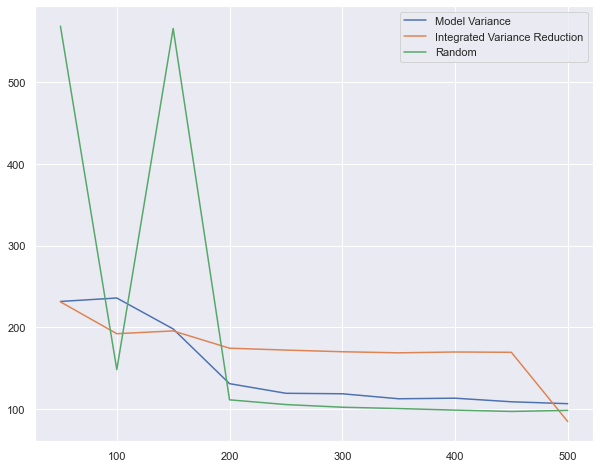

In [55]:
fig, ax = plt.subplots(figsize=(10,8))
X_mv, Y_mv = zip(*mses_MV)
X_ivr, Y_ivr = zip(*mses_IVR)
X_rnd, Y_rnd = zip(*mses_RND)
ax.plot(X_mv, Y_mv, label='Model Variance')
ax.plot(X_ivr, Y_ivr, label='Integrated Variance Reduction')
ax.plot(X_rnd, Y_rnd, label='Random')
ax.legend()

### Save Models

In [ ]:
with open(f'experimental_design/models/ARD_5param_model_variance_20_init_points_250_loops_co2_per_duration.pkl', "wb") as f:
     pickle.dump(emukit_model_mv, f)

with open(f'experimental_design/models/ARD_5param_integrated_variance_reduction_250_init_points_500_loops_co2_per_duration.pkl', "wb") as f:
     pickle.dump(emukit_model_ivr, f)
        
with open(f'experimental_design/models/ARD_5param_250_random_points_supervised_GP_co2_per_duration.pkl', "wb") as f:
     pickle.dump(emukit_model_rnd, f)
        
with open(f'experimental_design/models/ARD_mses.pkl', 'wb') as f:
    pickle.dump((mses_MV, mses_IVR, mses_RND), f)

FileNotFoundError: [Errno 2] No such file or directory: 'experimental_design/models/ARD_5param_model_variance_20_init_points_250_loops_co2_per_duration.pkl'